# myAOAnet

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import rosbag
from std_msgs.msg import String, Empty, Header, Float32, Float32MultiArray, MultiArrayDimension
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, median_absolute_error, accuracy_score
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-

1 Physical GPUs, 1 Logical GPUs


In [3]:
import keras
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed, Bidirectional, Dropout, BatchNormalization, Activation
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

['/job:localhost/replica:0/task:0/device:GPU:0']


Using TensorFlow backend.


## IQ data visualization

In [66]:
data_from = 'data_1407'

In [67]:
#iq_data0 = pd.read_csv(join(data_from, 'iq_example', 'log_long.csv'), sep=',', header=0)
iq_data0 = pd.read_csv(join(data_from, 'iq_example', 'test.csv'), sep=',', header=0)

In [68]:
iq_data = iq_data0.drop(iq_data0.columns[[index for index in range(11)]], axis = 1, inplace = False)
iq_data.shape

(100, 262144)

In [154]:
#iq_data[abs(iq_data['field.data2']) >= 5e-9]
iq_data[abs(iq_data['field.data2']) >= 5e-4]

,field.data0,field.data1,field.data2,field.data3,field.data4,field.data5,field.data6,field.data7,field.data8,field.data9,...,field.data262134,field.data262135,field.data262136,field.data262137,field.data262138,field.data262139,field.data262140,field.data262141,field.data262142,field.data262143
13,0.012443,0.005071,0.013233,-0.007298,-0.003263,-0.012466,-0.014219,0.000804,-0.002363,0.013512,...,0.402436,0.400352,0.173670,0.557049,-0.157145,0.547119,-0.446208,0.368850,-0.494325,0.137797
14,-0.008451,0.001674,-0.014348,0.006767,-0.013070,0.012878,-0.005521,0.017009,0.002998,0.017564,...,-0.051972,-0.566432,0.147737,-0.552561,0.383060,-0.435192,0.559278,-0.236624,0.527764,-0.050278
15,0.009737,0.000672,0.013015,0.008722,0.003873,0.015859,-0.011436,0.012597,-0.018164,-0.001381,...,0.519082,0.278226,0.251679,0.557115,-0.165544,0.558178,-0.493573,0.296115,-0.517698,0.002463
16,0.007471,0.009837,0.014259,0.000589,0.003794,-0.011716,-0.011791,-0.006884,-0.009169,0.009259,...,-0.548892,-0.100670,-0.510781,-0.185641,-0.486808,-0.309257,-0.452099,-0.418790,-0.345139,-0.400111
17,-0.008222,-0.001913,-0.015323,-0.004692,-0.017102,-0.007479,-0.014423,-0.009698,-0.011621,-0.011607,...,0.001961,0.004359,0.002644,0.005263,0.005617,0.006000,0.008718,0.005963,0.009978,0.005336
32,-0.005312,0.010881,-0.007410,0.021366,-0.003832,0.025730,0.003527,0.023970,0.010338,0.020837,...,0.373781,-0.083147,-0.042857,-0.368074,-0.394480,-0.018838,-0.073132,0.364013,0.422317,0.168493
33,-0.017740,-0.008316,-0.017914,0.009766,0.005352,0.015971,0.018125,-0.002596,0.000514,-0.017000,...,0.294465,-0.452126,0.533188,-0.147930,0.463491,0.248668,0.149270,0.498675,-0.132147,0.453604
34,0.012086,0.002162,0.021338,-0.002702,0.020055,-0.012679,0.008725,-0.021461,-0.004790,-0.023187,...,-0.232452,-0.454424,-0.166886,-0.467290,-0.071592,-0.520719,0.038176,-0.561187,0.099948,-0.471392
35,0.001270,-0.012894,-0.010083,-0.017237,-0.019766,-0.003553,-0.012564,0.016754,0.008841,0.020447,...,-0.014654,-0.446134,0.423218,-0.122969,0.260431,0.345848,-0.234412,0.305338,-0.412094,-0.104761
36,0.011489,0.001701,0.019221,0.008513,0.016176,0.017286,0.003552,0.022697,-0.010157,0.021174,...,-0.391644,-0.296490,-0.409466,-0.243646,-0.473777,-0.183300,-0.533461,-0.112777,-0.465443,-0.046513


In [179]:
sample_id = 31
iq_data_np = iq_data.to_numpy()[sample_id, :]

In [180]:
iq_arr = iq_data_np.reshape(4, 32768, 2)

Text(0.5, 1.0, 'Imag part of IQ CHN=0')

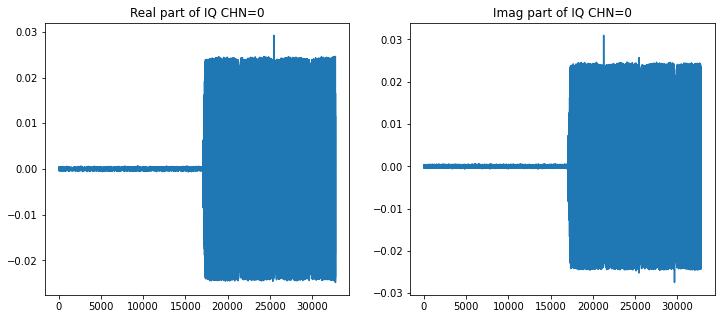

In [181]:
chn = 0

fig0 ,ax0 = plt.subplots(1, 2,figsize=(12,5))
ax0[0].plot(iq_arr[chn, :, 0])
ax0[0].set_title("Real part of IQ CHN=%d" % chn)
ax0[1].plot(iq_arr[chn, :, 1])
ax0[1].set_title("Imag part of IQ CHN=%d" % chn)
#plt.show()

Text(0.5, 1.0, 'Imag part of IQ CHN=3')

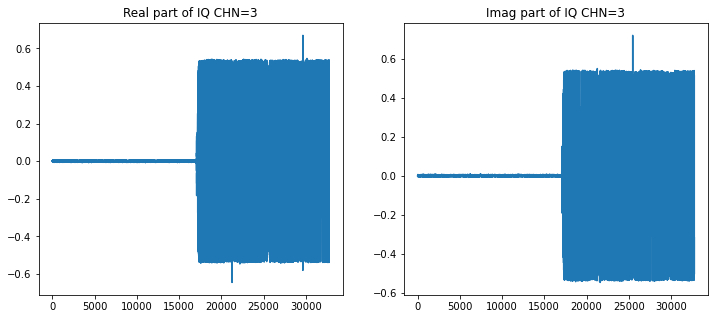

In [182]:
chn_compare = 3

fig0 ,ax0 = plt.subplots(1, 2,figsize=(12,5))
ax0[0].plot(iq_arr[chn_compare, :, 0])
ax0[0].set_title("Real part of IQ CHN=%d" % chn_compare)
ax0[1].plot(iq_arr[chn_compare, :, 1])
ax0[1].set_title("Imag part of IQ CHN=%d" % chn_compare)
#plt.show()

In [183]:
iq_amp = np.zeros((32768, 4))
iq_amp = np.sqrt(iq_arr[:, :, 0]**2 + iq_arr[:, :, 1]**2)
iq_amp.shape

(4, 32768)

In [184]:
iq_phase2 = np.zeros((32768, 4))
iq_phase2 = np.angle(iq_arr[:, :, 0] + iq_arr[:, :, 1]*1j)
iq_phase2.shape

(4, 32768)

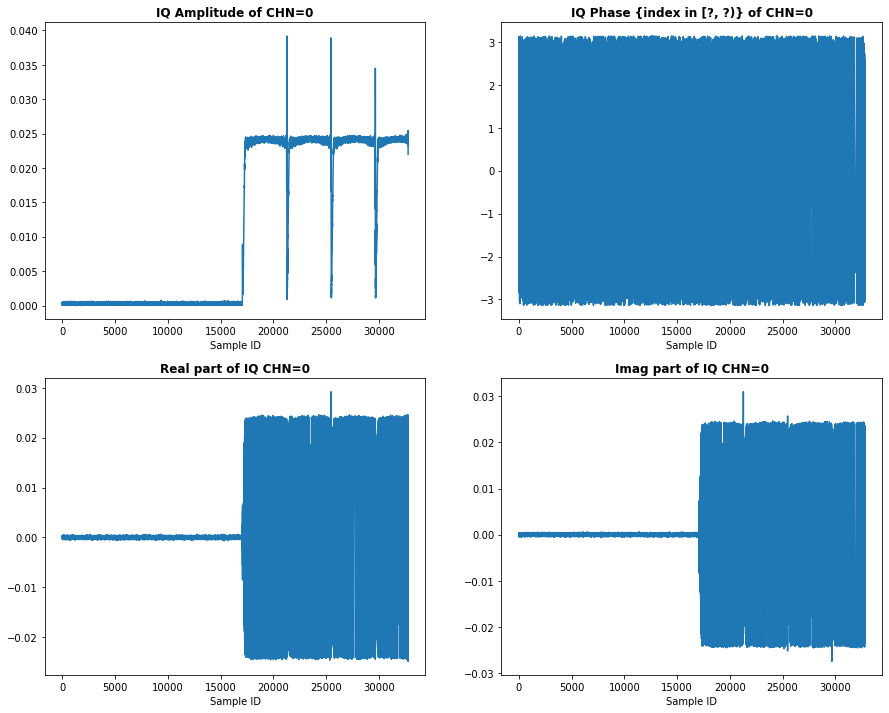

In [185]:
fig ,ax = plt.subplots(2, 2,figsize=(15,12))
ax[0,0].plot(iq_amp[chn, :])
ax[0,0].set_title("IQ Amplitude of CHN=%d" % chn, fontweight='bold')
ax[0,0].set_xlabel("Sample ID")
ax[0,1].plot(iq_phase2[chn, :])
ax[0,1].set_title("IQ Phase {index in [?, ?)} of CHN=%d" % chn, fontweight='bold')
ax[0,1].set_xlabel("Sample ID")

ax[1,0].plot(iq_arr[chn, :, 0])
ax[1,0].set_title("Real part of IQ CHN=%d" % chn, fontweight='bold')
ax[1,0].set_xlabel("Sample ID")
ax[1,1].plot(iq_arr[chn, :, 1])
ax[1,1].set_title("Imag part of IQ CHN=%d" % chn, fontweight='bold')
ax[1,1].set_xlabel("Sample ID")

plt.show()

In [156]:
fig.savefig(join('doc', '{data_from}-{samp_id}-{chn}'.format(data_from=data_from, samp_id=sample_id, chn=chn)), \
           facecolor="w", bbox_inches='tight')

## Load Raw Data and Save Signal_index & Music series

In [2]:
### Prepare Data from (ROSBAG ->) CSV -> DataFrame ###
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

def load_raw(data_dir='testLOS', field_thres=1e-5, slices=1, measure_music=False):
    aoa_dict = {}
    if slices > 1:
        end_digit = -6
    else:
        end_digit = -4

    for filename in os.listdir(data_dir):
        if filename.startswith("deg_m") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- int(filename[5:end_digit])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[int(filename[4:end_digit])] = aoa_Rjk

    # Degree to Radian
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180

    # Differentiate R from LoRa signal to Noise
    aoa_sig, aoa_noi = {}, {}
    sig_index_lst = {}

    # Filtering noise based on the threshold
    for key in aoa_dict.keys():
        filtered_indexed = aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data3']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data4']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data5']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data6']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data7']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data12']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data13']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data14']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data15']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data22']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data23']) >= field_thres)].index
        
        aoa_sig[key] = aoa_dict[key].iloc[filtered_indexed]
        aoa_noi[key] = aoa_dict[key].drop(filtered_indexed)
        sig_index_lst[key] = (filtered_indexed)

    # Concat dict of raw data into a DataFrame
    X = pd.concat([aoa_sig[rad] for rad in aoa_sig.keys()],
                  keys=[rad for rad in aoa_sig.keys()], names=['Series name', 'Row ID'])

    # Add a Column of MUSIC measurement; if no measurement, add 'NaN'
    if measure_music:
        music_dict = {}
        for filename in os.listdir(data_dir):
            if filename.startswith("music_deg_m") and filename.endswith(".csv"):
                music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
                music_deg.rename(columns={'field.data': 'music'}, inplace=True)
                music_series = music_deg['music']
                music_dict[- int(filename[11:-4])] = music_series
            elif filename.startswith("music_deg_") and filename.endswith(".csv"):
                music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
                music_deg.rename(columns={'field.data': 'music'}, inplace=True)
                music_series = music_deg['music']
                music_dict[int(filename[10:-4])] = music_series

        for key in music_dict.keys():
            music_dict[key] = music_dict[key][sig_index_lst[key]]

        Xmusic = pd.concat([music_dict[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)],
                           names=['Series name', 'Row ID'])
        X = pd.concat([X, Xmusic], axis=1)

    else:
        Xmusic = pd.Series([0] * len(X.index))
        X = pd.concat([X, Xmusic], axis=1)

    return X, Xmusic, sig_index_lst

In [ ]:
# Process All
for work_dir in ['data_1606', 'data_0107', 'data_0207', 'data_1407', 'data_1607']:
    df, df_music, df_sig_index = load_raw(data_dir=work_dir, measure_music=True)
    # Saving
    df_music.to_csv(join(work_dir, 'df_collection', 'music_series.csv'), index=True, header=True)
    with open(join(work_dir, 'df_collection', 'sig_index.pkl'), "wb") as a_file:
        pickle.dump(df_sig_index, a_file)
    print(df)

In [55]:
df, df_music, df_sig_index = load_raw(data_dir='data_1606', slices=8, measure_music=True)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
df

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         0          0.000046          0.0     0.002728     0.000348   
            1          0.000032          0.0     0.002230     0.000289   
            2          0.000008          0.0     0.000627     0.000079   
            27         0.000004          0.0     0.000310     0.000150   
            28         0.000120          0.0    -0.000454    -0.003152   
...                         ...          ...          ...          ...   
 70         707        0.002506          0.0     0.003383     0.023918   
            708        0.002359          0.0     0.003174     0.022460   
            709        0.001897          0.0     0.002347     0.017940   
            710        0.001451          0.0     0.001547     0.013673   
            711        0.000982          0.0     0.000807     0.009173   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         0          0.001615    -0.000416     0.001171    -0.000044   
            1          0.001354    -0.000339     0.001016    -0.000039   
            2          0.000384    -0.000098     0.000293    -0.000017   
            27         0.000223     0.000034     0.000113     0.000085   
            28        -0.000799    -0.001858     0.000271    -0.001878   
...                         ...          ...          ...          ...   
 70         707       -0.016969     0.003560     0.009624    -0.030561   
            708       -0.016128     0.003234     0.009060    -0.029390   
            709       -0.013109     0.002452     0.008144    -0.025374   
            710       -0.010135     0.001830     0.006969    -0.020548   
            711       -0.006896     0.001067     0.005356    -0.014184   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         0           0.165659           0.0  ...      0.069720   
            1           0.161718           0.0  ...      0.072078   
            2           0.050502           0.0  ...      0.023049   
            27          0.028097           0.0  ...      0.011273   
            28          0.165926           0.0  ...      0.082327   
...                          ...           ...  ...           ...   
 70         707         0.233392           0.0  ...     -0.278442   
            708         0.218569           0.0  ...     -0.267317   
            709         0.172999           0.0  ...     -0.229677   
            710         0.130789           0.0  ...     -0.186047   
            711         0.086527           0.0  ...     -0.127907   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         0          -0.011793      0.061505           0.0      0.042218   
            1          -0.012540      0.062923           0.0      0.044782   
            2          -0.004381      0.020062           0.0      0.014547   
            27          0.002239      0.011953           0.0      0.006618   
            28          0.023186      0.068399           0.0      0.046785   
...                          ...           ...           ...           ...   
 70         707        -0.132870      0.120211           0.0     -0.108666   
            708        -0.125657      0.114910           0.0     -0.102326   
            709        -0.108304      0.093950           0.0     -0.089175   
            710        -0.087480      0.073229           0.0     -0.074644   
            711        -0.061592      0.049657           0.0     -0.053037   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         0          

# Load via Rosbag

In [4]:
#Data_dir = ['data_1606', 'data_0107', 'data_0207', 'data_1407', 'data_1607']
Data_dir = ['data_0107', 'data_0207', 'data_1407']
#Noisy_lst = ['noisy20', 'noisy21', 'noisy22', 'noisy23', 'noisy24']
Noisy_lst = ['noisy30', 'noisy31', 'noisy32', 'noisy33', 'noisy34']
Bag_lst = ['deg_0.bag', 'deg_10.bag', 'deg_20.bag', 'deg_30.bag', 'deg_40.bag', \
           'deg_50.bag', 'deg_60.bag', 'deg_70.bag', 'deg_m10.bag', 'deg_m20.bag', \
           'deg_m30.bag', 'deg_m40.bag', 'deg_m50.bag', 'deg_m60.bag', 'deg_m70.bag']

def load_bag(data_dir=Data_dir[0], noisy_lst=Noisy_lst[0], bag_lst=Bag_lst[0], field_thres = 1e-4, 
             cast2image=True, IsMoveAxis=True, labels=None):
    
    with rosbag.Bag(join(data_dir, noisy_lst, bag_lst)) as bag:
        angl_val_lst = range(-74, 76, 2)

        #col_lst = range(256)  #160
        #df = pd.DataFrame(columns=col_lst)

        topic_head = '/kerberos/R_'
        angle_digit = len(topic_head)

        angle_lst, sigma_lst, data_lst = [], [], []

        for topic, msg, t in bag.read_messages():
            if topic.startswith(topic_head):
                angle = topic[angle_digit:angle_digit + 3]
                sigma = topic[-4:]
                if noisy_lst!='noisy20' and sigma=='0e_4':
                    continue
                
                angle_lst.append(int(angle) - 360)
                sigma_lst.append(sigma)

                data = np.asarray(msg.data).reshape((4, 4, 2, 8))

                if cast2image:
                    filtered_data = np.zeros((4, 4, 8))
                    
                    for i in range(4):
                        for j in range(4):
                            if i<=j:
                                filtered_data[i, j, :] = data[i, j, 0, :]
                            else:
                                filtered_data[i, j, :] = data[i, j, 1, :]
                    if IsMoveAxis:
                        # Moveaxis
                        filtered_data = np.moveaxis(filtered_data, -1, 0)            
                else:
                    
                    filtered_data = np.zeros((10, 2, 8))
                    k = 0
                    for i in range(4):
                        for j in range(4):
                            if i<=j:
                                filtered_data[k, :, :] = data[i, j, :, :]
                                k += 1
                                
                    if IsMoveAxis:
                        # Moveaxis
                        filtered_data = np.moveaxis(filtered_data, -1, 0)
                        
                #print(filtered_data)
                df_data = pd.DataFrame(filtered_data.reshape((1, -1), order='C'))
                
                data_lst.append(df_data)
                
            else:
                continue
        
        #print(data_lst)
        df = pd.concat(data_lst, axis=0, ignore_index=True)
        
        if labels is None:
            df['GT'] = pd.Series(angle_lst)
            df['sigma'] = pd.Series(sigma_lst)
        else:
            df['GT1'] = labels[0]
            df['GT2'] = labels[1]
        
        # Filter noise from Signal
        if cast2image:
            filtered_indexed = df[(abs(df[8]) >= field_thres) \
                                  & (abs(df[119]) >= field_thres)].index
            '''
            filtered_indexed = df[(abs(df[2]) >= field_thres) \
                                                     & (abs(df[1]) >= field_thres) \
                                                     & (abs(df[2]) >= field_thres) \
                                                     & (abs(df[3]) >= field_thres) \
                                                     & (abs(df[6]) >= field_thres) \
                                                    & (abs(df[7]) >= field_thres) \
                                                     & (abs(df[11]) >= field_thres) \
                                                     & (abs(df[113]) >= field_thres) \
                                                     & (abs(df[114]) >= field_thres) \
                                                     & (abs(df[115]) >= field_thres) \
                                                     & (abs(df[118]) >= field_thres) \
                                                     & (abs(df[119]) >= field_thres) \
                                                     & (abs(df[123]) >= field_thres)].index
            '''
        else:
            filtered_indexed = df[(abs(df[2]) >= field_thres) \
                                                     & (abs(df[3]) >= field_thres) \
                                                     & (abs(df[4]) >= field_thres) \
                                                     & (abs(df[5]) >= field_thres) \
                                                     & (abs(df[6]) >= field_thres) \
                                                     & (abs(df[7]) >= field_thres) \
                                                     & (abs(df[10]) >= field_thres) \
                                                     & (abs(df[11]) >= field_thres) \
                                                     & (abs(df[12]) >= field_thres) \
                                                     & (abs(df[13]) >= field_thres) \
                                                     & (abs(df[16]) >= field_thres) \
                                                     & (abs(df[17]) >= field_thres) \
                                 & (abs(df[142]) >= field_thres) \
                                                     & (abs(df[143]) >= field_thres) \
                                                     & (abs(df[144]) >= field_thres) \
                                                     & (abs(df[145]) >= field_thres) \
                                                     & (abs(df[146]) >= field_thres) \
                                                     & (abs(df[147]) >= field_thres) \
                                                     & (abs(df[150]) >= field_thres) \
                                                     & (abs(df[151]) >= field_thres) \
                                                     & (abs(df[152]) >= field_thres) \
                                                     & (abs(df[153]) >= field_thres) \
                                                     & (abs(df[156]) >= field_thres) \
                                                     & (abs(df[157]) >= field_thres)].index
        
        filtered_df = df.iloc[filtered_indexed]
        
    return filtered_df, filtered_indexed

In [51]:
X[0]

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,GT1,GT2
0,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000049,0.000048,...,0.001544,0.001546,0.001530,0.001547,0.001566,0.001568,0.001543,0.001559,-30,0
1,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000048,0.000049,...,0.001543,0.001546,0.001528,0.001547,0.001565,0.001569,0.001541,0.001560,-30,0
2,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000049,0.000049,...,0.001545,0.001548,0.001529,0.001549,0.001565,0.001570,0.001544,0.001558,-30,0
3,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000048,0.000048,...,0.001567,0.001579,0.001572,0.001559,0.001553,0.001556,0.001561,0.001562,-30,0
4,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000048,0.000048,...,0.001567,0.001580,0.001572,0.001560,0.001555,0.001557,0.001560,0.001561,-30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000037,0.000045,...,0.001181,0.001510,0.000952,0.001547,0.001199,0.001217,0.001709,0.001325,-30,0
932,0.000003,0.000003,0.000002,0.000003,0.000003,0.000003,0.000003,0.000003,0.000035,0.000047,...,0.001182,0.001512,0.000953,0.001549,0.001199,0.001221,0.001711,0.001328,-30,0
933,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000045,0.000045,...,0.001522,0.001506,0.001536,0.001538,0.001589,0.001578,0.001595,0.001602,-30,0
934,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000045,0.000045,...,0.001521,0.001507,0.001534,0.001538,0.001589,0.001579,0.001597,0.001603,-30,0


### Multilabel Preprocessing

In [5]:
Data_dir_multi = ['data_multi-30', 'data_multi-31', 'data_multi-32', 'data_multi-33', 'data_multi-34', 'data_multi-35']
bag_lst_multi = []
for filename in os.listdir('data_multi-30'):
    bag_lst_multi.append(filename)

def load_bag_multi(bagname, data_dir=Data_dir_multi[0], field_thres = 1e-4, cast2image=True, IsMoveAxis=True):
    
    with rosbag.Bag(join(data_dir, bagname)) as bag:
        
        deg1 = bagname.split("_")[0]
        deg2 = bagname.split("-")[1].split(".")[0]
        
        if deg1.startswith('m'):
            deg1 = -int(deg1[1:])
        else:
            deg1 = int(deg1)
        if deg2.startswith('m'):
            deg2 = -int(deg2[1:])
        else:
            deg2 = int(deg2)
        
        topic_head = '/kerberos/R_'
        angle_digit = len(topic_head)

        angle1_lst, angle2_lst, data_lst = [], [], []

        for topic, msg, t in bag.read_messages():
            if topic.startswith(topic_head):
                angle1 = topic[angle_digit:angle_digit + 3]
                angle2 = topic[-3:]
                
                # Labels of (angle1, angle2) in a list
                angle1_lst.append(int(angle1) - 360)
                angle2_lst.append(int(angle2) - 360)
                
                #print(np.asarray(msg.data))
                data = np.asarray(msg.data).reshape((4, 4, 2, 8))
                #print(data[:,:,0,0])

                if cast2image:
                    filtered_data = np.zeros((4, 4, 8))
                    
                    for i in range(4):
                        for j in range(4):
                            if i<=j:
                                filtered_data[i, j, :] = data[i, j, 0, :]
                            else:
                                filtered_data[i, j, :] = data[i, j, 1, :]
                    
                    #print(filtered_data[:,:,0])
                    # Moveaxis
                    if IsMoveAxis:
                        # Moveaxis
                        filtered_data = np.moveaxis(filtered_data, -1, 0) 
                    
                else:
                    
                    filtered_data = np.zeros((10, 2, 8))
                    k = 0
                    for i in range(4):
                        for j in range(4):
                            if i<=j:
                                filtered_data[k, :, :] = data[i, j, :, :]
                                k += 1
                    
                    if IsMoveAxis:
                        # Moveaxis
                        filtered_data = np.moveaxis(filtered_data, -1, 0)
                
                #print(filtered_data.shape)
                df_data = pd.DataFrame(filtered_data.reshape((1, -1), order='C'))
                #print(np.moveaxis(df_data.to_numpy().reshape((8, 4, 4)), 0, -1)[:,:,0])
                
                data_lst.append(df_data)
            else:
                continue
        
        if len(data_lst) == 0:
            print(bagname, " recorded 0 message!")
            return None
        #else:
        #    print(len(data_lst))
        
        df = pd.concat(data_lst, axis=0, ignore_index=True)
        df['GT1'] = pd.Series(angle1_lst)
        df['GT2'] = pd.Series(angle2_lst)
        
        # Filter noise from Signal
        if cast2image:
            filtered_indexed = df[(abs(df[2]) >= field_thres) \
                                                     & (abs(df[1]) >= field_thres) \
                                                     & (abs(df[2]) >= field_thres) \
                                                     & (abs(df[3]) >= field_thres) \
                                                     & (abs(df[6]) >= field_thres) \
                                                    & (abs(df[7]) >= field_thres) \
                                                     & (abs(df[11]) >= field_thres) \
                                                     & (abs(df[113]) >= field_thres) \
                                                     & (abs(df[114]) >= field_thres) \
                                                     & (abs(df[115]) >= field_thres) \
                                                     & (abs(df[118]) >= field_thres) \
                                                     & (abs(df[119]) >= field_thres) \
                                                     & (abs(df[123]) >= field_thres)].index
        else:
            filtered_indexed = df[(abs(df[2]) >= field_thres) \
                                                     & (abs(df[3]) >= field_thres) \
                                                     & (abs(df[4]) >= field_thres) \
                                                     & (abs(df[5]) >= field_thres) \
                                                     & (abs(df[6]) >= field_thres) \
                                                     & (abs(df[7]) >= field_thres) \
                                                     & (abs(df[10]) >= field_thres) \
                                                     & (abs(df[11]) >= field_thres) \
                                                     & (abs(df[12]) >= field_thres) \
                                                     & (abs(df[13]) >= field_thres) \
                                                     & (abs(df[16]) >= field_thres) \
                                                     & (abs(df[17]) >= field_thres) \
                                 & (abs(df[142]) >= field_thres) \
                                                     & (abs(df[143]) >= field_thres) \
                                                     & (abs(df[144]) >= field_thres) \
                                                     & (abs(df[145]) >= field_thres) \
                                                     & (abs(df[146]) >= field_thres) \
                                                     & (abs(df[147]) >= field_thres) \
                                                     & (abs(df[150]) >= field_thres) \
                                                     & (abs(df[151]) >= field_thres) \
                                                     & (abs(df[152]) >= field_thres) \
                                                     & (abs(df[153]) >= field_thres) \
                                                     & (abs(df[156]) >= field_thres) \
                                                     & (abs(df[157]) >= field_thres)].index
        
        filtered_df = df.iloc[filtered_indexed]
        
    return filtered_df

In [58]:
### Load all rosbags into list Xm
Xm = []
IsMoveAxis=False

for bagname in bag_lst_multi:
    df0 = load_bag_multi(bagname, data_dir='data_multi-81', field_thres = 1e-10, 
                         cast2image=True, IsMoveAxis=IsMoveAxis)
    if df0 is not None:
        Xm.append(df0) 
    
len(Xm)

50_multi-m10.bag  recorded 0 message!
m70_multi-m60.bag  recorded 0 message!


223

In [46]:
Xm[0]

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,GT1,GT2
0,0.002505,0.002401,0.002555,0.002397,0.002434,0.002498,0.002646,0.002504,-0.004562,-0.004489,...,0.419695,0.407747,0.429846,0.400410,0.409289,0.418535,0.444644,0.421669,66,26
1,0.002505,0.002401,0.002555,0.002397,0.002434,0.002498,0.002646,0.002504,-0.005840,-0.005708,...,0.419249,0.407853,0.429815,0.400382,0.409270,0.418595,0.444504,0.421780,68,26
2,0.002505,0.002401,0.002555,0.002397,0.002434,0.002498,0.002646,0.002504,-0.007108,-0.006917,...,0.418788,0.407912,0.429789,0.400357,0.409255,0.418652,0.444372,0.421869,70,26
3,0.002505,0.002401,0.002555,0.002397,0.002434,0.002498,0.002646,0.002504,-0.008362,-0.008111,...,0.418321,0.407922,0.429770,0.400337,0.409243,0.418703,0.444252,0.421936,72,26
4,0.002505,0.002401,0.002555,0.002397,0.002434,0.002498,0.002646,0.002504,-0.009598,-0.009289,...,0.417855,0.407884,0.429758,0.400322,0.409236,0.418747,0.444144,0.421978,74,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.002507,0.002467,0.002306,0.002435,0.002575,0.002297,0.002446,0.002590,-0.002304,-0.003406,...,0.440734,0.437872,0.407606,0.430369,0.452473,0.403176,0.427999,0.457621,66,34
671,0.002507,0.002467,0.002306,0.002435,0.002575,0.002297,0.002446,0.002590,-0.003622,-0.004711,...,0.440693,0.437991,0.408091,0.430292,0.452456,0.403172,0.427782,0.457649,68,34
672,0.002507,0.002467,0.002306,0.002435,0.002575,0.002297,0.002446,0.002590,-0.004936,-0.006009,...,0.440664,0.438103,0.408577,0.430223,0.452449,0.403157,0.427545,0.457678,70,34
673,0.002507,0.002467,0.002306,0.002435,0.002575,0.002297,0.002446,0.002590,-0.006241,-0.007296,...,0.440646,0.438208,0.409055,0.430165,0.452450,0.403132,0.427291,0.457706,72,34


In [59]:
# Save 'X' as .pkl
import pickle
IsLoadingXm = False

if IsLoadingXm:
    with open(join('Data', 'I-81.pkl'), 'rb') as a_file:
        Xm = pickle.load(a_file)
else:
    with open(join('Data', 'I-81.pkl'), 'wb') as a_file:
        pickle.dump(Xm, a_file)

In [7]:
Xm = []

In [5]:
# Load all Xms

with open(join('Data', 'I1_delay0_119.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I1_delay1_223.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I2_delay0_223.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I2_delay1_224.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
    
with open(join('Data', 'I3_delay0_109.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I3_delay1_224.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
    
with open(join('Data', 'I4_delay0_223.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I4_delay1_224.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
    
with open(join('Data', 'I5_delay0_108.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I5_delay1_225.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I6_delay0_122.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I6_delay1_223.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

119
342
565
789
898
1122
1345
1569
1677
1902
2024
2247


In [8]:
# Load all Xms without MoveAxis!
'''
with open(join('Data', 'I-30.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
with open(join('Data', 'I-31.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
'''
with open(join('Data', 'I-40.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
with open(join('Data', 'I-41.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
'''
with open(join('Data', 'I-50.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
with open(join('Data', 'I-51.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))

with open(join('Data', 'I-60.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
with open(join('Data', 'I-61.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
with open(join('Data', 'I-70.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
with open(join('Data', 'I-71.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
'''
with open(join('Data', 'I-80.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))
with open(join('Data', 'I-81.pkl'), 'rb') as a_file:
    Xm.extend(pickle.load(a_file))
    print(len(Xm))


223
447
569
792


In [9]:
len(Xm)

792

In [10]:
### Concatenate and Convert X to numpy X-y pairs
Xmvec_lst, ymvec_lst = [], []

for item in Xm:
    Xmvec_lst.append(item.drop(['GT1', 'GT2'], axis=1).to_numpy())
    ymvec_lst.append(item[['GT1', 'GT2']].to_numpy())

#del Xm

ymvec = np.concatenate(ymvec_lst, axis=0)

Xmvec = np.zeros((ymvec.shape[0], Xmvec_lst[0].shape[1]), dtype=np.float32)
tmp_row = 0
for index, item in enumerate(Xmvec_lst):
    Xmvec[tmp_row:tmp_row + item.shape[0], :] = item
    tmp_row += item.shape[0]
    
    if index == 341:
        print(tmp_row)
    if index == 788:
        print(tmp_row)
    if index == 1121:
        print(tmp_row)
    if index == 1568:
        print(tmp_row)
    if index == 1901:
        print(tmp_row)
    if index == 2246:
        print(tmp_row)
    
print(Xmvec.shape)
print(ymvec.shape)

259950
582933
(584533, 128)
(584533, 2)


In [109]:
del Xmvec_lst, ymvec_lst

In [18]:
### SHUFFLE Xm only! ###
X_train, X_test, y_train, y_test = train_test_split(Xmvec, ymvec, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

X_train.shape

(611431, 128)

#### If mix Single-Multiple Sources to ym

In [92]:
### If use 1-source only ###
Xxvec = Xvec
print(Xxvec.shape)

(563925, 128)


In [17]:
Xxvec = np.concatenate((Xvec, Xmvec), axis=0)
print(Xxvec.shape)

(1148458, 128)


In [18]:
yyvec = np.zeros((Xxvec.shape[0], 3), dtype=np.float32)

# Single-source
yyvec[:yvec.shape[0], 0] = 0.
yyvec[:yvec.shape[0], 1] = yvec[:, 0]
yyvec[:yvec.shape[0], 2] = yvec[:, 0]

# Multiple-source
yyvec[-ymvec.shape[0]:, 0] = 1.
yyvec[-ymvec.shape[0]:, 1] = ymvec[:, 0]
yyvec[-ymvec.shape[0]:, 2] = ymvec[:, 1]

print(yyvec.shape)

(1148458, 3)


In [94]:
print(Xxvec[:10], yyvec[:10])

[[0.00210612 0.0021181  0.00210882 ... 0.43016016 0.40926886 0.41026834]
 [0.00210612 0.0021181  0.00210882 ... 0.43016016 0.40926886 0.41026834]
 [0.00210612 0.0021181  0.00210882 ... 0.43016016 0.40926886 0.41026834]
 ...
 [0.00210786 0.00211872 0.00210865 ... 0.4301554  0.4092657  0.41024873]
 [0.00210786 0.00211872 0.00210865 ... 0.4301554  0.4092657  0.41024873]
 [0.00210786 0.00211872 0.00210865 ... 0.4301554  0.4092657  0.41024873]] [[ 0. -4. -4.]
 [ 0. -2. -2.]
 [ 0.  0.  0.]
 [ 0.  2.  2.]
 [ 0.  4.  4.]
 [ 0. -4. -4.]
 [ 0. -2. -2.]
 [ 0.  0.  0.]
 [ 0.  2.  2.]
 [ 0.  4.  4.]]


### Loading X-y numpy.array Directly

In [4]:
### Save/Load {Xxvec, yyvec} to .npy ###
#np.save(join('Data', 'Xxvec.npy'), Xxvec)
#np.save(join('Data', 'yyvec.npy'), yyvec)
Xxvec = np.load(join('Data', 'Xxvec.npy'))
yyvec = np.load(join('Data', 'yyvec.npy'))

In [4]:
### Save/Load {Xxvec, yyvec} to .npy without MoveAxis ###
#np.save(join('Data', 'Xxvec-originaxis.npy'), Xxvec)
#np.save(join('Data', 'yyvec-originaxis.npy'), yyvec)
Xxvec = np.load(join('Data', 'Xxvec-originaxis.npy'))
yyvec = np.load(join('Data', 'yyvec-originaxis.npy'))

In [19]:
### Save/Load {Xxvec, yyvec} to .npy without MoveAxis for "1407-split" ###
#np.save(join('Data', 'Xxvec_225-split_Xm.npy'), Xxvec)
#np.save(join('Data', 'yyvec_225-split_Xm.npy'), yyvec)
Xxvec = np.load(join('Data', 'Xxvec_225-split_Xm.npy'))
yyvec = np.load(join('Data', 'yyvec_225-split_Xm.npy'))

In [5]:
# If add Gaussian Noise to R
Xxvec1_scale1_5 = Xxvec + np.random.normal(0., 1e-6, Xxvec.shape)
#Xxvec2_scale1_5 = Xxvec + np.random.normal(0., 1e-5, Xxvec.shape)

# RAM explode!
#Xxvec = np.concatenate((Xxvec, Xxvec1_scale1_5), axis=0)
#yyvec = np.concatenate((yyvec, yyvec), axis=0)

Xxvec = Xxvec1_scale1_5

print(Xxvec.shape, yyvec.shape)

(5447964, 128) (5447964, 3)


In [86]:
# If only take Single-Source dataset
#Xxvec = Xxvec[:904380]
#yyvec = yyvec[:904380]
Xxvec = Xxvec[:960389]
yyvec = yyvec[:960389]

In [20]:
### SHUFFLE ###
X_train, X_test, y_train, y_test = train_test_split(Xxvec, yyvec, test_size=0.1)#, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3333)#, random_state=1)

print(X_train.shape, y_train.shape)

(689109, 128) (689109, 3)


In [21]:
# Normalize StandardScaling
sscaler = StandardScaler()

IsLoadingScaler = True
if IsLoadingScaler:
    with open(join('checkpoints', 'StandardScaler-X225split_Xm.pkl'), 'rb') as a_file:
        sscaler = pickle.load(a_file)
else:
    sscaler.fit(X_train)
    with open(join('checkpoints', 'StandardScaler-X225split_Xm.pkl'), 'wb') as a_file:
        pickle.dump(sscaler, a_file)
print("Sscaler samples: ", sscaler.n_samples_seen_)

X_train_std = sscaler.transform(X_train)
X_test_std = sscaler.transform(X_test)
X_val_std = sscaler.transform(X_val)

#del X_train, X_test, X_val

# Make y[:, 1:3] in ascending order
y_train_sort = np.concatenate((y_train[:, 0:1], np.sort(np.asarray(y_train[:,1:3], dtype=np.float32))), axis=1)
print(X_train_std.shape, y_train_sort.shape)
y_test_sort = np.concatenate((y_test[:, 0:1], np.sort(np.asarray(y_test[:,1:3], dtype=np.float32))), axis=1)
print(X_test_std.shape, y_test_sort.shape)
y_val_sort = np.concatenate((y_val[:, 0:1], np.sort(np.asarray(y_val[:,1:3], dtype=np.float32))), axis=1)
print(X_val_std.shape, y_val_sort.shape)

Sscaler samples:  689109
(689109, 128) (689109, 3)
(114846, 128) (114846, 3)
(344503, 128) (344503, 3)


In [22]:
### If cast input features to (4, 4, CHN) images ###
IsMoveAxis = False

I_train_std = X_train_std.reshape((X_train_std.shape[0], 4, 4, 8))
I_test_std = X_test_std.reshape((X_test_std.shape[0], 4, 4, 8))
I_val_std = X_val_std.reshape((X_val_std.shape[0], 4, 4, 8))

if IsMoveAxis:
    I_train_std = X_train_std.reshape((X_train_std.shape[0], 8, 4, 4))
    I_train_std = np.moveaxis(I_train_std, 1, -1)
    I_test_std = X_test_std.reshape((X_test_std.shape[0], 8, 4, 4))
    I_test_std = np.moveaxis(I_test_std, 1, -1)
    I_val_std = X_val_std.reshape((X_val_std.shape[0], 8, 4, 4))
    I_val_std = np.moveaxis(I_val_std, 1, -1)
print(I_train_std.shape)
print(I_test_std.shape)
print(I_val_std.shape)

(689109, 4, 4, 8)
(114846, 4, 4, 8)
(344503, 4, 4, 8)


In [23]:
# Minmax-Normalize y
ymin, ymax = -74, 74
ym_train_std = np.concatenate((y_train_sort[:, 0:1], (y_train[:,1:3] - ymin) / (ymax-ymin)), axis=1)
ym_test_std = np.concatenate((y_test_sort[:, 0:1], (y_test[:,1:3] - ymin) / (ymax-ymin)), axis=1)
ym_val_std = np.concatenate((y_val_sort[:, 0:1], (y_val[:,1:3] - ymin) / (ymax-ymin)), axis=1)
print(ym_train_std.shape)

(689109, 3)


#### StandardScaler for Normalization (multilabel-only)

In [28]:
# Normalize StandardScaling
sscaler = StandardScaler()
sscaler.fit(X_train)
print("Mean = ", sscaler.mean_)
X_train_std = sscaler.transform(X_train)
X_test_std = sscaler.transform(X_test)
X_val_std = sscaler.transform(X_val)

#del X_train, X_test, X_val

# Make y in ascending order
y_train = np.sort(np.asarray(y_train[:,0:2], dtype=np.float32))
print(X_train_std.shape, y_train.shape)
y_test = np.sort(np.asarray(y_test[:,0:2], dtype=np.float32))
print(X_test_std.shape, y_test.shape)
y_val = np.sort(np.asarray(y_val[:,0:2], dtype=np.float32))
print(X_val_std.shape, y_val.shape)

Mean =  [ 0.00204048  0.00590069 -0.00747568 -0.0045317   0.00382752  0.33202102
  0.16847336 -0.20908175  0.00576878 -0.12366012  0.51578261  0.16043236
 -0.00092387 -0.08105338 -0.15714236  0.63029845  0.00204233  0.00589502
 -0.0074863  -0.00453943  0.00382757  0.33229606  0.16854701 -0.209284
  0.00578113 -0.12386716  0.51638446  0.16083915 -0.00091073 -0.08116164
 -0.15743213  0.6308416   0.00204097  0.0058951  -0.0074856  -0.00452162
  0.00382574  0.33204622  0.16839964 -0.20895428  0.00577879 -0.12378638
  0.51589926  0.16101632 -0.00092243 -0.08142688 -0.15721193  0.63035935
  0.00204179  0.00589717 -0.00750055 -0.00455529  0.0038417   0.33216058
  0.16853317 -0.20904124  0.00577935 -0.12356975  0.51617901  0.16097402
 -0.00092602 -0.08104698 -0.1570242   0.63066046  0.00204338  0.00590632
 -0.00748292 -0.00454205  0.00383362  0.332229    0.16865492 -0.20920501
  0.00578641 -0.12374014  0.5164388   0.1609197  -0.00089635 -0.08137984
 -0.15739681  0.63119463  0.00204157  0.00589

In [11]:
### If cast input features to (4, 4, CHN) images ###
I_train_std = X_train_std.reshape((X_train_std.shape[0], 8, 4, 4))
I_train_std = np.moveaxis(I_train_std, 1, -1)
print(I_train_std.shape)

(552425, 4, 4, 8)


In [12]:
I_test_std = X_test_std.reshape((X_test_std.shape[0], 8, 4, 4))
I_test_std = np.moveaxis(I_test_std, 1, -1)
I_val_std = X_val_std.reshape((X_val_std.shape[0], 8, 4, 4))
I_val_std = np.moveaxis(I_val_std, 1, -1)

#### MinmaxScaler for Normalization

In [9]:
# Normalize minmaxScaling
xmax = np.max(X_train)
xmin = np.min(X_train)
print("X_train max value = %.04f; X_train min value = %.04f" % (xmin, xmax))
X_train_std = 2 * (X_train - xmin)/(xmax-xmin) - 1
X_test_std = 2 * (X_test - xmin)/(xmax-xmin) - 1
X_val_std = 2 * (X_val - xmin)/(xmax-xmin) - 1

# Make y in ascending order
y_train = np.sort(np.asarray(y_train[:,0:2], dtype=np.float32))
print(X_train_std.shape, y_train.shape)
y_test = np.sort(np.asarray(y_test[:,0:2], dtype=np.float32))
print(X_test_std.shape, y_test.shape)
y_val = np.sort(np.asarray(y_val[:,0:2], dtype=np.float32))
print(X_val_std.shape, y_val.shape)

X_train max value = -0.9692; X_train min value = 1.5926
(895562, 160) (895562, 2)
(447782, 160) (447782, 2)
(895562, 160) (895562, 2)


#### Normalize y to yhot

In [13]:
# Create Multihot encoded for Multilabel data (1)
mlb = MultiLabelBinarizer()
mlb.fit(y_train)
print("MultiLabelBinarizer class: ", mlb.classes_)
ymultihot_train = mlb.transform(y_train)
ymultihot_test = mlb.transform(y_test)
ymultihot_val = mlb.transform(y_val)

MultiLabelBinarizer class:  [-74.0 -72.0 -70.0 -68.0 -66.0 -64.0 -62.0 -60.0 -58.0 -56.0 -54.0 -52.0
 -50.0 -48.0 -46.0 -44.0 -42.0 -40.0 -38.0 -36.0 -34.0 -32.0 -30.0 -28.0
 -26.0 -24.0 -22.0 -20.0 -18.0 -16.0 -14.0 -12.0 -10.0 -8.0 -6.0 -4.0 -2.0
 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0
 30.0 32.0 34.0 36.0 38.0 40.0 42.0 44.0 46.0 48.0 50.0 52.0 54.0 56.0
 58.0 60.0 62.0 64.0 66.0 68.0 70.0 72.0 74.0]


In [14]:
yhot_train = ymultihot_train
yhot_test = ymultihot_test
yhot_val = ymultihot_val

In [57]:
# Create One-vs-All onehot encoded for Multilabel data (2)
def create_one_vs_all_encoded(y, labels_deg=np.arange(-74, 76, 2)):
    SF = np.size(labels_deg, 0)
    
    y_one_vs_all_index = np.zeros(y.shape[0], dtype=np.uint8)
    y_one_vs_all_encoded = np.zeros((int(SF * (SF-1)/2), int(SF)), dtype=np.uint8)
    k = 0
    for i in range(SF):
        for j in range(SF):
            if i<j:
                hot_row = np.zeros(SF, dtype=np.uint8)
                hot_row[i] = 1
                hot_row[j] = 1
                y_one_vs_all_encoded[k] = hot_row
                k += 1
    print(k-1, y_one_vs_all_encoded.shape[0])
    
    for index in range(y.shape[0]):
        for idx in range(y_one_vs_all_encoded.shape[0]):
            if np.equal(y[index], y_one_vs_all_encoded[idx]).all():
                #print(index, idx)
                y_one_vs_all_index[index] = idx
                
    return y_one_vs_all_index

In [ ]:
yhot_train[10003]

In [11]:
# Create y for AEC (Multihot encoded): SLOW!
def create_multihot_encoded(y, labels_deg=np.arange(-74, 76, 2)):
    SF = np.size(labels_deg, 0)
    
    y_hot_encoded = np.zeros((len(y), SF), dtype=np.uint8)
    for index, i in np.ndenumerate(y):
        for idx, j in enumerate(labels_deg):
            if i==j:
                y_hot_encoded[index[0], idx] = 1
                
    return y_hot_encoded

In [12]:
label_angls = np.arange(-74, 76, 2)

yhot_train = create_multihot_encoded(y_train, label_angls)
yhot_test = create_multihot_encoded(y_test, label_angls)
yhot_val = create_multihot_encoded(y_val, label_angls)

In [13]:
yhot_test[:4]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    

#### Normalize y to yprob

In [126]:
ymin, ymax = -74, 74

def create_angle_prob_pair(y, ymin=ymin, ymax=ymax):
    
    y_norm = np.ones((y.shape[0], y.shape[1]*2), dtype=np.float32)
    
    y_norm[:, 0] = (y[:, 0] - ymin) / (ymax - ymin)
    y_norm[:, 2] = (y[:, 1] - ymin) / (ymax - ymin)
    
    y_single = np.equal(y[:, 0], y[:, 1])
    
    y_norm[y_single, -1] = 0.
    
    return y_norm

In [127]:
yprob_train = create_angle_prob_pair(y_train)
yprob_test = create_angle_prob_pair(y_test)
yprob_val = create_angle_prob_pair(y_val)

In [128]:
yprob_train.shape

(143050, 4)

#### end-multi; process Single-source below

# Load Rosbag for MUSIC

In [28]:
Data_dir = ['data_1606', 'data_0107', 'data_0207', 'data_1407', 'data_1607']
Noisy_lst = ['noisy20', 'noisy21', 'noisy22', 'noisy23', 'noisy24']
Bag_lst = ['deg_0.bag', 'deg_10.bag', 'deg_20.bag', 'deg_30.bag', 'deg_40.bag', \
           'deg_50.bag', 'deg_60.bag', 'deg_70.bag', 'deg_m10.bag', 'deg_m20.bag', \
           'deg_m30.bag', 'deg_m40.bag', 'deg_m50.bag', 'deg_m60.bag', 'deg_m70.bag']

def load_bag_R(filtered_index, data_dir=Data_dir[0], noisy_lst=Noisy_lst[0], bag_lst=Bag_lst[0], field_thres = 1e-4):
    
    with rosbag.Bag(join(data_dir, noisy_lst, bag_lst)) as bag:
        angl_val_lst = range(-74, 76, 2)

        topic_head = '/kerberos/R_'
        angle_digit = len(topic_head)

        angle_lst, sigma_lst, data_lst = [], [], []

        for topic, msg, t in bag.read_messages():
            if topic.startswith(topic_head):
                angle = topic[angle_digit:angle_digit + 3]
                sigma = topic[-4:]
                if noisy_lst!='noisy20' and sigma=='0e_4':
                    continue
                
                angle_lst.append(int(angle) - 360)
                sigma_lst.append(sigma)

                data = np.asarray(msg.data).reshape((4, 4, 2, 8))
                
                filtered_data = data[:, :, :, 0]

                df_data = pd.DataFrame(filtered_data.reshape((1, -1), order='C'))
                
                data_lst.append(df_data)
                
            else:
                continue
                
        df = pd.concat(data_lst, axis=0, ignore_index=True)
        df['GT'] = pd.Series(angle_lst)
        df['sigma'] = pd.Series(sigma_lst)
        
        
        filtered_df = df.iloc[filtered_index]
        
    return filtered_df

In [84]:
### Load all rosbags into list X
X = []
X_index = []

for data_dir in Data_dir:
    for noisy_idx in Noisy_lst:
        for bagname in Bag_lst:
            df_item, index_item = load_bag(data_dir, noisy_idx, bagname,
                                           field_thres=1e-10, cast2image=True, IsMoveAxis=False)
            X.append(df_item)
            X_index.append(index_item)
            
len(X)

225

In [29]:
### Load all rosbags for MUSIC Eval!
X = []
i = 0

for data_dir in Data_dir:
    for noisy_idx in Noisy_lst:
        for bagname in Bag_lst:
            df_item = load_bag_R(X_index[i], data_dir, noisy_idx, bagname)
            X.append(df_item)
            i += 1
            
len(X)

375

In [31]:
# Save 'X' as .pkl
import pickle
IsLoading = True

if IsLoading:
    with open(join('Data', 'I-375.pkl'), 'rb') as a_file:
        X = pickle.load(a_file)
else:
    with open(join('Data', 'I-375.pkl'), 'wb') as a_file:
        pickle.dump(X, a_file)

In [11]:
# Save 'X' as .pkl
import pickle
IsLoading = True

if IsLoading:
    with open(join('Data', 'I-225.pkl'), 'rb') as a_file:
        X = pickle.load(a_file)
else:
    with open(join('Data', 'I-225.pkl'), 'wb') as a_file:
        pickle.dump(X, a_file)

In [30]:
# Save 'X' as .pkl for MUSIC Eval
IsLoadingXmusic = True

if IsLoadingXmusic:
    with open(join('Data', 'Imusic-375.pkl'), 'rb') as a_file:
        X = pickle.load(a_file)
else:
    with open(join('Data', 'Imusic-375.pkl'), 'wb') as a_file:
        pickle.dump(X, a_file)

In [32]:
len(X)

375

In [12]:
### Concatenate and Convert X to numpy X-y pairs
Xvec = np.array([])
yvec = np.array([])

Xvec_lst, yvec_lst = [], []

for item in X:
    Xvec_lst.append(item.drop(['GT', 'sigma'], axis=1).to_numpy())
    yvec_lst.append(item[['GT', 'sigma']].to_numpy())

In [12]:
del X

In [13]:
yvec = np.concatenate(yvec_lst, axis=0)

print(Xvec.shape)
print(yvec.shape)

(0,)
(563925, 2)


In [14]:
Xvec = np.zeros((yvec.shape[0], 128), dtype=np.float32)
#Xvec = np.zeros((yvec.shape[0], 32), dtype=np.float32)

In [15]:
tmp_row = 0
for item in Xvec_lst:
    Xvec[tmp_row:tmp_row + item.shape[0], :] = item
    tmp_row += item.shape[0]

In [16]:
print(Xvec.shape)
print(yvec.shape)

(563925, 128)
(563925, 2)


In [90]:
del Xvec_lst, yvec_lst

#### (Load Rosbag for SNR Eval)

In [87]:
### Load all rosbags into list X
X = []
X_index = []

Test_dir = ['data_1407']
Noisy_test_lst = ['noisy81']
Bag_test_lst = ['deg_0.bag', 'deg_10.bag', 'deg_20.bag', 'deg_30.bag', 'deg_40.bag', \
           'deg_50.bag', 'deg_60.bag', 'deg_70.bag', 'deg_m10.bag', 'deg_m20.bag', \
           'deg_m30.bag', 'deg_m40.bag', 'deg_m50.bag', 'deg_m60.bag', 'deg_m70.bag']

for data_dir in Test_dir:
    for noisy_idx in Noisy_test_lst:
        for bagname in Bag_test_lst:
            df_item, _ = load_bag(data_dir, noisy_idx, bagname, field_thres = 1e-10, cast2image=True,
                                 IsMoveAxis=False)
            X.append(df_item)
            #X_index.append(index_item)
            
len(X)

15

In [95]:
### Concatenate and Convert X to numpy X-y pairs
Xvec = np.array([])
yvec = np.array([])

Xvec_lst, yvec_lst = [], []

SIGMA = '1e_2'
#SIGMA = '20db'

for item in X:
    df_indexes = item[item['sigma'] == SIGMA].index
    #print(item.loc[df_indexes, :].drop(['GT', 'sigma'], axis=1).to_numpy().shape)
    Xvec_lst.append(item.loc[df_indexes, :].drop(['GT', 'sigma'], axis=1))
    yvec_lst.append(item.loc[df_indexes, :][['GT', 'sigma']].to_numpy())

In [96]:
Xvec_lst[0]

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
5,0.000453,0.000453,0.000469,0.000454,0.000465,0.000471,0.000464,0.000480,0.002038,0.002017,...,-0.086907,-0.086392,0.462314,0.464459,0.465701,0.468071,0.468377,0.482566,0.464983,0.462619
6,0.000453,0.000453,0.000469,0.000454,0.000465,0.000471,0.000464,0.000480,0.001992,0.001972,...,-0.084153,-0.083708,0.462314,0.464459,0.465701,0.468071,0.468377,0.482566,0.464983,0.462619
7,0.000453,0.000453,0.000469,0.000454,0.000465,0.000471,0.000464,0.000480,0.001942,0.001923,...,-0.081234,-0.080860,0.462314,0.464459,0.465701,0.468071,0.468377,0.482566,0.464983,0.462619
8,0.000453,0.000453,0.000469,0.000454,0.000465,0.000471,0.000464,0.000480,0.001888,0.001871,...,-0.078159,-0.077856,0.462314,0.464459,0.465701,0.468071,0.468377,0.482566,0.464983,0.462619
9,0.000453,0.000453,0.000469,0.000454,0.000465,0.000471,0.000464,0.000480,0.001831,0.001815,...,-0.074938,-0.074706,0.462314,0.464459,0.465701,0.468071,0.468377,0.482566,0.464983,0.462619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,0.000377,0.000380,0.000382,0.000386,0.000378,0.000390,0.000383,0.000389,0.001105,0.001139,...,-0.119464,-0.120691,0.410290,0.425470,0.420383,0.416271,0.417305,0.418331,0.418235,0.418281
4306,0.000377,0.000380,0.000382,0.000386,0.000378,0.000390,0.000383,0.000389,0.001055,0.001087,...,-0.116995,-0.118283,0.410290,0.425470,0.420383,0.416271,0.417305,0.418331,0.418235,0.418281
4307,0.000377,0.000380,0.000382,0.000386,0.000378,0.000390,0.000383,0.000389,0.001002,0.001034,...,-0.114298,-0.115644,0.410290,0.425470,0.420383,0.416271,0.417305,0.418331,0.418235,0.418281
4308,0.000377,0.000380,0.000382,0.000386,0.000378,0.000390,0.000383,0.000389,0.000948,0.000978,...,-0.111382,-0.112784,0.410290,0.425470,0.420383,0.416271,0.417305,0.418331,0.418235,0.418281


In [97]:
yvec = np.concatenate(yvec_lst, axis=0)

Xvec = np.zeros((yvec.shape[0], 128), dtype=np.float32)
tmp_row = 0
for item in Xvec_lst:
    Xvec[tmp_row:tmp_row + item.shape[0], :] = item
    tmp_row += item.shape[0]

print(Xvec.shape)
print(yvec.shape)

(12520, 128)
(12520, 2)


In [98]:
Xxvec = Xvec

yyvec = np.zeros((Xxvec.shape[0], 3), dtype=np.float32)

# Single-source
yyvec[:yvec.shape[0], 0] = 0.
yyvec[:yvec.shape[0], 1] = yvec[:, 0]
yyvec[:yvec.shape[0], 2] = yvec[:, 0]
'''
# Multiple-source
yyvec[-ymvec.shape[0]:, 0] = 1.
yyvec[-ymvec.shape[0]:, 1] = ymvec[:, 0]
yyvec[-ymvec.shape[0]:, 2] = ymvec[:, 1]
'''
print(Xxvec.shape, yyvec.shape)

(12520, 128) (12520, 3)


In [99]:
### SHUFFLE ###
X_train, X_test, y_train, y_test = train_test_split(Xxvec, yyvec, test_size=0.01)#, random_state=42)

# Normalize StandardScaling
sscaler = StandardScaler()

IsLoadingScaler = True
if IsLoadingScaler:
    with open(join('checkpoints', 'StandardScaler-originaxis.pkl'), 'rb') as a_file:
        sscaler = pickle.load(a_file)
print("Sscaler samples: ", sscaler.n_samples_seen_)

X_train_std = sscaler.transform(X_train)

# Make y[:, 1:3] in ascending order
y_train_sort = np.concatenate((y_train[:, 0:1], np.sort(np.asarray(y_train[:,1:3], dtype=np.float32))), axis=1)
print(X_train_std.shape, y_train_sort.shape)

### If cast input features to (4, 4, CHN) images ###
I_train_std = X_train_std.reshape((X_train_std.shape[0], 4, 4, 8))
#I_train_std = X_train_std.reshape((X_train_std.shape[0], 8, 4, 4))
#I_train_std = np.moveaxis(I_train_std, 1, -1)
print(I_train_std.shape)

# Normalize y
ymin, ymax = -74, 74
ym_train_std = np.concatenate((y_train_sort[:, 0:1], (y_train[:,1:3] - ymin) / (ymax-ymin)), axis=1)
print(ym_train_std.shape)

Sscaler samples:  1634470
(12394, 128) (12394, 3)
(12394, 4, 4, 8)
(12394, 3)


#### Remove 'Nan's

In [54]:
yvec0 = np.asarray(yvec[:,0], dtype=np.float32)

In [55]:
### Preparation
# Check if any 'NAN'
print(np.isnan(Xvec).any())
print(np.isnan(yvec0).any())

False
False


In [ ]:
# Remove 'NAN' in datasets!
'''
Xvec_clean = Xvec[~np.isnan(Xvec).any(axis=1)]
print(Xvec_clean.shape)
yvec_clean = yvec[~np.isnan(yvec).any(axis=1)]
print(yvec_clean.shape)

print(np.min(Xvec_clean), np.max(yvec_clean))
'''

In [47]:
# Saving/Loading clean Xvec/yvec numpy.array
'''
IsLoadingNp = False

if IsLoadingNp:
    Xvec = np.loadtxt(join('Data', 'X_375.csv.gz'), delimiter=",")
    yvec = np.loadtxt(join('Data', 'y_375.csv.gz'), delimiter=",")
else:
    np.savetxt(join('Data', 'X_375.csv.gz'), Xvec, delimiter=",")
    np.savetxt(join('Data', 'y_375.csv.gz'), yvec, delimiter=",")
'''

'\nIsLoadingNp = False\n\nif IsLoadingNp:\n    Xvec = np.loadtxt(join(\'Data\', \'X_375.csv.gz\'), delimiter=",")\n    yvec = np.loadtxt(join(\'Data\', \'y_375.csv.gz\'), delimiter=",")\nelse:\n    np.savetxt(join(\'Data\', \'X_375.csv.gz\'), Xvec, delimiter=",")\n    np.savetxt(join(\'Data\', \'y_375.csv.gz\'), yvec, delimiter=",")\n'

## Prepare Traning/Label Data

In [51]:
# SHUFFLE
X_train, X_test, y_train, y_test = train_test_split(Xvec, yvec, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

X_train.shape

(22018, 160)

In [52]:
# Normalize
xmax = np.max(X_train)
xmin = np.min(X_train)
print(xmin, xmax)
X_train_std = 2 * (X_train - xmin)/(xmax-xmin) - 1
X_test_std = 2 * (X_test - xmin)/(xmax-xmin) - 1
X_val_std = 2 * (X_val - xmin)/(xmax-xmin) - 1

-1.0127798 1.5067713


In [53]:
np.max(X_val_std)

0.8414749

In [54]:
np.min(X_val_std)

-0.97306615

In [55]:
y_train = np.asarray(y_train[:,0], dtype=np.float32)
print(y_train.shape)
y_test = np.asarray(y_test[:,0], dtype=np.float32)
print(y_test.shape)
y_val = np.asarray(y_val[:,0], dtype=np.float32)
print(y_val.shape)

(22018,)
(11010,)
(22019,)


In [56]:
ymax = max(y_train)
ymin = min(y_train)
print(ymin, ymax)
y_train_std = (y_train - ymin)/(ymax-ymin)
y_test_std = (y_test - ymin)/(ymax-ymin)
y_val_std = (y_val - ymin)/(ymax-ymin)

-70.0 70.0


In [34]:
# Create y for AEC (Onehot encoded)
def create_hot_encoded(y, labels_deg=np.arange(-70., 80., 10.)):
    SF = np.size(labels_deg, 0)
    
    y_hot_encoded = np.zeros((len(y), SF), dtype=np.uint8)
    for index, i in enumerate(y):
        for idx, j in enumerate(labels_deg):
            if i==j:
                #X_hot_encoded[index, :, idx] = X[index]
                y_hot_encoded[index, idx] = 1
                
    return y_hot_encoded

In [35]:
label_angls = np.arange(-74, 76, 2)

yhot_train = create_hot_encoded(y_train, label_angls)
yhot_test = create_hot_encoded(y_test, label_angls)
yhot_val = create_hot_encoded(y_val, label_angls)

In [36]:
yhot_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [11]:
import pickle
IsLoadingX = True

if IsLoadingX:
    with open(join('Data', 'x_train_std.pkl'), 'rb') as a_file:
        X_train_std = pickle.load(a_file)
    with open(join('Data', 'x_val_std.pkl'), 'rb') as a_file:
        X_val_std = pickle.load(a_file)
    with open(join('Data', 'x_test_std.pkl'), 'rb') as a_file:
        X_test_std = pickle.load(a_file)
else:
    with open(join('Data', 'x_test_std.pkl'), 'wb') as a_file:
        pickle.dump(X_test_std, a_file)
    with open(join('Data', 'x_train_std.pkl'), 'wb') as a_file:
        pickle.dump(X_train_std, a_file)
    with open(join('Data', 'x_val_std.pkl'), 'wb') as a_file:
        pickle.dump(X_val_std, a_file)


In [13]:
IsLoadingY = True

if IsLoadingY:
    with open(join('Data', 'yhot_375.pkl'), 'rb') as a_file:
        yhot = pickle.load(a_file)
        yhot_train, yhot_val, yhot_test = yhot[0], yhot[1], yhot[2]
else:
    with open(join('Data', 'yhot_375.pkl'), 'wb') as a_file:
        yhot = [yhot_train, yhot_val, yhot_test]
        pickle.dump(yhot, a_file)

del yhot

#### end

In [15]:
data_dir = 'data_1607'
noisy_lst = ['noisy20', 'noisy21', 'noisy22', 'noisy23', 'noisy24']

bag = rosbag.Bag(join(data_dir, noisy_lst[-1], 'deg_m30.bag'))

angl_val_lst = range(-74, 76, 2)

#col_lst = range(256)  #160
#df = pd.DataFrame(columns=col_lst)

topic_head = '/kerberos/R_'
angle_digit = len(topic_head)

angle_lst, sigma_lst, data_lst = [], [], []

for topic, msg, t in bag.read_messages():
    if topic.startswith(topic_head):
        angle = topic[angle_digit:angle_digit + 3]
        sigma = topic[-4:]
        angle_lst.append(int(angle) - 360)
        sigma_lst.append(sigma)
        
        data = np.asarray(msg.data).reshape((4, 4, 2, 8))
        
        filtered_data = np.zeros((10, 2, 8))
        k = 0
        for i in range(4):
            for j in range(4):
                if i<=j:
                    filtered_data[k, :, :] = data[i, j, :, :]
                    k += 1
        
        # Moveaxis
        filtered_data = np.moveaxis(filtered_data, -1, 0)
        #print(filtered_data.shape)
        
        df_data = pd.DataFrame(filtered_data.reshape((1, -1), order='C'))
        #df_data = pd.DataFrame(data.reshape((1, -1)))
        data_lst.append(df_data)
        
        #df = pd.concat((df, df_data))
        #df.append(pd.DataFrame(data.reshape((1, -1)), columns=col_lst), ignore_index=True)
    else:
        continue
        
df = pd.concat(data_lst, axis=0, ignore_index=True)
df['GT'] = pd.Series(angle_lst)
df['sigma'] = pd.Series(sigma_lst)

In [37]:
field_thres = 1e-5

filtered_indexed = df[(abs(df[2]) >= field_thres) \
                                         & (abs(df[3]) >= field_thres) \
                                         & (abs(df[4]) >= field_thres) \
                                         & (abs(df[5]) >= field_thres) \
                                         & (abs(df[6]) >= field_thres) \
                                         & (abs(df[7]) >= field_thres) \
                                         & (abs(df[10]) >= field_thres) \
                                         & (abs(df[11]) >= field_thres) \
                                         & (abs(df[12]) >= field_thres) \
                                         & (abs(df[13]) >= field_thres) \
                                         & (abs(df[16]) >= field_thres) \
                                         & (abs(df[17]) >= field_thres) \
                     & (abs(df[142]) >= field_thres) \
                                         & (abs(df[143]) >= field_thres) \
                                         & (abs(df[144]) >= field_thres) \
                                         & (abs(df[145]) >= field_thres) \
                                         & (abs(df[146]) >= field_thres) \
                                         & (abs(df[147]) >= field_thres) \
                                         & (abs(df[150]) >= field_thres) \
                                         & (abs(df[151]) >= field_thres) \
                                         & (abs(df[152]) >= field_thres) \
                                         & (abs(df[153]) >= field_thres) \
                                         & (abs(df[156]) >= field_thres) \
                                         & (abs(df[157]) >= field_thres)].index

In [38]:
filtered_indexed

Int64Index([    1,     2,     3,     4,     6,     7,     8,     9,    11,
               12,
            ...
            11147, 11148, 11150, 11151, 11152, 11153, 11155, 11156, 11157,
            11158],
           dtype='int64', length=1652)

In [39]:
df.iloc[filtered_indexed]

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,GT,sigma
1,0.000073,0.0,0.000525,-0.000028,0.000361,-0.000120,-0.001535,-0.001045,0.003809,0.0,...,-0.011351,-0.007205,0.002005,0.0,-0.006455,-0.007403,0.048654,0.0,-32,0e_4
2,0.000073,0.0,0.000523,-0.000051,0.000349,-0.000151,-0.001659,-0.000835,0.003809,0.0,...,-0.011939,-0.006183,0.002005,0.0,-0.006773,-0.007113,0.048654,0.0,-30,0e_4
3,0.000073,0.0,0.000520,-0.000073,0.000334,-0.000181,-0.001754,-0.000610,0.003809,0.0,...,-0.012434,-0.005113,0.002005,0.0,-0.007079,-0.006809,0.048654,0.0,-28,0e_4
4,0.000073,0.0,0.000517,-0.000096,0.000317,-0.000210,-0.001819,-0.000375,0.003809,0.0,...,-0.012834,-0.004006,0.002005,0.0,-0.007370,-0.006493,0.048654,0.0,-26,0e_4
6,0.000073,0.0,0.000525,-0.000028,0.000361,-0.000120,-0.001535,-0.001045,0.003809,0.0,...,-0.011351,-0.007205,0.002005,0.0,-0.006455,-0.007403,0.048654,0.0,-32,5e_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11153,0.000033,0.0,0.000244,-0.000044,0.000097,-0.000118,-0.001304,-0.000172,0.001892,0.0,...,-0.008862,-0.002787,0.000683,0.0,-0.003258,-0.004700,0.049131,0.0,-28,7e_4
11155,0.000033,0.0,0.000248,-0.000012,0.000124,-0.000088,-0.001137,-0.000660,0.001892,0.0,...,-0.007833,-0.004995,0.000683,0.0,-0.002613,-0.005087,0.049131,0.0,-34,9e_4
11156,0.000033,0.0,0.000247,-0.000023,0.000116,-0.000099,-0.001214,-0.000505,0.001892,0.0,...,-0.008240,-0.004291,0.000683,0.0,-0.002834,-0.004967,0.049131,0.0,-32,9e_4
11157,0.000033,0.0,0.000246,-0.000033,0.000107,-0.000109,-0.001270,-0.000342,0.001892,0.0,...,-0.008584,-0.003553,0.000683,0.0,-0.003049,-0.004838,0.049131,0.0,-30,9e_4


In [20]:
df.iloc[:, -20:]

,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,GT,sigma
0,4.913568e-04,-5.311094e-05,3.393696e-04,-1.246271e-04,-1.528471e-03,-9.277696e-04,0.003719,0.0,2.635523e-03,-6.566125e-04,-1.067735e-02,-8.170220e-03,0.002005,0.0,-6.124665e-03,-7.678848e-03,0.048654,0.0,-34,0e_4
1,4.885598e-04,-7.457580e-05,3.271642e-04,-1.538417e-04,-1.636859e-03,-7.194954e-04,0.003719,0.0,2.604243e-03,-7.713884e-04,-1.135124e-02,-7.204694e-03,0.002005,0.0,-6.455036e-03,-7.403292e-03,0.048654,0.0,-32,0e_4
2,4.848205e-04,-9.592350e-05,3.124300e-04,-1.819098e-04,-1.717102e-03,-4.985396e-04,0.003719,0.0,2.567919e-03,-8.848218e-04,-1.193873e-02,-6.182634e-03,0.002005,0.0,-6.773404e-03,-7.113172e-03,0.048654,0.0,-30,0e_4
3,4.801489e-04,-1.170867e-04,2.952937e-04,-2.085792e-04,-1.767664e-03,-2.689665e-04,0.003719,0.0,2.526658e-03,-9.965536e-04,-1.243443e-02,-5.113038e-03,0.002005,0.0,-7.078747e-03,-6.809374e-03,0.048654,0.0,-28,0e_4
4,4.745612e-04,-1.379995e-04,2.759121e-04,-2.336155e-04,-1.787667e-03,-3.503075e-05,0.003719,0.0,2.480597e-03,-1.106236e-03,-1.283410e-02,-4.005503e-03,0.002005,0.0,-7.370130e-03,-6.492874e-03,0.048654,0.0,-26,0e_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11255,-6.729431e-09,-1.485142e-08,-4.286796e-08,-4.869194e-09,4.579492e-09,-8.106980e-09,0.000004,0.0,9.321226e-08,-1.653322e-07,1.314742e-07,-2.554883e-08,0.000006,0.0,6.571609e-08,1.905967e-07,0.000004,0.0,-34,9e_4
11256,-7.373298e-09,-1.454250e-08,-4.312959e-08,-1.099869e-09,3.477753e-09,-8.637135e-09,0.000004,0.0,8.588319e-08,-1.692552e-07,1.287346e-07,-3.695393e-08,0.000006,0.0,7.399901e-08,1.875363e-07,0.000004,0.0,-32,9e_4
11257,-8.003781e-09,-1.420526e-08,-4.306014e-08,2.682493e-09,2.314602e-09,-9.018730e-09,0.000004,0.0,7.838014e-08,-1.728577e-07,1.250026e-07,-4.808897e-08,0.000006,0.0,8.214982e-08,1.841117e-07,0.000004,0.0,-30,9e_4
11258,-8.618871e-09,-1.384070e-08,-4.265962e-08,6.444231e-09,1.111441e-09,-9.244435e-09,0.000004,0.0,7.072635e-08,-1.761279e-07,1.203095e-07,-5.885428e-08,0.000006,0.0,9.014264e-08,1.803330e-07,0.000004,0.0,-28,9e_4


## R-AOA Dataframe

In [196]:
data_dir = 'data_1607'
aoa_dict = {}
#fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [197]:
num_fields = aoa_dict[0].shape[1]
aoa_dict[70].iloc[:55]

,field.data0,field.data1,field.data2,field.data3,field.data4,field.data5,field.data6,field.data7,field.data10,field.data11,field.data12,field.data13,field.data14,field.data15,field.data20,field.data21,field.data22,field.data23,field.data30,field.data31
0,4.071116e-08,0.0,-3.580400e-10,-1.578591e-09,-3.854807e-08,1.418575e-08,-3.882046e-08,-1.671271e-08,0.000004,0.0,-1.860933e-08,1.323781e-08,-4.890665e-10,-5.028167e-10,0.000006,0.0,4.764514e-07,4.308334e-07,0.000004,0.0
1,4.101046e-08,0.0,-3.552547e-09,1.572898e-09,-4.565996e-08,1.181183e-08,-3.892773e-08,-1.902254e-08,0.000004,0.0,-3.300906e-08,6.826778e-09,9.203653e-09,2.349956e-08,0.000006,0.0,4.373682e-07,3.673061e-07,0.000004,0.0
2,5.947249e-05,0.0,-6.767028e-04,-1.038397e-03,-4.658764e-04,-7.013131e-04,-6.817633e-05,7.651789e-04,0.025855,0.0,1.754557e-02,-1.451844e-04,-1.259538e-02,-9.903544e-03,0.012012,0.0,-8.489106e-03,-6.789570e-03,0.009936,0.0
3,6.785875e-05,0.0,-7.892320e-04,-1.079313e-03,-5.857407e-04,-7.041986e-04,-9.697910e-05,8.516760e-04,0.026414,0.0,1.805897e-02,-1.095980e-03,-1.243594e-02,-1.144472e-02,0.012518,0.0,-8.004382e-03,-8.334195e-03,0.010844,0.0
4,8.655286e-05,0.0,-9.276284e-04,-1.063017e-03,-7.860859e-04,-5.669974e-04,-1.585968e-04,1.032264e-03,0.023127,0.0,1.548896e-02,-3.537411e-03,-1.100140e-02,-1.302203e-02,0.011040,0.0,-5.338152e-03,-1.040289e-02,0.012617,0.0
5,1.206358e-04,0.0,-9.418277e-04,-1.299851e-03,-8.166363e-04,-5.085113e-04,-2.436812e-04,1.422951e-03,0.021458,0.0,1.192738e-02,-4.795440e-03,-1.344230e-02,-1.374105e-02,0.007803,0.0,-4.352660e-03,-1.064774e-02,0.017291,0.0
6,1.359641e-04,0.0,-7.668511e-04,-1.534785e-03,-6.208704e-04,-5.552272e-04,-2.868198e-04,1.622761e-03,0.021708,0.0,9.801029e-03,-3.860490e-03,-1.671081e-02,-1.239431e-02,0.005172,0.0,-5.316942e-03,-8.571073e-03,0.019987,0.0
7,1.347288e-04,0.0,-6.395553e-04,-1.684392e-03,-4.272377e-04,-6.838623e-04,-2.536440e-04,1.635690e-03,0.024129,0.0,1.059541e-02,-2.080407e-03,-1.925633e-02,-1.093315e-02,0.004891,0.0,-7.492594e-03,-6.458250e-03,0.020352,0.0
8,1.247744e-04,0.0,-5.556482e-04,-1.718690e-03,-2.926526e-04,-7.850478e-04,-1.992354e-04,1.551669e-03,0.026176,0.0,1.212491e-02,-5.223872e-04,-2.049875e-02,-9.654073e-03,0.005688,0.0,-9.290739e-03,-4.879070e-03,0.019631,0.0
9,1.235308e-04,0.0,-4.998680e-04,-1.765546e-03,-2.121625e-04,-8.361111e-04,-1.821000e-04,1.540237e-03,0.027282,0.0,1.281072e-02,3.573913e-04,-2.128826e-02,-8.840123e-03,0.006077,0.0,-1.010692e-02,-3.872384e-03,0.019487,0.0


In [198]:
raw_data_len = [aoa_dict[deg].shape[0] for deg in aoa_dict.keys()]
sum(raw_data_len)

8215

(1) Update R filtering threshold

In [199]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

# List of data.fields used in filtering
fields_filter_lst = ['field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data22', 'field.data23']

for key in aoa_dict.keys():
    print("%s shape of signal-presenting snapshots = %.01f" % (str(aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(aoa_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data23']) >= field_thres)].shape), key))

(152, 21) shape of signal-presenting snapshots = 0.0
(132, 21) shape of signal-presenting snapshots = 60.0
(147, 21) shape of signal-presenting snapshots = -50.0
(107, 21) shape of signal-presenting snapshots = -60.0
(149, 21) shape of signal-presenting snapshots = -40.0
(149, 21) shape of signal-presenting snapshots = 20.0
(156, 21) shape of signal-presenting snapshots = 70.0
(152, 21) shape of signal-presenting snapshots = 40.0
(155, 21) shape of signal-presenting snapshots = 30.0
(101, 21) shape of signal-presenting snapshots = -30.0
(134, 21) shape of signal-presenting snapshots = -70.0
(153, 21) shape of signal-presenting snapshots = -20.0
(156, 21) shape of signal-presenting snapshots = 10.0
(184, 21) shape of signal-presenting snapshots = -10.0
(158, 21) shape of signal-presenting snapshots = 50.0


/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [200]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
sig_index_lst = {}

for key in aoa_dict.keys():
    filtered_indexed = aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(aoa_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data23']) >= field_thres)].index
    
    aoa_sig[key] = aoa_dict[key].iloc[filtered_indexed]
    aoa_noi[key] = aoa_dict[key].drop(filtered_indexed)
    
    sig_index_lst[key] = (filtered_indexed)
    
sig_index_lst[-10]

Int64Index([ 15,  16,  17,  18,  19,  21,  22,  24,  25,  50,
            ...
            580, 581, 607, 608, 609, 610, 611, 613, 614, 615],
           dtype='int64', length=184)

In [201]:
# Save sig_index!
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "wb") as a_file:
    pickle.dump(sig_index_lst, a_file)

In [202]:
# Load sig index
'''
#data_dir = 'data_1606'
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
    sig_index_lst = pickle.load(a_file)
'''

'\n#data_dir = \'data_1606\'\nimport pickle\n\nwith open(join(data_dir, \'df_collection\', \'sig_index.pkl\'), "rb") as a_file:\n    sig_index_lst = pickle.load(a_file)\n'

In [203]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
idx = pd.IndexSlice

In [204]:
print(Xaoa.shape)
Xaoa.loc[idx[[-10, 0, 30, 70], :], :]
Xaoa

(2185, 21)


field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         1          0.000097          0.0     0.000327     0.000842   
            3          0.000079          0.0    -0.000209     0.000807   
            4          0.000051          0.0    -0.000268     0.000665   
            5          0.000034          0.0    -0.000192     0.000579   
            6          0.000026          0.0    -0.000114     0.000533   
...                         ...          ...          ...          ...   
 70         494        0.000065          0.0    -0.000850    -0.001009   
            495        0.000065          0.0    -0.000860    -0.001015   
            496        0.000065          0.0    -0.000864    -0.001002   
            497        0.000064          0.0    -0.000859    -0.000990   
            498        0.000043          0.0    -0.000582    -0.000666   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         1         -0.001752     0.000655    -0.000492    -0.001703   
            3         -0.001915    -0.000089     0.000171    -0.001603   
            4         -0.001531    -0.000128     0.000253    -0.001188   
            5         -0.001236    -0.000026     0.000152    -0.000951   
            6         -0.001058     0.000089     0.000047    -0.000811   
...                         ...          ...          ...          ...   
 70         494       -0.000507    -0.000725     0.000058     0.000724   
            495       -0.000508    -0.000731     0.000059     0.000731   
            496       -0.000515    -0.000720     0.000063     0.000726   
            497       -0.000514    -0.000714     0.000062     0.000718   
            498       -0.000344    -0.000483     0.000045     0.000484   

                    field.data10  field.data11  ...  field.data13  \
Series name Row ID                              ...                 
-70         1           0.008564           0.0  ...      0.017663   
            3           0.008913           0.0  ...      0.019981   
            4           0.010230           0.0  ...      0.020890   
            5           0.011085           0.0  ...      0.021410   
            6           0.011567           0.0  ...      0.021558   
...                          ...           ...  ...           ...   
 70         494         0.026824           0.0  ...      0.001612   
            495         0.027087           0.0  ...      0.001739   
            496         0.026922           0.0  ...      0.001645   
            497         0.026717           0.0  ...      0.001625   
            498         0.018094           0.0  ...      0.001209   

                    field.data14  field.data15  field.data20  field.data21  \
Series name Row ID                                                           
-70         1          -0.016640     -0.001444      0.036835           0.0   
            3          -0.016972      0.002511      0.047196           0.0   
            4          -0.017037      0.002971      0.047190           0.0   
            5          -0.017246      0.002826      0.045667           0.0   
            6          -0.017027      0.002631      0.044281           0.0   
...                          ...           ...           ...           ...   
 70         494        -0.012031     -0.008578      0.012133           0.0   
            495        -0.012130     -0.008695      0.012194           0.0   
            496        -0.012025     -0.008666      0.012127           0.0   
            497        -0.011885     -0.008628      0.012112           0.0   
            498        -0.008057     -0.005822      0.008178           0.0   

                    field.data22  field.data23  field.data30  field.data31  \
Series name Row ID                                                           
-70         1          -0

In [205]:
# Save raw X
Xaoa.to_csv(join(data_dir, 'df_collection', 'Xraw.csv'), index=True, header=True)

### MUSIC

In [206]:
# Notice Noisy Rosbags do not contain 'kerberos/doa_results'
#data_dir = 'data_0107'
music_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("music_deg_m") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[- float(filename[11:-4])] = music_series
    elif filename.startswith("music_deg_") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[float(filename[10:-4])] = music_series

In [207]:
for key in music_dict.keys():
    music_dict[key] = music_dict[key][sig_index_lst[key]]

In [208]:
# Add MUSIC_results as 22nd column
Xmusic = pd.concat([music_dict[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
Xaoa_music = pd.concat([Xaoa, Xmusic], axis=1)
Xaoa_music

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         1          0.000097          0.0     0.000327     0.000842   
            3          0.000079          0.0    -0.000209     0.000807   
            4          0.000051          0.0    -0.000268     0.000665   
            5          0.000034          0.0    -0.000192     0.000579   
            6          0.000026          0.0    -0.000114     0.000533   
...                         ...          ...          ...          ...   
 70         494        0.000065          0.0    -0.000850    -0.001009   
            495        0.000065          0.0    -0.000860    -0.001015   
            496        0.000065          0.0    -0.000864    -0.001002   
            497        0.000064          0.0    -0.000859    -0.000990   
            498        0.000043          0.0    -0.000582    -0.000666   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         1         -0.001752     0.000655    -0.000492    -0.001703   
            3         -0.001915    -0.000089     0.000171    -0.001603   
            4         -0.001531    -0.000128     0.000253    -0.001188   
            5         -0.001236    -0.000026     0.000152    -0.000951   
            6         -0.001058     0.000089     0.000047    -0.000811   
...                         ...          ...          ...          ...   
 70         494       -0.000507    -0.000725     0.000058     0.000724   
            495       -0.000508    -0.000731     0.000059     0.000731   
            496       -0.000515    -0.000720     0.000063     0.000726   
            497       -0.000514    -0.000714     0.000062     0.000718   
            498       -0.000344    -0.000483     0.000045     0.000484   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         1           0.008564           0.0  ...     -0.016640   
            3           0.008913           0.0  ...     -0.016972   
            4           0.010230           0.0  ...     -0.017037   
            5           0.011085           0.0  ...     -0.017246   
            6           0.011567           0.0  ...     -0.017027   
...                          ...           ...  ...           ...   
 70         494         0.026824           0.0  ...     -0.012031   
            495         0.027087           0.0  ...     -0.012130   
            496         0.026922           0.0  ...     -0.012025   
            497         0.026717           0.0  ...     -0.011885   
            498         0.018094           0.0  ...     -0.008057   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         1          -0.001444      0.036835           0.0     -0.002675   
            3           0.002511      0.047196           0.0     -0.002380   
            4           0.002971      0.047190           0.0     -0.004697   
            5           0.002826      0.045667           0.0     -0.004809   
            6           0.002631      0.044281           0.0     -0.004733   
...                          ...           ...           ...           ...   
 70         494        -0.008578      0.012133           0.0     -0.008535   
            495        -0.008695      0.012194           0.0     -0.008624   
            496        -0.008666      0.012127           0.0     -0.008530   
            497        -0.008628      0.012112           0.0     -0.008457   
            498        -0.005822      0.008178           0.0     -0.005754   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         1          

In [209]:
print(data_dir)
Xmusic.to_csv(join(data_dir, 'df_collection', 'music_series.csv'), index=True, header=True)

data_1607


In [210]:
Xaoa_music.to_csv(join(data_dir, 'df_collection', 'Xaoa_music.csv'), index=True, header=True)

## Create Origin-Noisy-MUSIC dataset
### Start from here: if Data have been preprocessed

In [2]:
#field_thres = 1e-05
#fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

def create_dataset(dirname, sigma, Xmusic, sig_index_lst, fields_lst=fields_lst):
    aoa_dict = {}

    for filename in os.listdir(dirname):
        #print(join(dirname, filename))
        if filename.startswith("deg_m") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- float(filename[5:-9])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[float(filename[4:-9])] = aoa_Rjk
    
    aoa_sig, aoa_noi = {}, {}
    #sig_index_lst = {}
            
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180
        #print(key ,aoa_dict[key].shape)
        #print(sig_index_lst[key])
        
        # Patch: cut positional idx that are out-of-bound
        #slice_idx = sig_index_lst[key]
        #slice_idx = slice_idx[slice_idx<len(sig_index_lst[key])]
        try:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key], :]
        except IndexError:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key][:-3], :]
    
    Xaoa_noi = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], \
                     keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
    
    Xaoa_noi_music = pd.concat([Xaoa_noi, Xmusic], axis=1)
    return Xaoa_noi_music
    

In [3]:
# trick: slice pd.Int64Index
#sig_index_lst[10][:-1]

In [4]:
import pickle

#Noi_dir_lst = ['noisy1', 'noisy2', 'noisy3', 'noisy4', 'noisy5']
#Sigmas = ['1e_5', '5e_5', '1e_4', '5e_4']

#Noi_dir_lst = ['noisy10', 'noisy11', 'noisy12', 'noisy13', 'noisy14']
#Sigmas = ['1e_3', '2e_3', '3e_3', '4e_3', '5e_3']

Noi_dir_lst = ['noisy1', 'noisy2', 'noisy3', 'noisy4', 'noisy5', 'noisy10', 'noisy11', 'noisy12', 'noisy13', 'noisy14']
Sigmas = ['5e_5', '1e_4', '5e_4', '1e_3', '2e_3']

def get_X_list(dirname, noi_dir_lst=Noi_dir_lst, sigmas=Sigmas):
    Xaoa_music = pd.read_csv(join(dirname, 'df_collection', 'Xaoa_music.csv'), index_col=[0, 1])
    Xnoisy_parts = [Xaoa_music]
    with open(join(dirname, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
        sig_index_lst = pickle.load(a_file)
        
    Xmusic = pd.read_csv(join(dirname, 'df_collection', 'music_series.csv'), index_col=[0, 1])
    
    for noi_dir in noi_dir_lst:
        noisy_dir = join(dirname, noi_dir)
        
        for sigma in sigmas:
            # only process noisy data in Noi_dir_lst & Sigmas
            for file in os.listdir(noisy_dir):
                if file.startswith("deg_") and file.endswith("_" + sigma + ".csv"):
                    Xnoisy_parts.append(create_dataset(noisy_dir, sigma, Xmusic, sig_index_lst))
                    break
        
    return Xnoisy_parts

X_1607 = get_X_list('data_1607')  # NLOS interior-to-outdoor
X_1407 = get_X_list('data_1407')  # LOS open with reflector
#'''
X_0207 = get_X_list('data_0207')  # NLOS corridor
X_0107 = get_X_list('data_0107')  # NLOS office
X_1606 = get_X_list('data_1606')  # LOS open area
#'''

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [5]:
X =  X_1606 + X_0207 + X_0107 + X_1407 + X_1607
X1 = X_1606
#X1 = Xaoa_music

print(len(X))
X[0].shape

130


(3360, 22)

In [6]:
X[28]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         2          0.000069          0.0    -0.000096     0.000401   
            3          0.000082          0.0    -0.000124     0.000550   
            4          0.000083          0.0    -0.000205     0.000557   
            5          0.000102          0.0    -0.000233     0.000545   
            6          0.000119          0.0    -0.000146     0.000618   
...                         ...          ...          ...          ...   
 70         676        0.000441          0.0     0.000356    -0.003052   
            677        0.000417          0.0     0.000344    -0.002973   
            678        0.000410          0.0     0.000343    -0.002986   
            679        0.000397          0.0     0.000269    -0.002909   
            680        0.000061          0.0     0.000046    -0.000448   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         2         -0.000033     0.000110     0.003592    -0.001316   
            3         -0.000055     0.000155     0.004418    -0.001806   
            4         -0.000179     0.000188     0.004404    -0.001644   
            5         -0.000221     0.000108     0.004948    -0.001760   
            6         -0.000089     0.000093     0.005472    -0.002195   
...                         ...          ...          ...          ...   
 70         676        0.001992    -0.009967    -0.005236    -0.010559   
            677        0.001850    -0.009749    -0.005144    -0.010113   
            678        0.001788    -0.009802    -0.005243    -0.010035   
            679        0.001625    -0.009655    -0.005122    -0.009825   
            680        0.000260    -0.001490    -0.000821    -0.001501   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         2           0.002485           0.0  ...     -0.012608   
            3           0.003932           0.0  ...     -0.018829   
            4           0.004274           0.0  ...     -0.021845   
            5           0.003482           0.0  ...     -0.020603   
            6           0.003433           0.0  ...     -0.018094   
...                          ...           ...  ...           ...   
 70         676         0.021526           0.0  ...      0.068467   
            677         0.021580           0.0  ...      0.067422   
            678         0.022114           0.0  ...      0.068217   
            679         0.021587           0.0  ...      0.068055   
            680         0.003349           0.0  ...      0.010342   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         2          -0.018938      0.000200           0.0     -0.003816   
            3          -0.026863      0.000338           0.0     -0.006333   
            4          -0.025350      0.000828           0.0     -0.013175   
            5          -0.022250      0.000615           0.0     -0.012496   
            6          -0.025658      0.000174           0.0     -0.005786   
...                          ...           ...           ...           ...   
 70         676        -0.044522      0.235177           0.0      0.213958   
            677        -0.044754      0.236816           0.0      0.212456   
            678        -0.046269      0.242704           0.0      0.215742   
            679        -0.043886      0.241972           0.0      0.216630   
            680        -0.007117      0.037724           0.0      0.033009   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         2          

In [7]:
X[27]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         2          0.000069          0.0    -0.000096     0.000401   
            3          0.000082          0.0    -0.000124     0.000551   
            4          0.000083          0.0    -0.000205     0.000557   
            5          0.000102          0.0    -0.000233     0.000545   
            6          0.000119          0.0    -0.000146     0.000618   
...                         ...          ...          ...          ...   
 70         676        0.000441          0.0     0.000355    -0.003052   
            677        0.000417          0.0     0.000344    -0.002973   
            678        0.000410          0.0     0.000343    -0.002985   
            679        0.000397          0.0     0.000269    -0.002909   
            680        0.000061          0.0     0.000046    -0.000448   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         2         -0.000033     0.000110     0.003592    -0.001317   
            3         -0.000055     0.000155     0.004418    -0.001806   
            4         -0.000179     0.000188     0.004403    -0.001644   
            5         -0.000221     0.000108     0.004948    -0.001759   
            6         -0.000089     0.000093     0.005473    -0.002195   
...                         ...          ...          ...          ...   
 70         676        0.001992    -0.009967    -0.005236    -0.010559   
            677        0.001850    -0.009749    -0.005144    -0.010113   
            678        0.001788    -0.009802    -0.005243    -0.010034   
            679        0.001625    -0.009655    -0.005122    -0.009824   
            680        0.000260    -0.001490    -0.000821    -0.001501   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         2           0.002485           0.0  ...     -0.012608   
            3           0.003932           0.0  ...     -0.018830   
            4           0.004274           0.0  ...     -0.021845   
            5           0.003482           0.0  ...     -0.020603   
            6           0.003433           0.0  ...     -0.018094   
...                          ...           ...  ...           ...   
 70         676         0.021526           0.0  ...      0.068468   
            677         0.021580           0.0  ...      0.067422   
            678         0.022114           0.0  ...      0.068217   
            679         0.021587           0.0  ...      0.068055   
            680         0.003349           0.0  ...      0.010342   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         2          -0.018938      0.000200           0.0     -0.003815   
            3          -0.026863      0.000338           0.0     -0.006333   
            4          -0.025351      0.000828           0.0     -0.013175   
            5          -0.022250      0.000615           0.0     -0.012496   
            6          -0.025658      0.000174           0.0     -0.005786   
...                          ...           ...           ...           ...   
 70         676        -0.044522      0.235177           0.0      0.213958   
            677        -0.044754      0.236815           0.0      0.212456   
            678        -0.046269      0.242704           0.0      0.215742   
            679        -0.043887      0.241973           0.0      0.216630   
            680        -0.007117      0.037724           0.0      0.033009   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         2          

#### Use Rij phase as input feature

In [6]:
#new_col = ['r11', 'r12', 'r13', 'r14', 'r22', 'r23', 'r24', 'r33', 'r34', 'r44']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
                  'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
                  'field.data20', 'field.data21', 'field.data22', 'field.data23', \
                  'field.data30', 'field.data31']

def create_Xphs_Xamp(X):
    Xdata = X[fields_lst]
    Xnew = X.drop(fields_lst, axis=1)
    Xamp = Xnew.copy(deep=True)
    
    for i, col in enumerate(new_col):
        
        val = np.angle(Xdata.iloc[:, 2*i] + 1j*Xdata.iloc[:, 2*i+1])
        Xnew.insert(loc=i, column=col, value=val)
        
        amp = np.sqrt(Xdata.iloc[:, 2*i]**2 + Xdata.iloc[:, 2*i+1]**2)
        Xamp.insert(loc=i, column=col, value=amp)
        
    return Xnew, Xamp

#### Add (Rphase) to (Rreal, Rimag) as 3rd feature dim

In [7]:
New_col_dict = {2:'r11', 4:'r12', 6:'r13', 8:'r14', 10:'r22', 12:'r23', 14:'r24', 16:'r33', 18:'r34', 20:'r44'}

In [52]:
def insert_col_phase(X, new_col_dict=New_col_dict):
    Xdata = X[fields_lst]
    Xnew = X.copy(deep=True)
    
    for i, col in enumerate(list(reversed(sorted(new_col_dict.keys())))):
        val = np.angle(Xdata.iloc[:, 2*i] + 1j*Xdata.iloc[:, 2*i+1])
        # Normalize phase tp [-1, 1]
        val = val/math.pi
        Xnew.insert(loc=col, column=new_col_dict[col], value=val)
        
    return Xnew

In [53]:
insert_col_phase(X[27])

field.data0  field.data1  r11  field.data2  field.data3  \
Series name Row ID                                                            
-70         2          0.000069          0.0  0.0    -0.000096     0.000401   
            3          0.000082          0.0  0.0    -0.000124     0.000551   
            4          0.000083          0.0  0.0    -0.000205     0.000557   
            5          0.000102          0.0  0.0    -0.000233     0.000545   
            6          0.000119          0.0  0.0    -0.000146     0.000618   
...                         ...          ...  ...          ...          ...   
 70         676        0.000441          0.0  0.0     0.000355    -0.003052   
            677        0.000417          0.0  0.0     0.000344    -0.002973   
            678        0.000410          0.0  0.0     0.000343    -0.002985   
            679        0.000397          0.0  0.0     0.000269    -0.002909   
            680        0.000061          0.0  0.0     0.000046    -0.000448   

                         r12  field.data4  field.data5  r13  field.data6  ...  \
Series name Row ID                                                        ...   
-70         2      -0.704553    -0.000033     0.000110  0.0     0.003592  ...   
            3      -0.731652    -0.000055     0.000155  0.0     0.004418  ...   
            4      -0.856190    -0.000179     0.000188  0.0     0.004403  ...   
            5      -0.963009    -0.000221     0.000108  0.0     0.004948  ...   
            6      -0.864312    -0.000089     0.000093  0.0     0.005473  ...   
...                      ...          ...          ...  ...          ...  ...   
 70         676    -0.209491     0.001992    -0.009967  0.0    -0.005236  ...   
            677    -0.209617     0.001850    -0.009749  0.0    -0.005144  ...   
            678    -0.210859     0.001788    -0.009802  0.0    -0.005243  ...   
            679    -0.206146     0.001625    -0.009655  0.0    -0.005122  ...   
            680    -0.214455     0.000260    -0.001490  0.0    -0.000821  ...   

                    field.data21       r33  field.data22  field.data23  \
Series name Row ID                                                       
-70         2                0.0  0.593287     -0.003815     -0.005097   
            3                0.0  0.608297     -0.006333     -0.007108   
            4                0.0  0.742190     -0.013175     -0.006393   
            5                0.0  0.855125     -0.012496     -0.001459   
            6                0.0  0.743428     -0.005786     -0.002628   
...                          ...       ...           ...           ...   
 70         676              0.0 -0.437215      0.213958     -0.165416   
            677              0.0 -0.440296      0.212456     -0.164388   
            678              0.0 -0.442558      0.215742     -0.168282   
            679              0.0 -0.446930      0.216630     -0.163874   
            680              0.0 -0.445035      0.033009     -0.026353   

                         r34  field.data30  field.data31  r44    theta  music  
Series name Row ID                                                             
-70         2       0.575069      0.213286           0.0  0.0 -1.22173  325.0  
            3       0.570775      0.280453           0.0  0.0 -1.22173  325.0  
            4       0.612411      0.268049           0.0  0.0 -1.22173  325.0  
            5       0.628632      0.271334           0.0  0.0 -1.22173  326.0  
            6       0.573978      0.294517           0.0  0.0 -1.22173  326.0  
...                      ...           ...           ...  ...      ...    ...  
 70         676    -0.463093      0.317527           0.0  0.0  1.22173    7.0  
            677    -0.463314      0.311011           0.0  0.0  1.22173    7.0  
            678    -0.463619      0.314751           0.0  0.0  1.22173    7.0  
            679    -0.470682      0.311187           0.0  0.0  1.22173    7.0  
            680

In [9]:
X_rip = []
for x in X:
    X_rip.append(insert_col_phase(x))
    
print(len(X_rip))
X_rip[0].shape

130


(3360, 32)

#### Use feature dim = 12 rather than 20

In [36]:
new_fields_lst = ['field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data22', 'field.data23', \
                 'theta', 'music']
X12 = []

for item in X:
    X12.append(item[new_fields_lst])
X12[-1]

field.data2  field.data3  field.data4  field.data5  \
Series name Row ID                                                       
-70         1          0.000327     0.000842    -0.001752     0.000655   
            3         -0.000209     0.000807    -0.001915    -0.000089   
            4         -0.000268     0.000665    -0.001532    -0.000128   
            5         -0.000192     0.000580    -0.001237    -0.000026   
            6         -0.000114     0.000533    -0.001059     0.000089   
...                         ...          ...          ...          ...   
 70         494       -0.000849    -0.001010    -0.000506    -0.000725   
            495       -0.000861    -0.001015    -0.000508    -0.000731   
            496       -0.000864    -0.001001    -0.000514    -0.000720   
            497       -0.000859    -0.000990    -0.000514    -0.000714   
            498       -0.000582    -0.000665    -0.000344    -0.000482   

                    field.data6  field.data7  field.data12  field.data13  \
Series name Row ID                                                         
-70         1         -0.000493    -0.001703     -0.000118      0.017663   
            3          0.000171    -0.001602      0.004220      0.019981   
            4          0.000253    -0.001188      0.006485      0.020890   
            5          0.000152    -0.000952      0.006604      0.021409   
            6          0.000047    -0.000811      0.006558      0.021557   
...                         ...          ...           ...           ...   
 70         494        0.000058     0.000725      0.017886      0.001612   
            495        0.000060     0.000731      0.018017      0.001741   
            496        0.000064     0.000725      0.017917      0.001645   
            497        0.000062     0.000718      0.017838      0.001624   
            498        0.000045     0.000484      0.012050      0.001209   

                    field.data14  field.data15  field.data22  field.data23  \
Series name Row ID                                                           
-70         1          -0.016640     -0.001443     -0.002674      0.034417   
            3          -0.016973      0.002510     -0.002380      0.039280   
            4          -0.017037      0.002970     -0.004698      0.036697   
            5          -0.017246      0.002826     -0.004808      0.034993   
            6          -0.017026      0.002631     -0.004732      0.033228   
...                          ...           ...           ...           ...   
 70         494        -0.012030     -0.008578     -0.008535     -0.004996   
            495        -0.012129     -0.008697     -0.008625     -0.005004   
            496        -0.012026     -0.008666     -0.008530     -0.005030   
            497        -0.011886     -0.008627     -0.008457     -0.005036   
            498        -0.008057     -0.005822     -0.005754     -0.003338   

                      theta  music  
Series name Row ID                  
-70         1      -1.22173  334.0  
            3      -1.22173  335.0  
            4      -1.22173  335.0  
            5      -1.22173  335.0  
            6      -1.22173  335.0  
...                     ...    ...  
 70         494     1.22173   19.0  
            495     1.22173   19.0  
            496     1.22173   19.0  
            497     1.22173   19.0  
            498     1.22173   19.0  

[2402 rows x 14 columns]

In [27]:
# R_Phase diagonal components are 0s!
Xphs, Xamp = [], []
for item in X:
    phs, amp = create_Xphs_Xamp(item)
    Xphs.append(phs)
    Xamp.append(amp)

In [25]:
Xphs1, Xamp1 = [], []
for item in [X1]:
    phs, amp = create_Xphs_Xamp(item)
    Xphs1.append(phs)
    Xamp1.append(amp)

In [26]:
print(len(Xphs1))
Xphs1[0].head()

1


r12       r13       r14       r23  r24       r34    theta  \
Series name Row ID                                                              
-70         78      0.0  1.095544  2.266548 -1.749899  0.0  1.170685 -1.22173   
            79      0.0  1.087855  2.260238 -1.760678  0.0  1.172099 -1.22173   
            80      0.0  1.082444  2.258157 -1.767579  0.0  1.175412 -1.22173   
            81      0.0  1.085134  2.259445 -1.762106  0.0  1.174003 -1.22173   
            82      0.0  1.080380  2.250121 -1.762131  0.0  1.169443 -1.22173   

                    music  
Series name Row ID         
-70         78      326.0  
            79      332.0  
            80      332.0  
            81      332.0  
            82      332.0

In [115]:
# Save 'Xphs' of Rjk instead
import pickle

with open(join('Data', 'pureXphs.pkl'), 'wb') as a_file:
    pickle.dump(Xphs, a_file)

In [214]:
# Save Real & Image parts of Rjk
with open(join('Data', 'X.pkl'), 'wb') as a_file:
    pickle.dump(X, a_file)

In [289]:
# Save Real & Image parts of Rjk of all datasets
with open(join('Data', 'X_rip.pkl'), 'wb') as a_file:
    pickle.dump(X_rip, a_file)

In [37]:
# Save Real & Image parts of Rjk (dim=12) of all datasets
with open(join('Data', 'X12_105.pkl'), 'wb') as a_file:
    pickle.dump(X12, a_file)

### Save/Load .pkl to a list of DataFrame

In [2]:
# Load X (a list)
import pickle

with open(join('Data', 'Xphs.pkl'), 'rb') as a_file:
    Xphs = pickle.load(a_file)

In [97]:
import pickle

with open(join('Data', 'X.pkl'), 'rb') as a_file:
    X = pickle.load(a_file)
len(X)

130

In [4]:
# Use R_phase as input instead
'''
df_lst = []
load_lst = ['data_1606', 'data_0107', 'data_0207']

for load_dir in load_lst:
    for filename in os.listdir(join(load_dir, 'df_collection')):
        if filename.startswith("PHS_LOS") and filename.endswith("ALL.csv"):
            print(load_dir, filename)
            Xaoa0 = pd.read_csv(join(load_dir, 'df_collection', filename), index_col=[0, 1])
            df_lst.append(Xaoa0)
'''

'\ndf_lst = []\nload_lst = [\'data_1606\', \'data_0107\', \'data_0207\']\n\nfor load_dir in load_lst:\n    for filename in os.listdir(join(load_dir, \'df_collection\')):\n        if filename.startswith("PHS_LOS") and filename.endswith("ALL.csv"):\n            print(load_dir, filename)\n            Xaoa0 = pd.read_csv(join(load_dir, \'df_collection\', filename), index_col=[0, 1])\n            df_lst.append(Xaoa0)\n'

In [98]:
# Slicing Example
idx = pd.IndexSlice
X[0].loc[idx[-30, :50], :]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-30         4          0.004537          0.0     0.019305    -0.010193   
            5          0.007078          0.0     0.030401    -0.016007   
            6          0.007035          0.0     0.030353    -0.015765   
            7          0.007096          0.0     0.030577    -0.015770   
            8          0.007042          0.0     0.030518    -0.015511   
            9          0.007052          0.0     0.030552    -0.015541   
            10         0.007049          0.0     0.030387    -0.015734   
            11         0.007076          0.0     0.030488    -0.015709   
            12         0.006998          0.0     0.030128    -0.015725   
            13         0.007087          0.0     0.030281    -0.016114   
            14         0.000779          0.0     0.003335    -0.001752   
            38         0.001001          0.0     0.003979    -0.002097   
            39         0.007059          0.0     0.027897    -0.015188   
            40         0.007005          0.0     0.027649    -0.015274   
            41         0.006992          0.0     0.027191    -0.014822   
            42         0.007041          0.0     0.027273    -0.015114   
            43         0.006999          0.0     0.027176    -0.015160   
            44         0.006990          0.0     0.027026    -0.014874   
            45         0.007007          0.0     0.027029    -0.015002   
            46         0.007027          0.0     0.027324    -0.015052   
            47         0.006961          0.0     0.027014    -0.015112   
            48         0.004301          0.0     0.016560    -0.009161   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-30         4         -0.008209     0.000556    -0.014722     0.010581   
            5         -0.013366     0.001186    -0.024114     0.017374   
            6         -0.013744     0.001671    -0.024870     0.018445   
            7         -0.014181     0.002197    -0.025630     0.019559   
            8         -0.014187     0.002329    -0.025864     0.019582   
            9         -0.013987     0.002054    -0.025796     0.019076   
            10        -0.013990     0.001606    -0.025913     0.018328   
            11        -0.013824     0.001449    -0.025552     0.017951   
            12        -0.013351     0.000735    -0.024636     0.016547   
            13        -0.012895     0.000175    -0.023782     0.015731   
            14        -0.001369     0.000010    -0.002531     0.001696   
            38        -0.001874     0.000451    -0.003059     0.002716   
            39        -0.013110     0.002565    -0.021364     0.018446   
            40        -0.012738     0.002241    -0.020587     0.017967   
            41        -0.012274     0.002875    -0.019417     0.018739   
            42        -0.011878     0.002805    -0.018497     0.018866   
            43        -0.011608     0.002425    -0.017988     0.018433   
            44        -0.011533     0.002487    -0.017885     0.018254   
            45        -0.011501     0.002415    -0.017885     0.018155   
            46        -0.011662     0.002380    -0.018096     0.018290   
            47        -0.011552     0.002140    -0.017905     0.017964   
            48        -0.007074     0.001552    -0.010871     0.011162   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-30         4           0.106066           0.0  ...     -0.086929   
            5           0.168295           0.0  ...     -0.143603   
            6           0.167899           0.0  ...     -0.149522   
            7           0.168429           0.0  ...     -0.154849   
            8           0.168021           0.0  ... 

## Preparation

### Create training data [Time Series, Single-Snapshot] with Clean & Noisy datasets

In [10]:
def Split_TimeSeries3(Xaoa, aoa_gt_series=range(-70, 80, 10), feature_space=20):
    # Xarr: time series of Rjk
    Xaoa_cpy = Xaoa.copy(deep=True)

    Xarr, ylst = np.empty((0, 3, feature_space), dtype='float32'), []
    rowt_0, rowt_1, rowt_2 = None, None, None
    row_up, row_mid, row_down = -1, -1, -1

    for serName in aoa_gt_series:
        isFirstRow = True
        isSecRow = True
        for rowId, row in Xaoa_cpy.loc[serName].iterrows():
            row_up = row_mid
            rowt_2 = rowt_1
            row_mid = row_down
            rowt_1 = rowt_0
            row_down = rowId
            
            rowt_0 = row.drop(['theta', 'music']).to_numpy(dtype='float32').reshape(1, 1, feature_space)
            # Normalization!
            rowt_0 = rowt_0/np.linalg.norm(rowt_0)
            #print(rowt_0)
            
            if isFirstRow:
                isFirstRow = False
                continue

            if isSecRow:
                isSecRow = False
                continue

            if row_down-row_mid==1 and row_mid-row_up==1:
                arr_tmp = np.concatenate((rowt_2, rowt_1, rowt_0), axis=1)

                Xarr = np.append(Xarr, arr_tmp, axis=0)
                ylst.append([row['theta'], row['music']])

    # Xvec: slice of a Rjk row
    Xvec = Xaoa_cpy.drop(['theta', 'music'], axis=1).to_numpy()
    yvec = Xaoa_cpy[['theta', 'music']].to_numpy()
                
    #print(Xarr.shape, len(ylst))
    return Xarr, ylst, Xvec, yvec

Convert Clean & Noisy Dataframes into Numpy.Array where (3) coherent snapshots should be grouped

In [54]:
# Use R_(real,imag) as input features
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in X:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=20)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(301288, 3, 20)
(301288, 2)
(381992, 20)
(381992, 2)


In [23]:
# Use R_xx of unseen X1 as input features
Xarr1 = np.array([])
yarr1 = np.array([])
Xvec1 = np.array([])
yvec1 = np.array([])

for item in X1:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=20)
    
    Xarr1 = np.concatenate((Xarr1, Xarr0), axis=0) if Xarr1.size else Xarr0
    Xvec1 = np.concatenate((Xvec1, Xvec0), axis=0) if Xvec1.size else Xvec0
    yvec1 = np.concatenate((yvec1, yvec0), axis=0) if yvec1.size else yvec0
    yarr0 = np.array(ylst0)
    yarr1 = np.concatenate((yarr1, yarr0), axis=0) if yarr1.size else yarr0

print(Xarr1.shape)
print(yarr1.shape)
print(Xvec1.shape)
print(yvec1.shape)

KeyError: -70

In [32]:
# Use R_phase data instead
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in Xphs:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=6)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(156723, 3, 6)
(156723, 2)
(196602, 6)
(196602, 2)


### Split train/test data

In [55]:
# Check if any 'NAN'
yarr[np.isnan(yarr).any(axis=1)].shape

(24, 2)

In [56]:
yvec[np.isnan(yvec).any(axis=1)].shape

(24, 2)

In [57]:
# Remove 'NAN' in datasets!
Xvec_clean = Xvec[~np.isnan(Xvec).any(axis=1)]
print(Xvec_clean.shape)
yvec_clean = yvec[~np.isnan(yvec).any(axis=1)]
print(yvec_clean.shape)

(381968, 20)
(381968, 2)


In [58]:
# Remove 'NAN' in datasets!
Xarr_clean = Xarr[~np.isnan(Xarr).any(axis=(1,2))]
print(Xarr_clean.shape)
yarr_clean = yarr[~np.isnan(yarr).any(axis=1)]
print(yarr_clean.shape)

(301264, 3, 20)
(301264, 2)


In [61]:
print(np.min(Xvec_clean), np.max(Xvec_clean))

-0.438770025969 0.546753585339


### Splite & Shuffle

In [62]:
# SHUFFLE!
# SPECIFY Xarr OR Xvec as INPUT
X_train, X_test, y_train, y_test = train_test_split(Xvec_clean, yvec_clean, test_size=0.2, random_state=42)

In [63]:
# FURTHER CREATE VAL DATASET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [64]:
X_train.shape

(152787, 20)

In [65]:
# Split Label (theta) and y_train/test_music (music) from yarr
y_test_music = []
for item in y_test:
    if item[1] > 180.0:
        item[1] -= 360
    y_test_music.append(item[1])
y_train_music = []
for item in y_train:
    if item[1] > 180.0:
        item[1] -= 360
    y_train_music.append(item[1])
y_val_music = []
for item in y_val:
    if item[1] > 180.0:
        item[1] -= 360
    y_val_music.append(item[1])

y_train = [item[0] for item in y_train]
y_test = [item[0] for item in y_test]
y_val = [item[0] for item in y_val]

print(len(y_test))

76394


In [66]:
print(max(y_train_music), min(y_train_music))

90.0 -60.0


In [67]:
# Normalization
# OPTIONAL if normalized in 'Split_TimeSeries3'
'''
mmsc = MinMaxScaler()
mmsc.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train_std = mmsc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_std = mmsc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_val_std = mmsc.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
'''

'\nmmsc = MinMaxScaler()\nmmsc.fit(X_train.reshape(-1, X_train.shape[-1]))\nX_train_std = mmsc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)\nX_test_std = mmsc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)\n\nX_val_std = mmsc.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)\n'

In [68]:
print('ymax', max(y_train))
print('ymin', min(y_train))

ymax 1.2217304763960306
ymin -1.2217304763960306


In [69]:
ymax = max(y_train)
ymin = min(y_train)
y_train_std = (y_train - ymin)/(ymax-ymin)
y_test_std = (y_test - ymin)/(ymax-ymin)
y_val_std = (y_val - ymin)/(ymax-ymin)

In [70]:
print('ymax', max(y_val_std))
print('ymin', min(y_val_std))

ymax 1.0
ymin 0.0


In [71]:
np.array(y_train)/math.pi*180

array([ 70., -20.,  50., ...,  60., -40.,  40.])

In [72]:
y_train_deg = np.array(y_train)/math.pi*180
y_test_deg = np.array(y_test)/math.pi*180
y_val_deg = np.array(y_val)/math.pi*180

y_train_deg

array([ 70., -20.,  50., ...,  60., -40.,  40.])

In [73]:
# Create y for AEC (Multihot/Onehot encoded)
# Must deal with 'Xvec' or 'yvec', not time series
def create_hot_encoded(X, y, feature_space=20, labels_deg=np.arange(-70., 80., 10.)):
    SF = np.size(labels_deg, 0)
    
    X_hot_encoded = np.zeros((len(y), feature_space, SF), dtype='float32')
    y_hot_encoded = np.zeros((len(y), SF), dtype='float32')
    for index, i in enumerate(y):
        for idx, j in enumerate(labels_deg):
            if i==j:
                X_hot_encoded[index, :, idx] = X[index]
                y_hot_encoded[index, idx] = 1.
                
    return X_hot_encoded, y_hot_encoded

#### Create hot-encoded for val/test sets

In [74]:
feature_space = 20
labels_deg = np.arange(-70., 80., 10.)

Xhot_train, yhot_train = create_hot_encoded(X_train, y_train_deg, feature_space=feature_space)
yhot_train.shape

(152787, 15)

In [75]:
# Create hot-encoded for val/test sets
_, yhot_val = create_hot_encoded(X_val, y_val_deg, feature_space=feature_space)
_, yhot_test = create_hot_encoded(X_test, y_test_deg, feature_space=feature_space)
print(yhot_val.shape, yhot_test.shape)

(152787, 15) (76394, 15)


In [76]:
yhot_train[1001]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [77]:
np.min(X_train)

-0.438767999411

# Training
### Classification v.s. Regression

In [20]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed, Bidirectional, Dropout
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

### Multi-class Classification

In [17]:
def build_fc0(feature_dim = 160, out_dim = 75):
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(512, activation='relu')(x)
    h2 = Dense(1024, activation='relu')(h1)
    h3 = Dense(512, activation='relu')(h2)
    h4 = Dense(256, activation='relu')(h3)
    r = Dense(out_dim, activation='softmax')(h4)
    
    return Model(inputs=x, outputs=r)

model_fc0 = build_fc0()
#optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-5)
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
#loss_obj = keras.losses.BinaryCrossentropy()
loss_obj = keras.losses.CategoricalCrossentropy(from_logits=False) #!?from_logits=False

model_fc0.compile(optimizer=optimizer, loss=loss_obj)
model_fc0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 75)                19275     
Total params: 1,283,147
Trainable params: 1,283,147
Non-trainable params: 0
_________________________________________________

In [58]:
epochs = 200
batch_size = 256

history_model_0 = model_fc0.fit(X_train_std, yhot_train, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, yhot_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 373868 samples, validate on 186935 samples
Epoch 1/100
373868/373868 [==============================] - 8s 21us/step - loss: 2.8364 - val_loss: 4.3175
Epoch 2/100
164096/373868 [============>.................] - ETA: 3s - loss: 4.3175

KeyboardInterrupt: 

dict_keys(['val_loss', 'loss'])


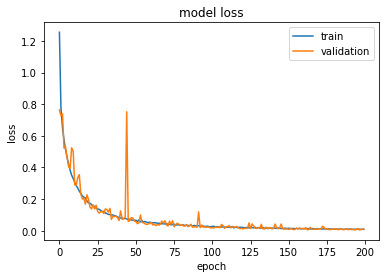

In [54]:
print(history_model_0.history.keys())

plt.plot(history_model_0.history['loss'])
plt.plot(history_model_0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
pred_model_fc0_yhot_val = model_fc0.predict(X_val_std)

In [20]:
np.argmax(pred_model_fc0_yhot_val.round(), axis=1)

array([ 2, 22, 51, ..., 21, 56,  7])

In [21]:
np.argmax(yhot_val, axis=1)[:30]

array([ 2, 22, 51,  4, 34, 57, 61, 50, 11, 29, 52, 49, 36,  0, 18, 44, 73,
       42, 35, 44,  4,  2,  6, 24,  6, 48,  8, 20, 10, 19])

In [22]:
pred_model_fc0_yhot_val_round = pred_model_fc0_yhot_val.round()
pred_yhot_val = np.argmax(pred_model_fc0_yhot_val_round, axis=1)
class_yhot_val = np.argmax(yhot_val, axis=1)

print("Accuracy = ", accuracy_score(class_yhot_val, pred_yhot_val))

Accuracy =  0.996097563585106


In [23]:
label_angls = np.arange(-74, 76, 2)

pred_y_val = np.zeros(pred_yhot_val.shape[0])
for idx, val in enumerate(list(pred_yhot_val)):
    pred_y_val[idx] = label_angls[val]
gt_y_val = np.zeros(class_yhot_val.shape[0])
for idx, val in enumerate(list(class_yhot_val)):
    gt_y_val[idx] = label_angls[val]

print(pred_y_val, gt_y_val)

[-70. -30.  28. ... -32.  38. -60.] [-70. -30.  28. ... -32.  38. -60.]


In [25]:
rmse_model_fc0 = mean_squared_error(gt_y_val, pred_y_val, squared=False)
print("RMSE of model_fc0: ", rmse_model_fc0)
print("I.E. %.04f degree of mean error" % (rmse_model_fc0))

mae_model_fc0 = mean_absolute_error(gt_y_val, pred_y_val)
print("Mean-Absolute-Error of model_fc0: ", mae_model_fc0)

RMSE of model_fc0:  1.2841110569881973
I.E. 1.2841 degree of mean error
Mean-Absolute-Error of model_fc0:  0.02660825048345811


In [82]:
# Eval function
import pickle

def eval_model(model, X_eval, yhot_gt, label_angls=np.arange(-74, 76, 2), IsSavingModel=None):
    pred_yhot_eval = model.predict(X_eval)
    # PDF => OneHot => angle(deg)
    pred_yhot_eval_round = pred_yhot_eval.round()
    pred_y_idx_eval = np.argmax(pred_yhot_eval_round, axis=1)
    
    pred_y_eval = np.zeros(pred_y_idx_eval.shape[0])
    for idx, val in enumerate(list(pred_y_idx_eval)):
        pred_y_eval[idx] = label_angls[val]
        
    # Process GT
    y_idx_gt = np.argmax(yhot_gt, axis=1)
    gt_y = np.zeros(y_idx_gt.shape[0])
    for idx, val in enumerate(list(y_idx_gt)):
        gt_y[idx] = label_angls[val]
    
    accuracy = accuracy_score(y_idx_gt, pred_y_idx_eval)
    RMSE = mean_squared_error(gt_y, pred_y_eval, squared=False)
    MedianAE = median_absolute_error(gt_y, pred_y_eval)
    MeanAE = mean_absolute_error(gt_y, pred_y_eval)
    
    # Save
    if IsSavingModel is not None:
        with open(join('checkpoints', IsSavingModel), 'wb') as a_file:
            pickle.dump(model, a_file)
            
    return accuracy, RMSE, MedianAE, MeanAE

In [27]:
eval_model(model_fc0, X_val_std, yhot_val, IsSavingModel=None)

(0.996097563585106, 1.2841110569881973, 0.0, 0.02660825048345811)

In [18]:
import pickle
with open(join('checkpoints', 'model_fc0.pkl'), 'rb') as a_file:
    model_fc0 = pickle.load(a_file)

### Multilabel Classification for Multihot Encoded y

In [15]:
def build_cnn1(output_dim=75):
    
    x = Input(shape=(4, 4, 8))
    c1 = Conv2D(512, kernel_size=(3, 3), padding='valid', strides=(1, 1), activation='relu')(x)
    c2 = MaxPooling2D(pool_size=(2, 2))(c1)
    c2 = Reshape((512,))(c2)
    h4 = Dense(1024, activation='relu')(c2)
    
    h5 = Dense(1024, activation='relu')(h4)
    
    h6 = Dense(512, activation='relu')(h5)
    r = Dense(output_dim, activation='sigmoid')(h6)  #'sigmoid' + Crossentropy
    
    return Model(inputs=x, outputs=r)

model_cnn1 = build_cnn1()
#optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-5)
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-7)
loss_obj = keras.losses.BinaryCrossentropy(from_logits=False)
#loss_obj = keras.losses.CategoricalCrossentropy(from_logits=False) #??from_logits=False

model_cnn1.compile(optimizer=optimizer, loss=loss_obj)
model_cnn1.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 512)         37376     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
______________________________

In [18]:
epochs = 10
batch_size = 512

history_model_cnn1 = model_cnn1.fit(I_train_std, yhot_train, batch_size=batch_size, epochs=epochs, \
                     verbose=1, validation_data=(I_val_std, yhot_val))

Train on 552425 samples, validate on 552425 samples
Epoch 1/10
552425/552425 [==============================] - 17s 31us/step - loss: 0.0246 - val_loss: 0.0262
Epoch 2/10
552425/552425 [==============================] - 17s 31us/step - loss: 0.0248 - val_loss: 0.0271
Epoch 3/10
552425/552425 [==============================] - 17s 31us/step - loss: 0.0247 - val_loss: 0.0264
Epoch 4/10
552425/552425 [==============================] - 18s 32us/step - loss: 0.0245 - val_loss: 0.0260
Epoch 5/10
552425/552425 [==============================] - 18s 33us/step - loss: 0.0242 - val_loss: 0.0267
Epoch 6/10
552425/552425 [==============================] - 18s 32us/step - loss: 0.0239 - val_loss: 0.0262
Epoch 7/10
552425/552425 [==============================] - 18s 32us/step - loss: 0.0237 - val_loss: 0.0257
Epoch 8/10
552425/552425 [==============================] - 17s 30us/step - loss: 0.0235 - val_loss: 0.0260
Epoch 9/10
552425/552425 [==============================] - 18s 33us/step - loss: 0.

dict_keys(['val_loss', 'loss'])


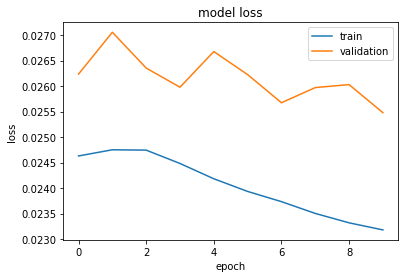

In [19]:
print(history_model_cnn1.history.keys())

plt.plot(history_model_cnn1.history['loss'])
plt.plot(history_model_cnn1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
pred_model_cnn1_yeval = model_cnn1.predict(I_test_std)
pred_model_cnn1_yeval_round = pred_model_cnn1_yeval.round()

Multilabel_accu = (pred_model_cnn1_yeval_round == yhot_test).all(axis=1).mean()
Multilabel_accu

0.4079206988809361

In [23]:
eval_model_multi(model_cnn1, I_val_std, yhot_val, y_val, IsSavingModel=None)

(0.4082273611802507, 29.75443842137907)

In [117]:
import pickle
IsSavingModel = True

if IsSavingModel:
    with open(join('checkpoints', 'model_cnn1.pkl'), 'wb') as a_file:
        pickle.dump(model_cnn1, a_file)
else:
    with open(join('checkpoints', 'model_cnn1.pkl'), 'rb') as a_file:
        model_cnn1 = pickle.load(a_file)

#### Up: cnn-fc; Down: 4fc

In [23]:
def build_fc1(feature_dim = 160, output_dim=75):
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(1024, activation='relu')(x)
    #h1 = Dropout(0.2)(h1)
    h2 = Dense(2048, activation='relu')(h1)
    #h2 = Dropout(0.2)(h2)
    h3 = Dense(1024, activation='relu')(h2) #'sigmoid'
    #h3 = Dropout(0.2)(h3)
    h4 = Dense(512, activation='relu')(h3)
    #h4 = Dropout(0.2)(h4)
    r = Dense(output_dim, activation='sigmoid')(h4)  #'sigmoid' + Crossentropy
    
    return Model(inputs=x, outputs=r)

model_fc1 = build_fc1(128, 75)
#optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-5)
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-7)
loss_obj = keras.losses.BinaryCrossentropy(from_logits=False)
#loss_obj = keras.losses.CategoricalCrossentropy(from_logits=False) #??from_logits=False

model_fc1.compile(optimizer=optimizer, loss=loss_obj)
model_fc1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 75)                38475     
Total params: 4,892,747
Trainable params: 4,892,747
Non-trainable params: 0
_________________________________________________

In [24]:
epochs = 50
batch_size = 512

history_model_fc1 = model_fc1.fit(X_train_std, yhot_train, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_val_std, yhot_val))

Train on 552425 samples, validate on 552425 samples
Epoch 1/50


InternalError: 2 root error(s) found.
  (0) Internal: Blas GEMM launch failed : a.shape=(512, 128), b.shape=(128, 1024), m=512, n=1024, k=128
	 [[{{node dense_5/MatMul}}]]
  (1) Internal: Blas GEMM launch failed : a.shape=(512, 128), b.shape=(128, 1024), m=512, n=1024, k=128
	 [[{{node dense_5/MatMul}}]]
	 [[Mean_1/_219]]
0 successful operations.
0 derived errors ignored.

dict_keys(['val_loss', 'loss'])


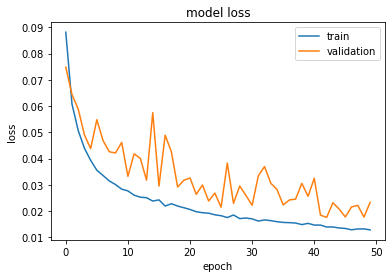

In [29]:
print(history_model_fc1.history.keys())

plt.plot(history_model_fc1.history['loss'])
plt.plot(history_model_fc1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
pred_model_fc1_yeval = model_fc1.predict(X_test_std)
pred_model_fc1_yeval_round = pred_model_fc1_yeval.round()

yhot_test

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
Multilabel_accu = (pred_model_fc1_yeval_round == yhot_test).all(axis=1).mean()
Multilabel_accu

0.5870649247033011

In [22]:
def eval_model_multi(model, X_eval, yhot_gt, y_gt, label_angls=np.arange(-74, 76, 2), IsSavingModel=None):
    pred_yhot_eval = model.predict(X_eval)
    
    pred_yhot_eval_round = pred_yhot_eval.round()
    
    # Compute abs Multilabel matching Accuracy
    Multilabel_accu = (pred_yhot_eval_round == yhot_gt).all(axis=1).mean()
    
    # Compute MSE
    pred_deg_eval = -360 * np.ones(y_gt.shape)
    for index, val in np.ndenumerate(pred_yhot_eval_round):
        if val==1:
            if pred_deg_eval[index[0], 0] != -360:
                pred_deg_eval[index[0], 1] = label_angls[index[1]]
            else:
                pred_deg_eval[index[0], 0] = label_angls[index[1]]
        
    for index, val in np.ndenumerate(pred_deg_eval):
        if val==-360:
            pred_deg_eval[index[0], 1] = pred_deg_eval[index[0], 0]
    
    RMSE_sum = np.linalg.norm(pred_deg_eval - y_gt, axis=1)
    RMSE = np.sum(RMSE_sum) / len(RMSE_sum)
    
    # Save
    if IsSavingModel is not None:
        with open(join('checkpoints', IsSavingModel), 'wb') as a_file:
            pickle.dump(model, a_file)
            
    return Multilabel_accu, RMSE

In [33]:
eval_model_multi(model_fc1, X_val_std, yhot_val, y_val, IsSavingModel=None)

(0.5880979193590612, 11.842763273842701)

In [23]:
import pickle
IsSavingModel = True

if IsSavingModel:
    with open(join('checkpoints', 'model_fc1.pkl'), 'wb') as a_file:
        pickle.dump(model_fc1, a_file)
else:
    with open(join('checkpoints', 'model_fc1.pkl'), 'rb') as a_file:
        model_fc1 = pickle.load(a_file)

## CLASSIFICATION + REGRESSION

In [100]:
def build_CR0(feature_dim = 128, num_classes=1, regress1=1, regress2=1, drop_rate=0.2):
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(512, activation='relu')(x)
    h1 = Dropout(drop_rate)(h1)
    h2 = Dense(1024, activation='relu')(h1)
    h2 = Dropout(drop_rate)(h2)
    h3 = Dense(512, activation='relu')(h2)
    h3 = Dropout(drop_rate)(h3)
    h4 = Dense(256, activation='relu')(h3)
    h4 = Dropout(drop_rate)(h4)
    
    # Num-of-signal Classifier
    c = Dense(num_classes, activation='sigmoid', name="class_out")(h4)
    
    # Regression of 1-signal
    r1 = Dense(regress1, activation='sigmoid', name="regress1_out")(h4)
    
    # Regression of 2-signal
    r2 = Dense(regress2, activation='sigmoid', name="regress2_out")(h4)
    
    model = Model(inputs=x, outputs=[c, r1, r2], name="deepaoanet0")
    
    return model


model_cr0 = build_CR0(128, drop_rate=0.1)

optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-5)
losses = {
    "class_out": keras.losses.BinaryCrossentropy(from_logits=False),
    "regress1_out": keras.losses.MeanSquaredError(),
    "regress2_out": keras.losses.MeanSquaredError(),
}
lossWeights = {"class_out": 0.1, "regress1_out": 1.0, "regress2_out": 1.0}
metrics = {"class_out": 'accuracy', "regress1_out": 'mse', "regress2_out": 'mse'}

model_cr0.compile(optimizer=optimizer, 
                  loss=losses, 
                  loss_weights=lossWeights,
                  metrics=metrics)
model_cr0.summary()

Model: "deepaoanet0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 512)          66048       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 512)          0           dense_9[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1024)         525312      dropout_9[0][0]                  
________________________________________________________________________________________

In [101]:
epochs = 30
batch_size = 512

history_model_CR0 = model_cr0.fit(x=X_train_std, y={"class_out": ym_train_std[:,0], "regress1_out": ym_train_std[:,1], "regress2_out": ym_train_std[:,2]}, 
                                  batch_size=batch_size, epochs=epochs,
                                  verbose=1, validation_data=(X_test_std, {"class_out": ym_test_std[:,0], "regress1_out": ym_test_std[:,1], "regress2_out": ym_test_std[:,2]}))

Train on 338371 samples, validate on 56393 samples
Epoch 1/30
338371/338371 [==============================] - 17s 51us/step - loss: 0.0036 - class_out_loss: 0.0023 - regress1_out_loss: 0.0017 - regress2_out_loss: 0.0017 - class_out_accuracy: 1.0000 - regress1_out_mse: 0.0017 - regress2_out_mse: 0.0017 - val_loss: 4.5445e-04 - val_class_out_loss: 5.5742e-05 - val_regress1_out_loss: 2.1756e-04 - val_regress2_out_loss: 2.3196e-04 - val_class_out_accuracy: 1.0000 - val_regress1_out_mse: 2.1724e-04 - val_regress2_out_mse: 2.3164e-04
Epoch 2/30
338371/338371 [==============================] - 17s 49us/step - loss: 5.1400e-04 - class_out_loss: 5.0061e-05 - regress1_out_loss: 2.5598e-04 - regress2_out_loss: 2.5300e-04 - class_out_accuracy: 1.0000 - regress1_out_mse: 2.5599e-04 - regress2_out_mse: 2.5301e-04 - val_loss: 2.6769e-04 - val_class_out_loss: 9.6112e-06 - val_regress1_out_loss: 1.3457e-04 - val_regress2_out_loss: 1.3265e-04 - val_class_out_accuracy: 1.0000 - val_regress1_out_mse: 1.3

dict_keys(['val_loss', 'val_class_out_loss', 'val_regress1_out_loss', 'val_regress2_out_loss', 'val_class_out_accuracy', 'val_regress1_out_mse', 'val_regress2_out_mse', 'loss', 'class_out_loss', 'regress1_out_loss', 'regress2_out_loss', 'class_out_accuracy', 'regress1_out_mse', 'regress2_out_mse'])


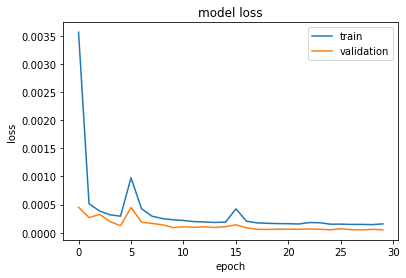

In [102]:
print(history_model_CR0.history.keys())

plt.plot(history_model_CR0.history['loss'])
plt.plot(history_model_CR0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [103]:
# Further Fine-Tune Training
lossWeights2 = {"class_out": 0.001, "regress1_out": 1., "regress2_out": 1.}
model_cr0.compile(optimizer=optimizer, 
                  loss=losses, 
                  loss_weights=lossWeights2,
                  metrics=metrics)

epochs = 10
batch_size = 512
history2_model_CR0 = model_cr0.fit(x=X_train_std, y={"class_out": ym_train_std[:,0], "regress1_out": ym_train_std[:,1], "regress2_out": ym_train_std[:,2]}, 
                                  batch_size=batch_size, epochs=epochs,
                                  verbose=1, validation_data=(X_test_std, {"class_out": ym_test_std[:,0], "regress1_out": ym_test_std[:,1], "regress2_out": ym_test_std[:,2]}))

Train on 338371 samples, validate on 56393 samples
Epoch 1/10
338371/338371 [==============================] - 17s 49us/step - loss: 3.1263e-04 - class_out_loss: 1.5657e-05 - regress1_out_loss: 1.5629e-04 - regress2_out_loss: 1.5630e-04 - class_out_accuracy: 1.0000 - regress1_out_mse: 1.5630e-04 - regress2_out_mse: 1.5631e-04 - val_loss: 8.3276e-05 - val_class_out_loss: 3.4156e-06 - val_regress1_out_loss: 4.1565e-05 - val_regress2_out_loss: 4.1572e-05 - val_class_out_accuracy: 1.0000 - val_regress1_out_mse: 4.1633e-05 - val_regress2_out_mse: 4.1640e-05
Epoch 2/10
338371/338371 [==============================] - 17s 50us/step - loss: 1.5813e-04 - class_out_loss: 1.3131e-05 - regress1_out_loss: 7.9062e-05 - regress2_out_loss: 7.9061e-05 - class_out_accuracy: 1.0000 - regress1_out_mse: 7.9061e-05 - regress2_out_mse: 7.9060e-05 - val_loss: 6.1668e-05 - val_class_out_loss: 3.4069e-06 - val_regress1_out_loss: 3.0769e-05 - val_regress2_out_loss: 3.0767e-05 - val_class_out_accuracy: 1.0000 - v

dict_keys(['val_loss', 'val_class_out_loss', 'val_regress1_out_loss', 'val_regress2_out_loss', 'val_class_out_accuracy', 'val_regress1_out_mse', 'val_regress2_out_mse', 'loss', 'class_out_loss', 'regress1_out_loss', 'regress2_out_loss', 'class_out_accuracy', 'regress1_out_mse', 'regress2_out_mse'])


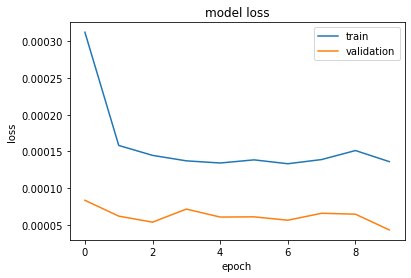

In [104]:
print(history2_model_CR0.history.keys())

plt.plot(history2_model_CR0.history['loss'])
plt.plot(history2_model_CR0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
pred_model_fcr0_yeval = model_cr0.predict(X_test_std)
pred_model_fcr0_yeval[0].shape

(266798, 1)

In [24]:
print(pred_model_fcr0_yeval[0][:10], ym_test_std[:10, 0])

[[8.3374858e-02]
 [9.9861562e-01]
 [9.9894869e-01]
 [9.9838769e-01]
 [9.9942851e-01]
 [9.9970698e-01]
 [4.3547153e-04]
 [1.0000000e+00]
 [2.5850028e-02]
 [9.7635949e-01]] [0. 1. 1. 1. 1. 1. 0. 1. 0. 1.]


In [25]:
ym_eval = ym_test_std[:, 1:3] * (ymax-ymin) + ymin
pred_ym_eval1 = pred_model_fcr0_yeval[1] * (ymax-ymin) + ymin
pred_ym_eval2 = pred_model_fcr0_yeval[2] * (ymax-ymin) + ymin

print(ym_eval[:10], np.concatenate((pred_ym_eval1, pred_ym_eval2), axis=1)[:10])

[[ 16.        16.      ]
 [ 24.       -22.      ]
 [-50.         4.      ]
 [-30.         8.000008]
 [-44.        10.      ]
 [ 64.       -12.      ]
 [-50.       -50.      ]
 [-62.        72.      ]
 [ 32.        32.      ]
 [ 48.        14.      ]] [[ 14.7365265  14.963661 ]
 [ 18.038437  -23.17493  ]
 [-49.30739     8.97551  ]
 [-26.472134    7.794731 ]
 [-42.13378     7.888771 ]
 [ 61.257324  -10.007648 ]
 [-41.180267  -36.91061  ]
 [-68.06524    73.5163   ]
 [ 27.45353    28.52008  ]
 [ 53.38275     7.8726654]]


In [23]:
### LOAD MODEL ###
model_cr0 = keras.models.load_model(join('checkpoints', 'model_cr02.h5'))
model_cr0.summary()

Model: "deepaoanet0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1024)         132096      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 1024)         0           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2048)         2099200     dropout_13[0][0]                 
________________________________________________________________________________________

In [105]:
#eval_model_CR(model_cr0, X_val_std, ym_val_std, IsSavingModel='model_cr02')
eval_model_CR(model_cr0, X_test_std, ym_test_std, IsSavingModel='model_cr06')
#eval_model_CR(model_cr0, X_test_std, ym_test_std, IsSavingModel=None)

(1.0,
 0.68498725,
 0.46719116,
 array([[56393,     0],
        [    0,     0]]))

In [34]:
eval_model_CR(model_cr0, X_val_std, ym_val_std, IsSavingModel=None)

(1.0,
 1.3891833701414882,
 0.745732426369075,
 array([[ 58725,      0],
        [     0, 102077]]))

#### (Eval SNR)

In [100]:
# SIGMA
eval_model_CR(model_cr0, X_train_std, ym_train_std)

(1.0,
 1.3510672,
 1.057423,
 array([[12394,     0],
        [    0,     0]]))

In [101]:
eval_model_CR(model_cr1, I_train_std, ym_train_std)

(1.0,
 1.3525268,
 1.0139219,
 array([[12394,     0],
        [    0,     0]]))

In [102]:
SNR_cr = np.array([[-10, -8, -6, -4, -2, 0, 10],
                   [0.99927, 0.97612, 0.99968, 1., 1., 1., 1.],
                   [8.551, 3.256, 1.651, 1.432, 1.369, 1.351, 1.349],
                   [10.913, 3.412, 1.123, 0.677, 0.569, 0.539, 0.526],
                   [0.80031, 0.96103, 0.99887, 0.99952, 0.99944, 0.99944, 0.99944],
                   [6.193, 1.624, 1.403, 1.372, 1.353, 1.353, 1.352],
                   [5.107, 1.188, 0.722, 0.668, 0.661, 0.661, 0.66]])

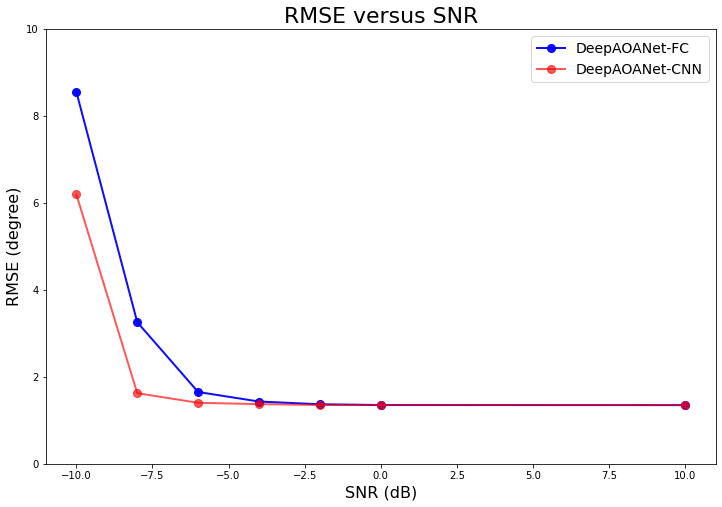

In [107]:
fig_snr ,ax_snr = plt.subplots(1, 1,figsize=(12,8))

ax_snr.plot(SNR_cr[0, :], SNR_cr[2, :], color='b', alpha=0.95, linewidth=2, marker='o',
            markersize=8, label='DeepAOANet-FC')
ax_snr.plot(SNR_cr[0, :], SNR_cr[5, :], color='red', alpha=0.65, linewidth=2, marker='o',
            markersize=8, label='DeepAOANet-CNN')
ax_snr.set_title(f"RMSE versus SNR", fontsize=22)
ax_snr.grid(False)
ax_snr.legend(loc='best', fontsize=14)
ax_snr.set_xlabel("SNR (dB)", fontsize=16)
ax_snr.set_ylabel("RMSE (degree)", fontsize=16)
ax_snr.set_xlim([-11, 11])
ax_snr.set_ylim([0, 10])
'''
ax_snr[-1].plot(SNR_cr[0, :], SNR_cr[3, :], color='b', alpha=0.95, linewidth=2, marker='o',
            markersize=8, linestyle='--', dashes=(5, 3), label='DeepAOANet-FC')
ax_snr[-1].plot(SNR_cr[0, :], SNR_cr[6, :], color='red', alpha=0.95, linewidth=2, marker='o',
            markersize=8, linestyle='--', dashes=(5, 3), label='DeepAOANet-CNN')
#ax_snr[-1].set_title(f"MAE versus SNR", fontsize=22)
ax_snr[-1].grid(False)
ax_snr[-1].legend(loc='best')
ax_snr[-1].set_xlabel("SNR (dB)", fontsize=16)
ax_snr[-1].set_ylabel("MAE (degree)", fontsize=16)
ax_snr[-1].set_xlim([-11, 11])
'''
fig_snr.savefig(join('doc', 'SNR4.png'), facecolor="w", bbox_inches='tight')

plt.show()

#### CNN-classifier-regressor

In [24]:
def build_CR1(feature_dim = (4, 4, 8), num_classes=1, regress1=1, regress2=1, drop_rate=0.2):
    
    x = Input(shape=feature_dim)
    c1 = Conv2D(512, kernel_size=(3, 3), padding='valid', strides=(1, 1), activation=None)(x)
    b1 = BatchNormalization()(c1)
    b2 = Activation("relu")(b1)
    c2 = MaxPooling2D(pool_size=(2, 2))(b2)
    c2 = Reshape((512,))(c2)
    h2 = Dense(1024, activation='relu')(c2)
    h2 = Dropout(drop_rate)(h2)
    h3 = Dense(512, activation='relu')(h2)
    h3 = Dropout(drop_rate)(h3)
    h4 = Dense(256, activation='relu')(h3)
    h4 = Dropout(drop_rate)(h4)
    
    # Num-of-signal Classifier
    c = Dense(num_classes, activation='sigmoid', name="class_out")(h4)
    
    # Regression of 1-signal
    r1 = Dense(regress1, activation='sigmoid', name="regress1_out")(h4)
    
    # Regression of 2-signal
    r2 = Dense(regress2, activation='sigmoid', name="regress2_out")(h4)
    
    model = Model(inputs=x, outputs=[c, r1, r2], name="deepaoanet1")
    
    return model


model_cr1 = build_CR1(drop_rate=0.1)

optimizer = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
losses = {
    "class_out": keras.losses.BinaryCrossentropy(from_logits=False),
    "regress1_out": keras.losses.MeanSquaredError(),
    "regress2_out": keras.losses.MeanSquaredError(),
}
lossWeights = {"class_out": 0.1, "regress1_out": 1., "regress2_out": 1.}
metrics = {"class_out": 'accuracy', "regress1_out": 'mse', "regress2_out": 'mse'}

model_cr1.compile(optimizer=optimizer, 
                  loss=losses, 
                  loss_weights=lossWeights,
                  metrics=metrics)
model_cr1.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "deepaoanet1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 4, 8)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 2, 512)    37376       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2, 2, 512)    2048        conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 2, 2, 512)    0           batch_normalization_1[0][0]

In [25]:
epochs = 30
batch_size = 512

history_model_CR1 = model_cr1.fit(x=I_train_std, y={"class_out": ym_train_std[:,0], "regress1_out": ym_train_std[:,1], "regress2_out": ym_train_std[:,2]}, 
                                  batch_size=batch_size, epochs=epochs,
                                  verbose=1, validation_data=(I_test_std, {"class_out": ym_test_std[:,0], "regress1_out": ym_test_std[:,1], "regress2_out": ym_test_std[:,2]}))


Train on 689109 samples, validate on 114846 samples
Epoch 1/30
689109/689109 [==============================] - 19s 28us/step - loss: 0.0389 - class_out_loss: 0.1930 - regress1_out_loss: 0.0028 - regress2_out_loss: 0.0168 - class_out_accuracy: 0.9086 - regress1_out_mse: 0.0028 - regress2_out_mse: 0.0168 - val_loss: 0.0215 - val_class_out_loss: 0.1253 - val_regress1_out_loss: 7.2463e-04 - val_regress2_out_loss: 0.0082 - val_class_out_accuracy: 0.9452 - val_regress1_out_mse: 7.2446e-04 - val_regress2_out_mse: 0.0082
Epoch 2/30
689109/689109 [==============================] - 18s 26us/step - loss: 0.0189 - class_out_loss: 0.0973 - regress1_out_loss: 0.0012 - regress2_out_loss: 0.0080 - class_out_accuracy: 0.9612 - regress1_out_mse: 0.0012 - regress2_out_mse: 0.0080 - val_loss: 0.0226 - val_class_out_loss: 0.1583 - val_regress1_out_loss: 6.3276e-04 - val_regress2_out_loss: 0.0061 - val_class_out_accuracy: 0.9543 - val_regress1_out_mse: 6.3271e-04 - val_regress2_out_mse: 0.0061
Epoch 3/30


Epoch 18/30
689109/689109 [==============================] - 19s 28us/step - loss: 0.0031 - class_out_loss: 0.0121 - regress1_out_loss: 3.9598e-04 - regress2_out_loss: 0.0015 - class_out_accuracy: 0.9959 - regress1_out_mse: 3.9597e-04 - regress2_out_mse: 0.0015 - val_loss: 0.0026 - val_class_out_loss: 0.0100 - val_regress1_out_loss: 1.9753e-04 - val_regress2_out_loss: 0.0014 - val_class_out_accuracy: 0.9968 - val_regress1_out_mse: 1.9760e-04 - val_regress2_out_mse: 0.0014
Epoch 19/30
689109/689109 [==============================] - 19s 28us/step - loss: 0.0033 - class_out_loss: 0.0136 - regress1_out_loss: 4.2261e-04 - regress2_out_loss: 0.0016 - class_out_accuracy: 0.9956 - regress1_out_mse: 4.2259e-04 - regress2_out_mse: 0.0016 - val_loss: 0.0017 - val_class_out_loss: 0.0056 - val_regress1_out_loss: 2.3428e-04 - val_regress2_out_loss: 8.6682e-04 - val_class_out_accuracy: 0.9982 - val_regress1_out_mse: 2.3422e-04 - val_regress2_out_mse: 8.6832e-04
Epoch 20/30
689109/689109 [===========

dict_keys(['val_loss', 'val_class_out_loss', 'val_regress1_out_loss', 'val_regress2_out_loss', 'val_class_out_accuracy', 'val_regress1_out_mse', 'val_regress2_out_mse', 'loss', 'class_out_loss', 'regress1_out_loss', 'regress2_out_loss', 'class_out_accuracy', 'regress1_out_mse', 'regress2_out_mse'])


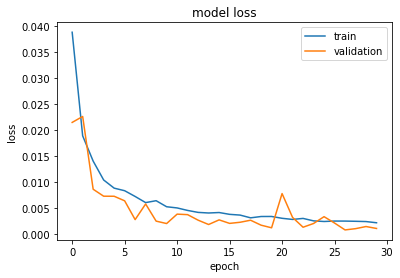

In [26]:
print(history_model_CR1.history.keys())

plt.plot(history_model_CR1.history['loss'])
plt.plot(history_model_CR1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
# Further Fine-Tune Training
lossWeights2 = {"class_out": 0.01, "regress1_out": 1., "regress2_out": 1.}
model_cr1.compile(optimizer=optimizer, 
                  loss=losses, 
                  loss_weights=lossWeights2,
                  metrics=metrics)

epochs = 10
batch_size = 512
history2_model_CR1 = model_cr1.fit(x=I_train_std, y={"class_out": ym_train_std[:,0], "regress1_out": ym_train_std[:,1], "regress2_out": ym_train_std[:,2]}, 
                                  batch_size=batch_size, epochs=epochs,
                                  verbose=1, validation_data=(I_test_std, {"class_out": ym_test_std[:,0], "regress1_out": ym_test_std[:,1], "regress2_out": ym_test_std[:,2]}))

Train on 689109 samples, validate on 114846 samples
Epoch 1/10
689109/689109 [==============================] - 20s 28us/step - loss: 0.0020 - class_out_loss: 0.0123 - regress1_out_loss: 4.0007e-04 - regress2_out_loss: 0.0015 - class_out_accuracy: 0.9960 - regress1_out_mse: 4.0007e-04 - regress2_out_mse: 0.0015 - val_loss: 5.8040e-04 - val_class_out_loss: 0.0019 - val_regress1_out_loss: 1.1516e-04 - val_regress2_out_loss: 4.4512e-04 - val_class_out_accuracy: 0.9993 - val_regress1_out_mse: 1.1513e-04 - val_regress2_out_mse: 4.4572e-04
Epoch 2/10
689109/689109 [==============================] - 19s 28us/step - loss: 0.0014 - class_out_loss: 0.0073 - regress1_out_loss: 3.2656e-04 - regress2_out_loss: 0.0010 - class_out_accuracy: 0.9977 - regress1_out_mse: 3.2656e-04 - regress2_out_mse: 0.0010 - val_loss: 6.5793e-04 - val_class_out_loss: 0.0037 - val_regress1_out_loss: 1.3517e-04 - val_regress2_out_loss: 4.8516e-04 - val_class_out_accuracy: 0.9987 - val_regress1_out_mse: 1.3506e-04 - val_r

dict_keys(['val_loss', 'val_class_out_loss', 'val_regress1_out_loss', 'val_regress2_out_loss', 'val_class_out_accuracy', 'val_regress1_out_mse', 'val_regress2_out_mse', 'loss', 'class_out_loss', 'regress1_out_loss', 'regress2_out_loss', 'class_out_accuracy', 'regress1_out_mse', 'regress2_out_mse'])


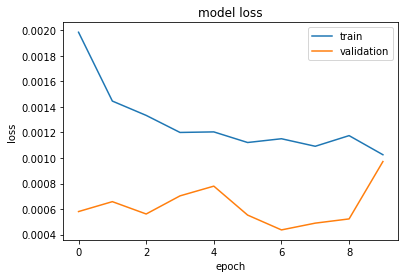

In [28]:
print(history2_model_CR1.history.keys())

plt.plot(history2_model_CR1.history['loss'])
plt.plot(history2_model_CR1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
pred_model_fcr1_yeval = model_cr1.predict(I_val_std)

In [17]:
print(pred_model_fcr1_yeval[0][:10, 0], ym_val_std[:10, 0])

[9.9999952e-01 9.9999809e-01 9.9999988e-01 1.0000000e+00 3.0681491e-04
 9.6244568e-01 9.9994695e-01 9.9999160e-01 0.0000000e+00 9.9994802e-01] [1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]


In [18]:
ym_eval = ym_val_std[:, 1:3] * (ymax-ymin) + ymin
pred_ym_eval1 = pred_model_fcr1_yeval[1] * (ymax-ymin) + ymin
pred_ym_eval2 = pred_model_fcr1_yeval[2] * (ymax-ymin) + ymin

print(ym_eval[:10], np.concatenate((pred_ym_eval1, pred_ym_eval2), axis=1)[:10])

[[-30.  34.]
 [-16. -38.]
 [-60.  16.]
 [ 10.  72.]
 [ 28.  28.]
 [  6. -28.]
 [ 58. -32.]
 [ 20.   6.]
 [-68. -68.]
 [-12.  72.]] [[-29.675133  23.29634 ]
 [-16.045937 -38.569008]
 [-59.239326  16.72499 ]
 [  8.544258  73.374466]
 [ 28.908066  29.024475]
 [  7.100136 -31.939335]
 [ 61.003265 -31.082176]
 [ 22.314743   4.469818]
 [-64.18303  -65.67009 ]
 [-12.438572  58.178253]]


In [29]:
def eval_model_CR(model, X_eval, y_gt, ymax=74, ymin=-74, IsSavingModel=None):
    pred_y = model.predict(X_eval)
    y = np.asarray(pred_y)  # Shape (3, batch, 1)
    
    pred_y_class = pred_y[0][:, 0].round()
    
    # Compute abs Multilabel matching Accuracy
    Multilabel_accu = (pred_y_class == y_gt[:, 0]).mean()
    
    # confusion_matrix
    c_mtx = confusion_matrix(y_gt[:, 0], pred_y_class, labels=[0, 1])
    
    y_angle = y_gt[:, 1:3] * (ymax-ymin) + ymin
    pred_y_angle1 = pred_y[1][:, 0] * (ymax-ymin) + ymin
    pred_y_angle2 = pred_y[2][:, 0] * (ymax-ymin) + ymin
    
    sum_RMSE, sum_MAE = 0., 0.
    # Compute RMSE, MAE
    for idx, val in np.ndenumerate(pred_y_angle1):
        if y_gt[idx, 0] == 0:
            sum_RMSE += (y_angle[idx, 0] - (val + pred_y_angle2[idx])/2)**2
            #sum_RMSE += (y_angle[idx, 0] - val)**2
            sum_MAE += abs(y_angle[idx, 0] - (val + pred_y_angle2[idx])/2)
            
        elif y_gt[idx, 0] == 1:
            # Average Two-source Errors or Not?
            #sum_RMSE += ((abs(y_angle[idx, 0] - val) + abs(y_angle[idx, 1] - pred_y_angle2[idx]))/2)**2
            sum_RMSE += (y_angle[idx, 0] - val)**2 + (y_angle[idx, 1] - pred_y_angle2[idx])**2  # Euclidean
            sum_MAE += (abs(y_angle[idx, 0] - val) + abs(y_angle[idx, 1] - pred_y_angle2[idx]))/2
    
    
    RMSE = np.sqrt(sum_RMSE / y_gt.shape[0])
    MAE = sum_MAE / y_gt.shape[0]
    
    # Save
    if IsSavingModel is not None:
        with open(join('checkpoints', IsSavingModel + '.pkl'), 'wb') as a_file:
            pickle.dump(model, a_file)
            
        # Save as .h5
        model.save(join('checkpoints', IsSavingModel + '.h5'))
    
    return Multilabel_accu, RMSE[0], MAE[0], c_mtx

In [30]:
### LOAD MODEL ###
model_cr1 = keras.models.load_model(join('checkpoints', 'model_cr11.h5'))
model_cr1.summary()


Model: "deepaoanet1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 4, 8)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 2, 512)    37376       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2, 2, 512)    2048        conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 2, 2, 512)    0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [30]:
eval_model_CR(model_cr1, I_test_std, ym_test_std, IsSavingModel='model_cr16')
#eval_model_CR(model_cr1, I_test_std, ym_test_std, IsSavingModel=None)

(0.9975619525277328,
 4.309660552362509,
 1.7254363996133952,
 array([[56711,     0],
        [  280, 57855]]))

In [25]:
eval_model_CR(model_cr1, I_val_std, ym_val_std)

(0.9985265195878661,
 4.106523517332975,
 1.9943381453972706,
 array([[287828,      0],
        [  1204, 528081]]))

### Benchmark Comparison
#### SVR

In [81]:
samples_svr = 20000

In [82]:
# SVR
#svr_128_1 = SVR(kernel='rbf',gamma='scale', C=0.05, epsilon=0.1)
svr_128_1 = SVR(kernel='poly',gamma='scale', C=5., epsilon=0.01)
#svr_128_1 = LinearSVR(C=1e-1, epsilon=0.1)

svr_128_1.fit(X_train_std[:samples_svr], ym_train_std[:samples_svr, 1])
svr_128_1.score(X_test_std, ym_test_std[:,1])

0.9062905196423129

In [39]:
svr_128_1.score(X_val_std, ym_val_std[:,1])

0.5348672951584421

In [73]:
# If search for optimal hyperparameters
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_128_1,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(X_train_std[:samples_svr], ym_train_std[:samples_svr, 1])
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
SVR(C=5, kernel='poly')
0.7423994745661167


In [86]:
IsLoadingSVR = True

if IsLoadingSVR:
    with open(join('checkpoints', 'svr_128_1.pkl'), 'rb') as a_file:
        svr_128_1 = pickle.load(a_file)
else:
    with open(join('checkpoints', 'svr_128_1.pkl'), 'wb') as a_file:
        pickle.dump(svr_128_1, a_file)

In [87]:
pred_svr_128_1 = svr_128_1.predict(X_test_std) * (ymax-ymin) + ymin
rmse_svr_128_1 = np.sqrt(mean_squared_error(ym_test_std[:,1] * (ymax-ymin) + ymin, pred_svr_128_1))
print("RMSE [deg] for SVR:", rmse_svr_128_1)

RMSE [deg] for SVR: 12.831504564600152


In [84]:
# Get SVR prediction error
error_svr_128_1 = pd.Series(abs(pred_svr_128_1 - (ym_test_std[:,1] * (ymax-ymin) + ymin)))

In [85]:
# Scatter distribution of Errors
scat_svr = np.stack([pred_svr_128_1, ym_test_std[:,1] * (ymax-ymin) + ymin], axis=-1)
scat_svr.shape

(90438, 2)

#### MUSIC

In [28]:
from pyargus import directionEstimation as de

In [63]:
X_test.shape

(90438, 32)

In [67]:
X_test_square = X_test.reshape((X_test.shape[0], 4, 4, 2))
X_test_real = X_test_square[:, :, :, 0]
X_test_imag = X_test_square[:, :, :, 1]
X_test_complex = X_test_real + 1j*X_test_imag

In [69]:
X_test_complex.shape

(90438, 4, 4)

In [31]:
DOA_theta = np.linspace(-90,90,181)
M = 4
DOA_inter_elem_space = 0.2

x = np.zeros(M)
y = np.arange(M) * DOA_inter_elem_space
scanning_vectors = de.gen_scanning_vectors(M, x, y, DOA_theta)

In [80]:
pred_music = []

for i in range(X_test_complex.shape[0]):
    R = X_test_complex[i]
    DOA_MUSIC_res = de.DOA_MUSIC(R, scanning_vectors, signal_dimension = 1)
    
    music_angle1 = DOA_theta[DOA_MUSIC_res.real.argmax()]
    pred_music.append(music_angle1)
    
print(len(pred_music))

90438


In [81]:
# Get SVR prediction error
err_music = pd.Series(abs(np.asarray(pred_music) - ym_test_std[:, 1] / math.pi*180))

#### DeepAOANet

In [4]:
with open(join('checkpoints', 'model_cr1.pkl'), 'rb') as a_file:
    model_cr1 = pickle.load(a_file)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [8]:
# Save model to .h5
model_cr1.save(join('checkpoints', "model_cr1.h5"))

model_show = keras.models.load_model(join('checkpoints', "model_cr1.h5"))
model_show.summary()

Model: "deepaoanet1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4, 4, 8)      0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 2, 512)    37376       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2, 2, 512)    2048        conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 2, 2, 512)    0           batch_normalization_2[0][0]      
________________________________________________________________________________________

In [32]:
pred_cr1 = model_cr1.predict(I_test_std)
pred_cr1_angle1 = pred_cr1[1][:, 0] * (ymax-ymin) + ymin
pred_cr1_angle1.shape

(272399,)

In [33]:
error_cr1 = pd.Series(abs(pred_cr1_angle1 - (ym_test_std[:, 1] * (ymax-ymin) + ymin)))
error_cr1.shape

(272399,)

In [10]:
with open(join('checkpoints', 'model_cr0.pkl'), 'rb') as a_file:
    model_cr0 = pickle.load(a_file)
    #model_cr0.summary()

In [11]:
# Save model to .h5
model_cr0.save(join('checkpoints', "model_cr0.h5"))

model_show = keras.models.load_model(join('checkpoints', "model_cr0.h5"))
model_show.summary()

Model: "deepaoanet0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         132096      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         2099200     dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         2098176     dense_2[0][0]                    
________________________________________________________________________________________

In [34]:
pred_cr0 = model_cr0.predict(X_test_std)
pred_cr0_angle1 = pred_cr0[1][:, 0] * (ymax-ymin) + ymin
print(pred_cr0_angle1.shape)

(272399,)


In [35]:
error_cr0 = pd.Series(abs(pred_cr0_angle1 - (ym_test_std[:, 1] * (ymax-ymin) + ymin)))
error_cr0.shape

(272399,)

In [36]:
scat_cr0 = np.stack([pred_cr0_angle1, ym_test_std[:, 1] * (ymax-ymin) + ymin], axis=-1)
scat_cr0.shape

(272399, 2)

In [37]:
scat_cr1 = np.stack([pred_cr1_angle1, ym_test_std[:, 1] * (ymax-ymin) + ymin], axis=-1)
scat_cr1.shape

(272399, 2)

#### (confusion matrix)

In [32]:
# CMTX of CR0
confusion_matrix(ym_test_std[:, 0], pred_cr0[0][:, 0].round(), labels=[0, 1])

array([[ 90473,      4],
       [    88, 176233]])

In [20]:
# CMTX of CR1
confusion_matrix(ym_test_std[:, 0], pred_cr1[0][:, 0].round(), labels=[0, 1])

array([[ 90474,      3],
       [   125, 176196]])

In [38]:
IsLoadingPlotMatrix = True

if IsLoadingPlotMatrix:
    with open(join('checkpoints', 'Errors.pkl'), 'rb') as a_file:
        [_, _, err_svr_128_1, err_music] = pickle.load(a_file)
else:
    with open(join('checkpoints', 'Errors.pkl'), 'wb') as a_file:
        Errors = [error_cr0, error_cr1, error_svr_128_1, err_music]
        pickle.dump(Errors, a_file)

In [43]:
num_err_samples = len(err_svr_128_1)

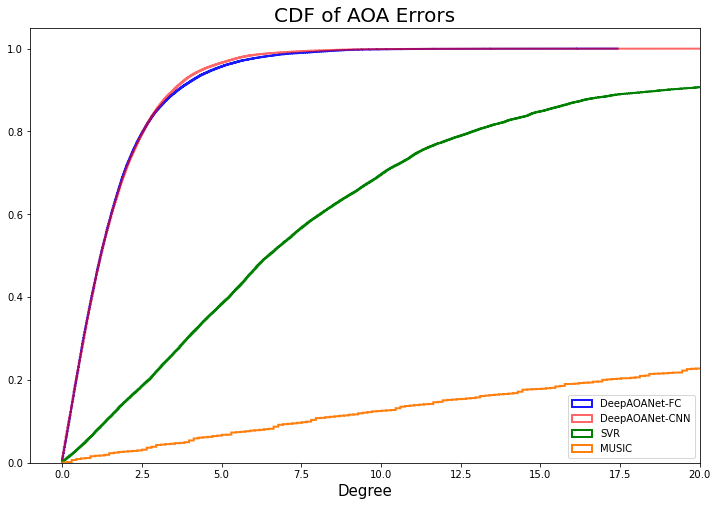

In [50]:
%matplotlib inline
fig_hist, ax_hist = plt.subplots(1, 1, figsize=(12,8))
'''
n, bins, patches = ax_hist.hist(y_err_lstm_ae_svr_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='LSTM-AE + SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
'''
n3, bins3, patches3 = ax_hist.hist(error_cr0[:num_err_samples], density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='b', alpha=0.9, linewidth=2, label='DeepAOANet-FC')
patches3[0].set_xy(patches3[0].get_xy()[:-1])
n2, bins2, patches2 = ax_hist.hist(error_cr1[:num_err_samples], density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='red', alpha=0.6, linewidth=2, label='DeepAOANet-CNN')
patches2[0].set_xy(patches2[0].get_xy()[:-1])
n, bins, patches = ax_hist.hist(err_svr_128_1, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='g', linewidth=2, label='SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
n4, bins4, patches4 = ax_hist.hist(err_music, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='tab:orange', linewidth=2, label='MUSIC')
patches4[0].set_xy(patches4[0].get_xy()[:-1])

ax_hist.set_title("CDF of AOA Errors", fontsize=20)
ax_hist.set_xlabel("Degree", fontsize=15)
ax_hist.set_xlim(-1, 20)
ax_hist.legend(loc='lower right')

fig_hist.savefig(join('doc', 'CDF_Xx-ym4.png'), facecolor="w", bbox_inches='tight')
plt.show()

#### (Scatter Error Plot)

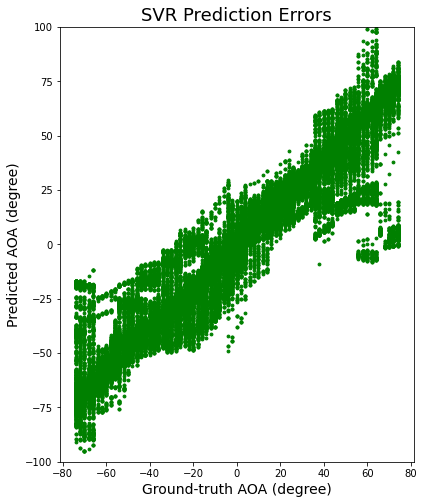

In [94]:
# SVR
fig_scat, ax_scat = plt.subplots(1, 1, figsize=(12,8))

ax_scat.set_aspect('equal')
ax_scat.set_title("SVR Prediction Errors", fontsize=18)
ax_scat.set_xlabel("Ground-truth AOA (degree)", fontsize=14)
ax_scat.set_ylabel("Predicted AOA (degree)", fontsize=14)
ax_scat.set_ylim(-100, 100)
ax_scat.scatter(scat_svr[:,1], scat_svr[:,0], s=8, c='g')

fig_scat.savefig(join('doc', 'Scatter_svr_test2.png'), facecolor="w", bbox_inches='tight')
plt.show()

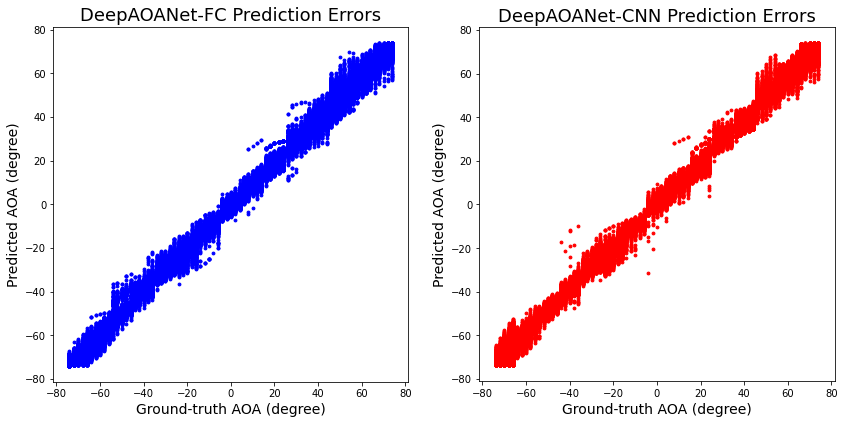

In [51]:
fig_scat, ax_scat = plt.subplots(1, 2, figsize=(14,7))

ax_scat[0].set_aspect('equal')
ax_scat[0].set_title("DeepAOANet-FC Prediction Errors", fontsize=18)
ax_scat[0].set_xlabel("Ground-truth AOA (degree)", fontsize=14)
ax_scat[0].set_ylabel("Predicted AOA (degree)", fontsize=14)
ax_scat[0].scatter(scat_cr0[:,1], scat_cr0[:,0], s=8, c='b')

ax_scat[-1].set_aspect('equal')
ax_scat[-1].set_title("DeepAOANet-CNN Prediction Errors", fontsize=18)
ax_scat[-1].set_xlabel("Ground-truth AOA (degree)", fontsize=14)
ax_scat[-1].set_ylabel("Predicted AOA (degree)", fontsize=14)
ax_scat[-1].scatter(scat_cr1[:,1], scat_cr1[:,0], s=8, c='r')

fig_scat.savefig(join('doc', 'Scatter_test.png'), facecolor="w", bbox_inches='tight')
plt.show()

In [52]:
cr0_large_angl = scat_cr0[abs(scat_cr0[:,0]) >= 37, :]
cr0_small_angl = scat_cr0[abs(scat_cr0[:,0]) < 37, :]

error_cr0_large = cr0_large_angl[:, 1] - cr0_large_angl[:, 0]
error_cr0_small = cr0_small_angl[:, 1] - cr0_small_angl[:, 0]

In [53]:
print(np.std(error_cr0_large), np.std(error_cr0_small))

2.4539986 2.101271


In [54]:
cr1_large_angl = scat_cr1[abs(scat_cr1[:,0]) >= 37, :]
cr1_small_angl = scat_cr1[abs(scat_cr1[:,0]) < 37, :]

error_cr1_large = cr1_large_angl[:, 1] - cr1_large_angl[:, 0]
error_cr1_small = cr1_small_angl[:, 1] - cr1_small_angl[:, 0]

print(np.std(error_cr1_large), np.std(error_cr1_small))

2.3691273 1.9537215


### Multiple output regression

In [130]:
def build_regress1(feature_dim = 160, output_dim=4):
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(512, activation='relu')(x)
    h2 = Dense(1024, activation='relu')(h1)
    h3 = Dense(512, activation='relu')(h2)
    h4 = Dense(256, activation='relu')(h3)
    r = Dense(output_dim, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_regress1 = build_regress1()
optimizer = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-7)
loss_obj = keras.losses.MeanSquaredError()

model_regress1.compile(optimizer=optimizer, loss=loss_obj)
model_regress1.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 160)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               82432     
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_35 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 1028      
Total params: 1,264,900
Trainable params: 1,264,900
Non-trainable params: 0
________________________________________________

In [131]:
epochs = 100
batch_size = 512

history_regress1 = model_regress1.fit(X_train_std, yprob_train, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, yprob_test))

Train on 143050 samples, validate on 71525 samples
Epoch 1/100
143050/143050 [==============================] - 5s 38us/step - loss: 0.0064 - val_loss: 8.4658e-04
Epoch 2/100
143050/143050 [==============================] - 5s 37us/step - loss: 5.8257e-04 - val_loss: 4.2534e-04
Epoch 3/100
143050/143050 [==============================] - 5s 38us/step - loss: 3.4093e-04 - val_loss: 2.8140e-04
Epoch 4/100
143050/143050 [==============================] - 6s 39us/step - loss: 2.4489e-04 - val_loss: 2.1534e-04
Epoch 5/100
143050/143050 [==============================] - 6s 39us/step - loss: 1.9801e-04 - val_loss: 1.7597e-04
Epoch 6/100
143050/143050 [==============================] - 6s 39us/step - loss: 1.6279e-04 - val_loss: 1.6265e-04
Epoch 7/100
143050/143050 [==============================] - 6s 40us/step - loss: 1.4487e-04 - val_loss: 1.3535e-04
Epoch 8/100
143050/143050 [==============================] - 6s 40us/step - loss: 1.3020e-04 - val_loss: 1.2388e-04
Epoch 9/100
143050/143050

dict_keys(['val_loss', 'loss'])


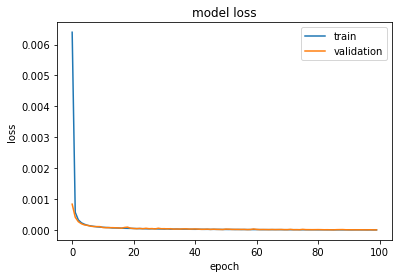

In [132]:
print(history_regress1.history.keys())

plt.plot(history_regress1.history['loss'])
plt.plot(history_regress1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [134]:
pred_model_regress1_ytest = model_regress1.predict(X_test_std)
pred_model_regress1_ytest[:20]

array([[0.03322592, 0.9999795 , 0.87822825, 0.9999794 ],
       [0.05780786, 0.99997973, 0.73621607, 0.9999852 ],
       [0.53611904, 0.9999593 , 0.9729247 , 0.99997306],
       [0.9100331 , 0.9999909 , 0.98170096, 0.9999858 ],
       [0.19686458, 0.99992716, 0.37305194, 0.99994695],
       [0.17635918, 0.9999678 , 0.21701816, 0.99995685],
       [0.4696398 , 0.99991256, 0.7874271 , 0.9999293 ],
       [0.20840326, 0.9999994 , 0.80153716, 0.9999995 ],
       [0.3125418 , 0.9999261 , 0.76013786, 0.99993837],
       [0.55112624, 0.9998855 , 0.8060544 , 0.9998827 ],
       [0.5189773 , 0.9998205 , 0.6105699 , 0.9998299 ],
       [0.01775786, 0.99999577, 0.53610325, 0.9999959 ],
       [0.05753484, 0.9999391 , 0.58793664, 0.9999596 ],
       [0.6344114 , 0.99998844, 0.9818166 , 0.99998975],
       [0.63030005, 0.99992675, 0.65007496, 0.9999369 ],
       [0.08778131, 0.9999858 , 0.43770486, 0.99998814],
       [0.08497617, 0.9999918 , 0.6297493 , 0.9999912 ],
       [0.19688699, 0.9999925 ,

In [147]:
y_test[:20]

array([[-64.,  56.],
       [-66.,  34.],
       [  6.,  70.],
       [ 58.,  72.],
       [-44., -18.],
       [-48., -42.],
       [ -4.,  42.],
       [-44.,  44.],
       [-28.,  38.],
       [  8.,  46.],
       [  4.,  16.],
       [-72.,   6.],
       [-64.,  14.],
       [ 20.,  72.],
       [ 20.,  22.],
       [-62., -10.],
       [-60.,  20.],
       [-44.,  58.],
       [  0.,  42.],
       [-48.,  34.]], dtype=float32)

In [162]:
# Apply threshold upon Prob to decide num_of_signals
def eval_model_regress(model, X_eval, y_gt, ymin=-74, ymax=74, IsSavingModel=None):
    pred_yprob_eval = model.predict(X_eval)
    
    pred_y_eval_round = pred_yprob_eval[:, np.arange(1,5,2)].round()
    
    # Compute abs Multilabel matching Accuracy
    Multilabel_accu = (pred_y_eval_round == y_gt[:, np.arange(1,5,2)]).all(axis=1).mean()
    
    # Compute MSE
    pred_deg_eval = pred_yprob_eval[:, np.arange(0,4,2)] * (ymax-ymin) + ymin
    y_gt_deg = y_gt[:, np.arange(0,4,2)] * (ymax-ymin) + ymin
    pred_deg_eval = np.sort(pred_deg_eval, axis=1)
    # Dicuss 2signals or 1signal!
    mse_sum, mae_sum = 0, 0
    for row in range(y_gt.shape[0]):
        if np.equal(y_gt[row, np.arange(1,5,2)], pred_y_eval_round[row]).all():
            mse_sum += (y_gt_deg[row, 0] - pred_deg_eval[row, 0])**2 + (y_gt_deg[row, 1] - pred_deg_eval[row, 1])**2
            mae_sum += abs(y_gt_deg[row, 0] - pred_deg_eval[row, 0]) + abs(y_gt_deg[row, 1] - pred_deg_eval[row, 1])
    
    RMSE = np.sqrt(mse_sum / y_gt.shape[0])
    MAE = mae_sum / y_gt.shape[0]
    
    # Save
    if IsSavingModel is not None:
        with open(join('checkpoints', IsSavingModel), 'wb') as a_file:
            pickle.dump(model, a_file)
            
    return Multilabel_accu, RMSE, MAE

In [163]:
eval_model_regress(model_regress1, X_test_std, yprob_test)

(1.0, 1.22978949436613, 1.2676561314390489)

In [164]:
eval_model_regress(model_regress1, X_val_std, yprob_val)

(1.0, 1.2387258789240672, 1.2691817317830645)

## Failed Regress/Classifier
### (1) Window Method

In [52]:
def build_lstm1(feature_dim = 20):
    time_steps = 3
    

    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(512, activation='relu')(x)
    r = Dense(1, activation='sigmoid')(h1)
    
    return Model(inputs=x, outputs=r)

In [56]:
model_1 = build_lstm1(20)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
model_1.compile(optimizer=optimizer, loss='mse')
model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1091584   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 1,092,097
Trainable params: 1,092,097
Non-trainable params: 0
_________________________________________________________________


In [57]:
X_train.shape

(100042, 3, 20)

In [58]:
epochs = 200
batch_size = 512

history = model_1.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test, y_test_std))

Train on 100042 samples, validate on 50022 samples
Epoch 1/200
100042/100042 [==============================] - 4s 40us/step - loss: 0.0193 - val_loss: 0.0044
Epoch 2/200
100042/100042 [==============================] - 4s 38us/step - loss: 0.0033 - val_loss: 0.0022
Epoch 3/200
100042/100042 [==============================] - 4s 38us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/200
100042/100042 [==============================] - 4s 39us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/200
100042/100042 [==============================] - 4s 39us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/200
100042/100042 [==============================] - 4s 39us/step - loss: 9.1631e-04 - val_loss: 8.0427e-04
Epoch 7/200
100042/100042 [==============================] - 4s 38us/step - loss: 8.8723e-04 - val_loss: 6.4473e-04
Epoch 8/200
100042/100042 [==============================] - 4s 38us/step - loss: 6.3362e-04 - val_loss: 6.2046e-04
Epoch 9/200
100042/100042 [==============================] - 

100042/100042 [==============================] - 4s 39us/step - loss: 1.1128e-04 - val_loss: 7.8987e-05
Epoch 72/200
100042/100042 [==============================] - 4s 39us/step - loss: 1.1050e-04 - val_loss: 8.2972e-05
Epoch 73/200
100042/100042 [==============================] - 4s 39us/step - loss: 1.4225e-04 - val_loss: 1.7384e-04
Epoch 74/200
100042/100042 [==============================] - 4s 39us/step - loss: 1.1134e-04 - val_loss: 1.3461e-04
Epoch 75/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.0367e-04 - val_loss: 7.9106e-05
Epoch 76/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.2824e-04 - val_loss: 1.0074e-04
Epoch 77/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.0745e-04 - val_loss: 7.9840e-05
Epoch 78/200
100042/100042 [==============================] - 4s 39us/step - loss: 8.3485e-05 - val_loss: 7.9019e-05
Epoch 79/200
100042/100042 [==============================] - 4s 39us/step - 

Epoch 141/200
100042/100042 [==============================] - 4s 40us/step - loss: 5.4588e-05 - val_loss: 5.4560e-05
Epoch 142/200
100042/100042 [==============================] - 4s 39us/step - loss: 4.9441e-05 - val_loss: 6.0543e-05
Epoch 143/200
100042/100042 [==============================] - 4s 39us/step - loss: 5.1473e-05 - val_loss: 8.9513e-05
Epoch 144/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.0227e-04 - val_loss: 7.5739e-04
Epoch 145/200
100042/100042 [==============================] - 4s 38us/step - loss: 8.1363e-05 - val_loss: 5.2866e-05
Epoch 146/200
100042/100042 [==============================] - 4s 39us/step - loss: 5.6641e-05 - val_loss: 5.4288e-05
Epoch 147/200
100042/100042 [==============================] - 4s 37us/step - loss: 5.2452e-05 - val_loss: 6.0337e-05
Epoch 148/200
100042/100042 [==============================] - 4s 39us/step - loss: 5.8755e-05 - val_loss: 5.7662e-05
Epoch 149/200
100042/100042 [===========================

In [59]:
pred_model_1_y_test_std = model_1.predict(X_val)
pred_model_1_y_test = pred_model_1_y_test_std*(ymax-ymin) + ymin

rmse_model_1 = np.sqrt(mean_squared_error(y_val, pred_model_1_y_test))
print("RMSE of model_1: ", rmse_model_1)
print("I.E. %.04f degree of mean error" % (rmse_model_1/math.pi*180))

RMSE of model_1:  0.01908025600644741
I.E. 1.0932 degree of mean error


In [60]:
import pickle

with open(join('checkpoints', '1-LSTM_X_105.pkl'), 'wb') as a_file:
    pickle.dump(model_1, a_file)

In [ ]:
with open(join('checkpoints', '1-LSTM_X_105.pkl'), 'rb') as a_file:
    model_1 = pickle.load(a_file)

### (2) Bidirectional LSTM

In [168]:
def build_lstm2(feature_dim = 20):
    time_steps = 3
    
    x = Input(shape=(time_steps, feature_dim))
    h1 = Bidirectional(LSTM(512, activation='relu'))(x)
    r = Dense(1, activation='sigmoid')(h1)
    
    return Model(inputs=x, outputs=r)

In [169]:
model_2 = build_lstm2()
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
model_2.compile(optimizer=optimizer, loss='mse')
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              2183168   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 2,184,193
Trainable params: 2,184,193
Non-trainable params: 0
_________________________________________________________________


In [170]:
epochs = 200
batch_size = 512

history = model_2.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test, y_test_std))


Train on 100042 samples, validate on 50022 samples
Epoch 1/200
100042/100042 [==============================] - 7s 67us/step - loss: 0.0176 - val_loss: 0.0057
Epoch 2/200
100042/100042 [==============================] - 6s 63us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/200
100042/100042 [==============================] - 6s 61us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/200
100042/100042 [==============================] - 6s 60us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/200
100042/100042 [==============================] - 6s 61us/step - loss: 8.7010e-04 - val_loss: 7.8846e-04
Epoch 6/200
100042/100042 [==============================] - 6s 61us/step - loss: 8.7040e-04 - val_loss: 6.9716e-04
Epoch 7/200
100042/100042 [==============================] - 6s 61us/step - loss: 7.5578e-04 - val_loss: 5.1394e-04
Epoch 8/200
100042/100042 [==============================] - 6s 61us/step - loss: 6.5832e-04 - val_loss: 0.0011
Epoch 9/200
100042/100042 [=============================

Epoch 139/200
100042/100042 [==============================] - 7s 69us/step - loss: 4.5580e-05 - val_loss: 4.7306e-05
Epoch 140/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.1918e-05 - val_loss: 4.3654e-05
Epoch 141/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.4821e-05 - val_loss: 4.7861e-05
Epoch 142/200
100042/100042 [==============================] - 7s 68us/step - loss: 5.8953e-05 - val_loss: 7.5132e-05
Epoch 143/200
100042/100042 [==============================] - 7s 67us/step - loss: 7.2003e-05 - val_loss: 5.2961e-05
Epoch 144/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.6801e-05 - val_loss: 4.8505e-05
Epoch 145/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.2117e-05 - val_loss: 5.0648e-05
Epoch 146/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.6289e-05 - val_loss: 5.7890e-05
Epoch 147/200
100042/100042 [===========================

In [171]:
pred_model_2_y_test_std = model_2.predict(X_test)
pred_model_2_y_test = pred_model_2_y_test_std*(ymax-ymin) + ymin

rmse_model_2 = np.sqrt(mean_squared_error(y_test, pred_model_2_y_test))
print("RMSE of model_2: ", rmse_model_2)
print("I.E. %.04f degree of mean error" % (rmse_model_2/math.pi*180))

RMSE of model_2:  0.015097687813266916
I.E. 0.8650 degree of mean error


In [ ]:
eval_model_CR

### (3) Stacked LSTM

In [61]:
def build_lstm3(feature_dim = 20):
    time_steps = 3
    

    # define model LSTM-only
    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(128, activation='relu', return_sequences=True)(x)
    h2 = LSTM(64, activation='relu')(h1)
    #h2 = LSTM(16, activation='relu')(h1)
    #h3 = Dense(9, activation='relu')(h2)
    r = Dense(1, activation='sigmoid')(h2)
    
    return Model(inputs=x, outputs=r)

model_3 = build_lstm3(20)

# Customize LR & Optimizer
'''
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.96)
'''
#optimizer = keras.optimizers.SGD(learning_rate=0.001, nesterov=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
model_3.compile(optimizer=optimizer, loss='mse')
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [62]:
epochs = 200
batch_size = 512

history = model_3.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                      verbose=1, validation_data=(X_val, y_val_std))

Train on 100042 samples, validate on 100043 samples
Epoch 1/200
100042/100042 [==============================] - 2s 24us/step - loss: 0.0201 - val_loss: 0.0039
Epoch 2/200
100042/100042 [==============================] - 2s 19us/step - loss: 0.0035 - val_loss: 0.0026
Epoch 3/200
100042/100042 [==============================] - 2s 18us/step - loss: 0.0022 - val_loss: 0.0027
Epoch 4/200
100042/100042 [==============================] - 2s 19us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/200
100042/100042 [==============================] - 2s 20us/step - loss: 0.0011 - val_loss: 9.9667e-04
Epoch 6/200
100042/100042 [==============================] - 2s 19us/step - loss: 0.0012 - val_loss: 8.1291e-04
Epoch 7/200
100042/100042 [==============================] - 2s 20us/step - loss: 9.9126e-04 - val_loss: 9.1096e-04
Epoch 8/200
100042/100042 [==============================] - 2s 19us/step - loss: 8.0932e-04 - val_loss: 8.3719e-04
Epoch 9/200
100042/100042 [==============================] -

Epoch 71/200
100042/100042 [==============================] - 2s 20us/step - loss: 9.5357e-05 - val_loss: 9.0931e-05
Epoch 72/200
100042/100042 [==============================] - 2s 21us/step - loss: 9.1121e-05 - val_loss: 8.1028e-05
Epoch 73/200
100042/100042 [==============================] - 2s 20us/step - loss: 1.1281e-04 - val_loss: 1.9590e-04
Epoch 74/200
100042/100042 [==============================] - 2s 20us/step - loss: 1.0091e-04 - val_loss: 9.1035e-05
Epoch 75/200
100042/100042 [==============================] - 3s 27us/step - loss: 8.8706e-05 - val_loss: 1.0042e-04
Epoch 76/200
100042/100042 [==============================] - 2s 22us/step - loss: 1.0142e-04 - val_loss: 2.6326e-04
Epoch 77/200
100042/100042 [==============================] - 3s 25us/step - loss: 1.1928e-04 - val_loss: 9.1200e-05
Epoch 78/200
100042/100042 [==============================] - 2s 21us/step - loss: 9.5144e-05 - val_loss: 8.4151e-05
Epoch 79/200
100042/100042 [==============================] - 2s

In [48]:
# Save/Load Model

#model_3.save(join("checkpoints", "model_3_stackedLSTM.h5"))
# OR
#model_3 = keras.models.load_model(join("checkpoints", "model_3_stackedLSTM.h5"))

dict_keys(['val_loss', 'loss'])


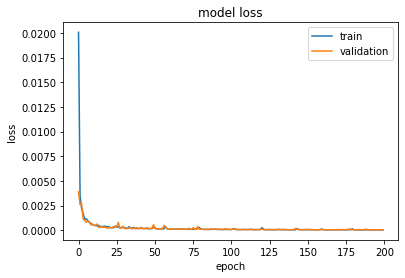

In [66]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [67]:
pred_model_3_y_test_std = model_3.predict(X_test)
pred_model_3_y_test = pred_model_3_y_test_std*(ymax-ymin) + ymin
pred_model_3_y_test.shape

(50022, 1)

In [68]:
rmse_lstm_3 = np.sqrt(mean_squared_error(y_test, pred_model_3_y_test))
print("RMSE of Stacked LSTM: ", rmse_lstm_3)
print("I.E. %.04f degree of mean error" % (rmse_lstm_3/math.pi*180))

RMSE of Stacked LSTM:  0.014476189773571978
I.E. 0.8294 degree of mean error


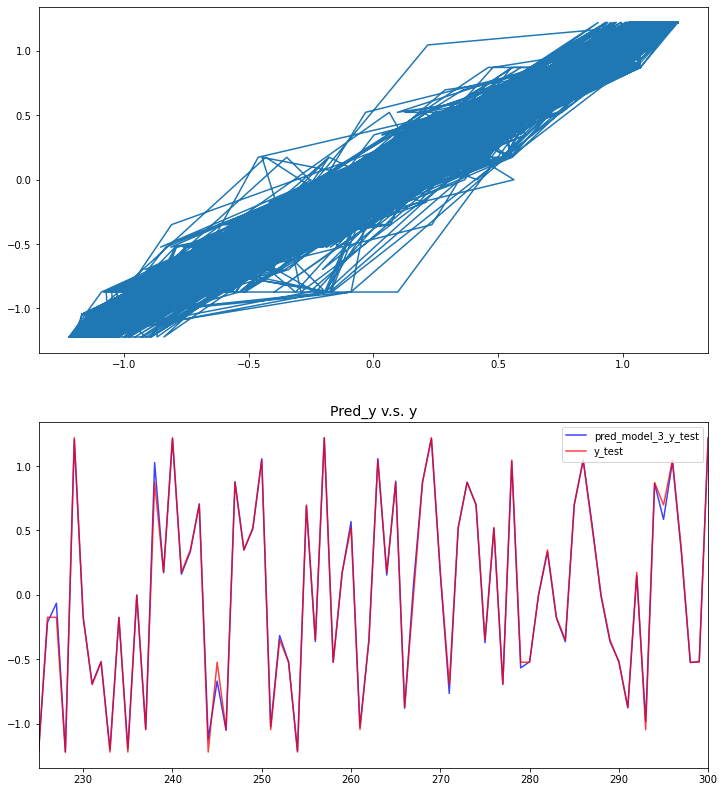

In [45]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_model_3_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_model_3_y_test.shape[0])], list(pred_model_3_y_test), color='b', alpha=0.75, label='pred_model_3_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"Pred_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='upper right')
ax_lst[1].set_xlim([225, 300])
plt.show()

In [69]:
import pickle

# Save
with open(join('checkpoints', 'Stacked-LSTM_X_105.pkl'), 'wb') as a_file:
    pickle.dump(model_3, a_file)

In [ ]:
# Load
with open(join('checkpoints', 'Stacked-LSTM_X_105.pkl'), 'rb') as a_file:
    model_3 = pickle.load(a_file)

## LSTM-Autoencoder
liuzm-DNN-DOA

In [71]:
feature_dim = 12
SF = 15

aec_x = Input(shape=(feature_dim, ))
aec1 = Dense(10, activation='linear')(aec_x)

aec_out = []
for i in range(SF):
    aec_out.append(Dense(feature_dim, activation='linear')(aec1))

AEC = Model(inputs=aec_x, outputs=aec_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
AEC.compile(optimizer=optimizer, loss=['mse' for i in range(SF)])
AEC.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           130         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           132         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 12)           132         dense_1[0][0]                    
____________________________________________________________________________________________

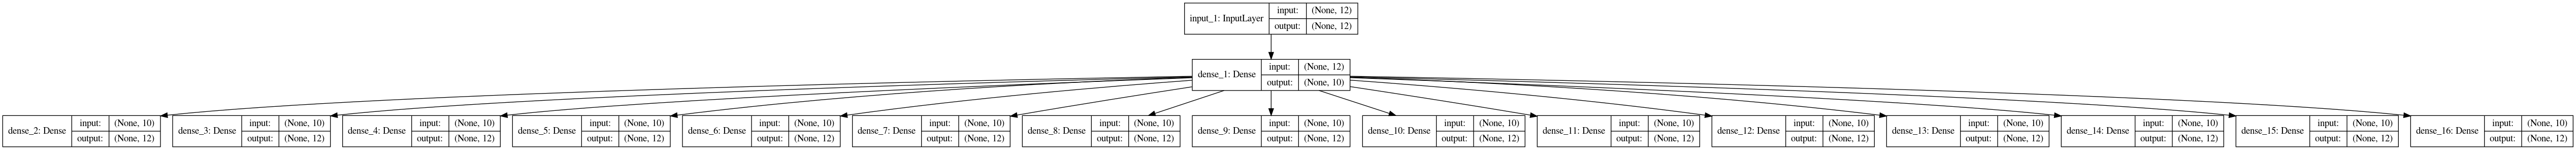

In [6]:
plot_model(
    AEC,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [101]:
AEC.output_shape

[(None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12)]

In [97]:
y_AEC_train_lst = []
for i in range(y_AEC_train.shape[2]):
    y_AEC_train_lst.append(y_AEC_train[:, :, i])
y_AEC_test_lst = []
for i in range(y_AEC_test.shape[2]):
    y_AEC_test_lst.append(y_AEC_test[:, :, i])
y_AEC_val_lst = []
for i in range(y_AEC_val.shape[2]):
    y_AEC_val_lst.append(y_AEC_val[:, :, i])

In [81]:
y_AEC_train[:, :, 0].shape

(125058, 12)

In [98]:
epochs = 30
batch_size = 128

history_aec = AEC.fit(X_train, y_AEC_train_lst, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_AEC_val_lst))

Train on 125058 samples, validate on 125058 samples
Epoch 1/30
125058/125058 [==============================] - 5s 36us/step - loss: 0.0107 - dense_2_loss: 6.1643e-04 - dense_3_loss: 6.2007e-04 - dense_4_loss: 7.7882e-04 - dense_5_loss: 6.0642e-04 - dense_6_loss: 8.0967e-04 - dense_7_loss: 7.5857e-04 - dense_8_loss: 8.2785e-04 - dense_9_loss: 5.7876e-04 - dense_10_loss: 6.3131e-04 - dense_11_loss: 5.0610e-04 - dense_12_loss: 5.9488e-04 - dense_13_loss: 6.7565e-04 - dense_14_loss: 8.8252e-04 - dense_15_loss: 0.0010 - dense_16_loss: 7.4294e-04 - val_loss: 0.0104 - val_dense_2_loss: 5.8783e-04 - val_dense_3_loss: 5.8497e-04 - val_dense_4_loss: 7.5871e-04 - val_dense_5_loss: 5.8752e-04 - val_dense_6_loss: 7.8412e-04 - val_dense_7_loss: 7.5117e-04 - val_dense_8_loss: 8.1642e-04 - val_dense_9_loss: 5.7724e-04 - val_dense_10_loss: 6.0758e-04 - val_dense_11_loss: 5.0472e-04 - val_dense_12_loss: 5.7534e-04 - val_dense_13_loss: 6.6706e-04 - val_dense_14_loss: 8.6794e-04 - val_dense_15_loss: 9.84

125058/125058 [==============================] - 5s 39us/step - loss: 0.0095 - dense_2_loss: 4.9493e-04 - dense_3_loss: 5.5508e-04 - dense_4_loss: 7.2575e-04 - dense_5_loss: 5.5180e-04 - dense_6_loss: 7.1766e-04 - dense_7_loss: 6.8931e-04 - dense_8_loss: 7.0878e-04 - dense_9_loss: 5.2253e-04 - dense_10_loss: 5.5587e-04 - dense_11_loss: 4.8869e-04 - dense_12_loss: 5.3398e-04 - dense_13_loss: 5.9866e-04 - dense_14_loss: 8.2318e-04 - dense_15_loss: 8.5125e-04 - dense_16_loss: 6.9565e-04 - val_loss: 0.0094 - val_dense_2_loss: 4.9011e-04 - val_dense_3_loss: 5.3853e-04 - val_dense_4_loss: 7.0871e-04 - val_dense_5_loss: 5.4656e-04 - val_dense_6_loss: 7.2426e-04 - val_dense_7_loss: 6.9499e-04 - val_dense_8_loss: 7.0929e-04 - val_dense_9_loss: 5.2213e-04 - val_dense_10_loss: 5.4448e-04 - val_dense_11_loss: 4.9011e-04 - val_dense_12_loss: 5.2714e-04 - val_dense_13_loss: 5.9490e-04 - val_dense_14_loss: 8.0804e-04 - val_dense_15_loss: 8.2869e-04 - val_dense_16_loss: 6.9696e-04
Epoch 18/30
125058/1

In [99]:
pred_y_AEC_test_lst = AEC.predict(X_test)

In [106]:
for i in range(15):
    print(pred_y_AEC_test_lst[i][0, :])

[ 2.8835842e-05  1.6408649e-03 -1.5224111e-03 -1.5567643e-04
 -1.3089292e-04 -1.7563585e-03 -1.3548508e-02  3.0837398e-02
 -3.1976584e-02 -1.8931227e-04  1.6038252e-02  3.0300539e-02]
[-5.5730314e-04  4.8524002e-05  2.2763369e-04  1.1975442e-03
  3.4488548e-05  3.7570775e-05  6.2760338e-03  3.5041552e-03
 -3.5911566e-03 -1.9688467e-03 -5.4474715e-03  2.9671257e-03]
[ 0.00074684  0.00111796 -0.00043414  0.00100173 -0.00111239 -0.00117958
  0.01463467  0.00234512 -0.01376821 -0.00142664 -0.02350983  0.00687418]
[-1.1172148e-03  6.2695448e-04  2.1102290e-04 -9.6820266e-05
  2.8263149e-04 -7.4107811e-04  8.0827676e-04 -3.3038240e-03
 -8.3865854e-04 -4.8879087e-03 -3.8015530e-03  1.6353279e-04]
[-0.00269637  0.00135573  0.00035555 -0.00073214  0.0010005  -0.0020338
  0.00246462 -0.00763517  0.01075351 -0.00962904 -0.00928399  0.00230799]
[-0.00195884  0.00184599  0.00052931  0.00014817  0.00376259 -0.00040718
  0.01217427 -0.01185872  0.02573572 -0.01921364  0.01783197 -0.02034738]
[-1.2484

In [107]:
for i in range(15):
    print(y_AEC_test_lst[i][0, :])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.00504908  0.01671184 -0.00666631  0.01020642  0.03090053 -0.02316523
  0.04148757  0.04935579 -0.07012966 -0.19205566 -0.13448215 -0.0489529 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


DeepAOANet

In [46]:
time_steps = 3
feature_dim = 20 #6

x0 = Input(shape=(time_steps, feature_dim))
l1 = LSTM(128, activation='relu', return_sequences=True)(x0)
l2 = LSTM(64, activation='relu', return_sequences=False)(l1)
h0 = RepeatVector(time_steps)(l2)
l3 = LSTM(64, activation='relu', return_sequences=True)(h0)
l4 = LSTM(128, activation='relu', return_sequences=True)(l3)
r0 = TimeDistributed(Dense(feature_dim))(l4)


LSTM_AE = Model(inputs=x0, outputs=r0)
LSTM_AE_optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-3)
LSTM_AE.compile(optimizer=LSTM_AE_optimizer, loss='mse')
LSTM_AE.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 20)             2580

In [47]:
epochs = 200
batch_size = 512

history_lstm_ae = LSTM_AE.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, X_val))

Train on 100042 samples, validate on 100043 samples
Epoch 1/200
100042/100042 [==============================] - 4s 41us/step - loss: 0.0081 - val_loss: 3.7529e-04
Epoch 2/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.8896e-04 - val_loss: 2.6762e-04
Epoch 3/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.4117e-04 - val_loss: 2.3241e-04
Epoch 4/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.2694e-04 - val_loss: 2.2732e-04
Epoch 5/200
100042/100042 [==============================] - 3s 33us/step - loss: 2.2001e-04 - val_loss: 2.1547e-04
Epoch 6/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.0925e-04 - val_loss: 2.0090e-04
Epoch 7/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.9033e-04 - val_loss: 1.7783e-04
Epoch 8/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.6765e-04 - val_loss: 1.6096e-04
Epoch 9/200
100042/10004

Epoch 140/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1191e-05 - val_loss: 1.1531e-05
Epoch 141/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1171e-05 - val_loss: 1.1440e-05
Epoch 142/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1137e-05 - val_loss: 1.1496e-05
Epoch 143/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1115e-05 - val_loss: 1.1681e-05
Epoch 144/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1068e-05 - val_loss: 1.1732e-05
Epoch 145/200
100042/100042 [==============================] - 3s 33us/step - loss: 1.1049e-05 - val_loss: 1.1297e-05
Epoch 146/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.0982e-05 - val_loss: 1.1318e-05
Epoch 147/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.0948e-05 - val_loss: 1.1322e-05
Epoch 148/200
100042/100042 [===========================

In [298]:
pred_X_test_std = LSTM_AE.predict(X_test, verbose=0)
print('---Predicted---')
print(np.round(pred_X_test_std, 4))
print('---Actual---')
print(np.round(X_test_std, 4))

---Predicted---
[[[ 9.072e-01  3.800e-03  2.964e-01 ...  4.969e-01  7.278e-01 -1.200e-03]
  [ 9.000e-04  4.600e-03  2.839e-01 ...  8.226e-01  9.159e-01 -2.400e-03]
  [ 8.970e-01 -1.400e-03  3.003e-01 ...  5.127e-01  7.464e-01  1.700e-03]]

 [[ 4.700e-03  1.000e-04  3.721e-01 ...  7.531e-01  4.164e-01 -6.000e-04]
  [ 3.700e-03  3.000e-04  3.677e-01 ...  7.593e-01  4.215e-01  0.000e+00]
  [ 3.700e-03  7.000e-04  3.705e-01 ...  7.589e-01  4.195e-01 -1.000e-04]]

 [[ 8.979e-01  2.000e-04  3.081e-01 ...  4.996e-01  7.446e-01  3.000e-04]
  [ 9.035e-01  1.600e-03  3.091e-01 ...  5.062e-01  7.476e-01 -3.000e-04]
  [ 8.916e-01  6.000e-04  3.072e-01 ...  5.074e-01  7.446e-01 -5.000e-04]]

 ...

 [[ 8.959e-01  2.000e-04  3.090e-01 ...  5.023e-01  7.394e-01  2.000e-04]
  [ 9.135e-01  1.600e-03  3.060e-01 ...  5.047e-01  7.460e-01 -1.000e-04]
  [ 8.934e-01  5.000e-04  3.071e-01 ...  5.049e-01  7.456e-01 -1.000e-04]]

 [[ 8.956e-01  3.000e-04  3.115e-01 ...  5.012e-01  7.413e-01  3.000e-04]
  [ 9.06

In [48]:
encoder = Model(inputs=x0, outputs=l2)
encoder.compile(optimizer='adam', loss='mse')
encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Predict both Train/Test data for further training the Regressor
pred_encoded_X_train_std = encoder.predict(X_train)
pred_encoded_X_test_std = encoder.predict(X_test)
pred_encoded_X_val_std = encoder.predict(X_val)
pred_encoded_X_test_std.shape

(50022, 64)

### Dense-regressor on Encoded R-features

In [55]:
def build_regressor(feature_dim = 64):
    
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(256, activation='relu')(x)
    h2 = Dense(512, activation='relu')(h1)
    h3 = Dense(256, activation='relu')(h2)
    h4 = Dense(128, activation='relu')(h3)
    r = Dense(1, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_4 = build_regressor(64)
Regressor_optimizer = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-4)
model_4.compile(optimizer=Regressor_optimizer, loss='mse')
model_4.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 312,577
Trainable params: 312,577
Non-trainable params: 0
_____________________________________________________

In [56]:
epochs = 200
batch_size = 256

history_model_4 = model_4.fit(pred_encoded_X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(pred_encoded_X_val_std, y_val_std))

Train on 100042 samples, validate on 100043 samples
Epoch 1/200
100042/100042 [==============================] - 2s 17us/step - loss: 0.0256 - val_loss: 0.0126
Epoch 2/200
100042/100042 [==============================] - 1s 14us/step - loss: 0.0104 - val_loss: 0.0080
Epoch 3/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0063 - val_loss: 0.0052
Epoch 4/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/200
100042/100042 [==============================] - 1s 12us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/200
100042/100042 [==============================] - 1s 14us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/200
100042/100042 [==============================] - 1s 12us/step - loss: 0.

Epoch 142/200
100042/100042 [==============================] - 1s 13us/step - loss: 4.0815e-04 - val_loss: 4.4086e-04
Epoch 143/200
100042/100042 [==============================] - 1s 14us/step - loss: 4.0947e-04 - val_loss: 3.9000e-04
Epoch 144/200
100042/100042 [==============================] - 1s 13us/step - loss: 4.0953e-04 - val_loss: 3.8882e-04
Epoch 145/200
100042/100042 [==============================] - 1s 14us/step - loss: 4.0960e-04 - val_loss: 3.8315e-04
Epoch 146/200
100042/100042 [==============================] - 1s 15us/step - loss: 4.0860e-04 - val_loss: 4.0486e-04
Epoch 147/200
100042/100042 [==============================] - 2s 17us/step - loss: 4.0796e-04 - val_loss: 4.1302e-04
Epoch 148/200
100042/100042 [==============================] - 2s 20us/step - loss: 3.9830e-04 - val_loss: 4.2687e-04
Epoch 149/200
100042/100042 [==============================] - 1s 15us/step - loss: 3.9985e-04 - val_loss: 4.0562e-04
Epoch 150/200
100042/100042 [===========================

In [57]:
pred_model_4_y_test_std = model_4.predict(pred_encoded_X_test_std)
pred_model_4_y_test = pred_model_4_y_test_std*(ymax-ymin) + ymin

rmse_model_4 = np.sqrt(mean_squared_error(y_test, pred_model_4_y_test))
print("RMSE of LSTM-AE + 4FC: ", rmse_model_4)
print("I.E. %.04f degree of mean error" % (rmse_model_4/math.pi*180))

RMSE of LSTM-AE + 4FC:  0.046166396617956115
I.E. 2.6451 degree of mean error


In [57]:
# Prepare unseen testing data
Xarr1.shape

(2230, 3, 6)

In [58]:
# Normalization
Xarr1_std = mmsc.transform(Xarr1.reshape(-1, Xarr1.shape[-1])).reshape(Xarr1.shape)
print(Xarr1_std.shape)

yarr1 = [item[0] for item in yarr1]
yarr1_std = (yarr1 - ymin)/(ymax-ymin)
print(yarr1_std.shape)

(2230, 3, 6)
(2230,)


Save and Load models

In [59]:
import pickle

encoder_fc_tuple = (encoder, model_4)

pkl_filename = "encoder_4fc_tuple_X_105.pkl"
with open(join('checkpoints', pkl_filename), 'wb') as a_file:
    pickle.dump(encoder_fc_tuple, a_file)

In [41]:
pkl_filename = "encoder_4fc_tuple_X_105.pkl"
with open(join('checkpoints', pkl_filename), 'rb') as a_file:
    encoder_cpy, model_4_cpy = pickle.load(a_file)
    
encoder_cpy.summary()
model_4_cpy.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16640     
___________________________________

In [43]:
# Predict output of model_4(encoder(X_train/test))
pred_encoded_LSTM_AE_4FC_std = encoder_cpy.predict(X_test)
pred_LSTM_AE_4FC_std = model_4_cpy.predict(pred_encoded_LSTM_AE_4FC_std)

In [45]:
pred_LSTM_AE_4FC = pred_LSTM_AE_4FC_std*(ymax-ymin) + ymin

rmse_LSTM_AE_4FC = np.sqrt(mean_squared_error(y_test, pred_LSTM_AE_4FC))
print("RMSE of (LSTM-AE + 4FC) upon unseen data X1: ", rmse_LSTM_AE_4FC)
print("I.E. %.04f degree of mean error" % (rmse_LSTM_AE_4FC/math.pi*180))

RMSE of (LSTM-AE + 4FC) upon unseen data X1:  0.046166396617956115
I.E. 2.6451 degree of mean error


### Build end-to-end Encoder+FC model

In [71]:
time_steps = 3
feature_dim = 20 #6

x0 = Input(shape=(time_steps, feature_dim))
l1 = LSTM(128, activation='relu', return_sequences=True)(x0)
l2 = LSTM(64, activation='relu', return_sequences=False)(l1)

# Build encoder_fc model
fc1 = Dense(256, activation='relu')(l2)
fc2 = Dense(512, activation='relu')(fc1)
fc3 = Dense(256, activation='relu')(fc2)
fc4 = Dense(128, activation='relu')(fc3)
fc_out = Dense(1, activation='sigmoid')(fc4)

model_encoder_fc = Model(inputs=x0, outputs=fc_out)

Encoder_fc_optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model_encoder_fc.compile(optimizer=Encoder_fc_optimizer, loss='mse')
model_encoder_fc.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               3289

In [72]:
epochs = 300
batch_size = 256

history_model_encoder_fc = model_encoder_fc.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test, y_test_std))

Train on 100042 samples, validate on 50022 samples
Epoch 1/300
100042/100042 [==============================] - 4s 38us/step - loss: 0.0195 - val_loss: 0.0057
Epoch 2/300
100042/100042 [==============================] - 3s 30us/step - loss: 0.0039 - val_loss: 0.0028
Epoch 3/300
100042/100042 [==============================] - 3s 29us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 4/300
100042/100042 [==============================] - 3s 28us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/300
100042/100042 [==============================] - 3s 29us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/300
100042/100042 [==============================] - 3s 30us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/300
100042/100042 [==============================] - 3s 30us/step - loss: 0.0010 - val_loss: 9.7114e-04
Epoch 8/300
100042/100042 [==============================] - 3s 29us/step - loss: 9.1219e-04 - val_loss: 7.6264e-04
Epoch 9/300
100042/100042 [==============================] - 3s 30us/step

Epoch 141/300
100042/100042 [==============================] - 3s 31us/step - loss: 9.2366e-05 - val_loss: 6.7365e-05
Epoch 142/300
100042/100042 [==============================] - 3s 34us/step - loss: 7.8539e-05 - val_loss: 5.4216e-05
Epoch 143/300
100042/100042 [==============================] - 3s 34us/step - loss: 6.4479e-05 - val_loss: 8.8078e-05
Epoch 144/300
100042/100042 [==============================] - 3s 29us/step - loss: 9.0775e-05 - val_loss: 4.4446e-05
Epoch 145/300
100042/100042 [==============================] - 3s 31us/step - loss: 4.5876e-05 - val_loss: 4.8055e-05
Epoch 146/300
100042/100042 [==============================] - 3s 31us/step - loss: 1.0731e-04 - val_loss: 5.7913e-05
Epoch 147/300
100042/100042 [==============================] - 3s 34us/step - loss: 6.1664e-05 - val_loss: 4.6796e-05
Epoch 148/300
100042/100042 [==============================] - 3s 30us/step - loss: 4.0659e-04 - val_loss: 3.3423e-04
Epoch 149/300
100042/100042 [===========================

100042/100042 [==============================] - 3s 31us/step - loss: 5.2450e-05 - val_loss: 1.7907e-04
Epoch 280/300
100042/100042 [==============================] - 3s 31us/step - loss: 4.2905e-05 - val_loss: 3.0435e-05
Epoch 281/300
100042/100042 [==============================] - 4s 37us/step - loss: 8.1357e-05 - val_loss: 0.0024
Epoch 282/300
100042/100042 [==============================] - 3s 32us/step - loss: 2.6261e-04 - val_loss: 4.7712e-05
Epoch 283/300
100042/100042 [==============================] - 3s 31us/step - loss: 3.8320e-05 - val_loss: 3.1296e-05
Epoch 284/300
100042/100042 [==============================] - 4s 41us/step - loss: 3.3381e-05 - val_loss: 2.7350e-05
Epoch 285/300
100042/100042 [==============================] - 3s 29us/step - loss: 1.2691e-04 - val_loss: 4.5898e-05
Epoch 286/300
100042/100042 [==============================] - 3s 30us/step - loss: 3.2214e-05 - val_loss: 5.7052e-05
Epoch 287/300
100042/100042 [==============================] - 3s 30us/ste

In [73]:
pred_model_encoder_fc_y_test_std = model_encoder_fc.predict(X_test)
pred_model_encoder_fc_y_test = pred_model_encoder_fc_y_test_std*(ymax-ymin) + ymin

rmse_model_encoder_fc = np.sqrt(mean_squared_error(y_test, pred_model_encoder_fc_y_test))
print("RMSE of ENCODER-FC: ", rmse_model_encoder_fc)
print("I.E. %.04f degree of mean error" % (rmse_model_encoder_fc/math.pi*180))

RMSE of ENCODER-FC:  0.013476036123474023
I.E. 0.7721 degree of mean error


In [157]:
# Try unseen data X1
pred_ENCODER_FC_E2E_std = model_encoder_fc.predict(Xarr1)
pred_ENCODER_FC_E2E = pred_ENCODER_FC_E2E_std*(ymax-ymin) + ymin

rmse_ENCODER_FC_E2E = np.sqrt(mean_squared_error(yarr1, pred_ENCODER_FC_E2E))
print("RMSE [Rad] of (end-to-end ENCODER+FC) upon unseen data X1: ", rmse_ENCODER_FC_E2E)
print("I.E. %.04f degree of mean error" % (rmse_ENCODER_FC_E2E/math.pi*180))

RMSE [Rad] of (end-to-end ENCODER+FC) upon unseen data X1:  0.7433023721801533
I.E. 42.5881 degree of mean error


In [74]:
import pickle
# Save
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'wb') as a_file:
    pickle.dump(model_encoder_fc, a_file)

In [ ]:
# Load
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'rb') as a_file:
    model_encoder_fc = pickle.load(a_file)

### SVR on Encoded R-features (Optional)

In [69]:
# SVR
svr_ae = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_ae.fit(pred_encoded_X_train_std, y_train)
svr_ae.score(pred_encoded_X_test_std, y_test)

0.9426798652526259

In [75]:
'''
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(pred_encoded_X_train_std, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
'''

"\nparams = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}\ngrid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)\ngrid.fit(pred_encoded_X_train_std, y_train)\nprint(grid.best_estimator_)\nprint(grid.best_score_)\n"

In [180]:
with open(join('checkpoints', 'svr_ae.pkl'), 'wb') as a_file:
    pickle.dump(svr_ae, a_file)

In [145]:
with open(join('checkpoints', 'svr_ae.pkl'), 'rb') as a_file:
    svr_ae = pickle.load(a_file)

In [70]:
pred_EncodeSVR_y_test = svr_ae.predict(pred_encoded_X_val_std)
rmse_svr_ae = np.sqrt(mean_squared_error(y_val, pred_EncodeSVR_y_test))
print("RMSE [Rad] for LSTM-AE + SVR:", rmse_svr_ae)
print("I.E. %.04f degree of mean error" % (rmse_svr_ae/math.pi*180))

RMSE [Rad] for LSTM-AE + SVR: 0.17454503691309395
I.E. 10.0007 degree of mean error


In [152]:
# Try unseen data X1
pred_SVR_AE = svr_ae.predict(pred_encoded_LSTM_AE_4FC_std)

rmse_SVR_AE = np.sqrt(mean_squared_error(yarr1, pred_SVR_AE))
print("RMSE [Rad] of (LSTM-AE + SVR) upon unseen data X1: ", rmse_SVR_AE)
print("I.E. %.04f degree of mean error" % (rmse_SVR_AE/math.pi*180))

RMSE [Rad] of (LSTM-AE + SVR) upon unseen data X1:  2.110344460674068
I.E. 120.9138 degree of mean error


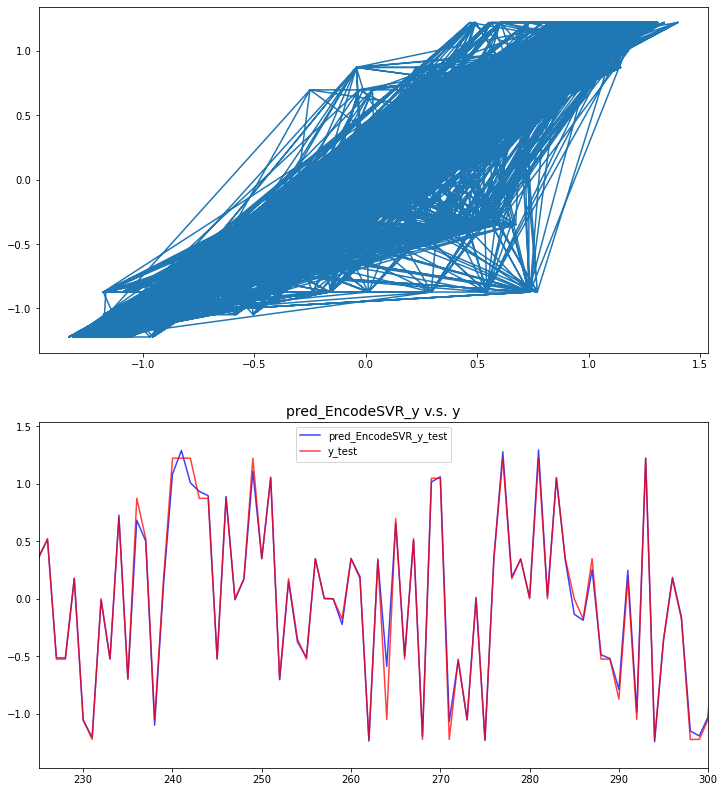

In [140]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_EncodeSVR_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_EncodeSVR_y_test.shape[0])], list(pred_EncodeSVR_y_test), color='b', alpha=0.75, label='pred_EncodeSVR_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"pred_EncodeSVR_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='best')
ax_lst[1].set_xlim([225, 300])
plt.show()

### Visualize CDF

In [71]:
y_err_series = pd.Series(abs(y_val - pred_EncodeSVR_y_test) / math.pi*180)

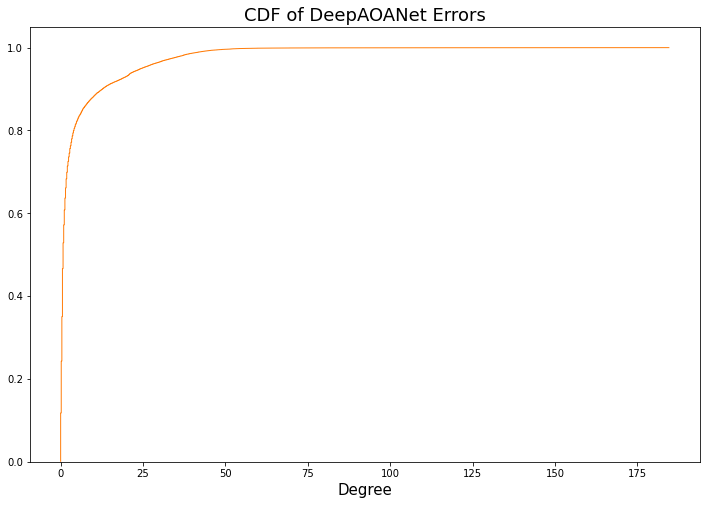

In [72]:
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
n, bins, patches = ax_hist.hist(y_err_series, density=True, cumulative = True, histtype='step', bins=1000, color='tab:orange')
patches[0].set_xy(patches[0].get_xy()[:-1])
ax_hist.set_title("CDF of DeepAOANet Errors", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
plt.show()

### Directly apply SVR on Rjk

In [75]:
# Xsingle equivalent to Xvec_clean
print(np.argwhere(np.isnan(yvec)), np.argwhere(np.isnan(yvec_clean)))

[[145087      0]
 [145088      0]
 [145089      0]
 [148528      0]
 [148529      0]
 [148530      0]
 [151969      0]
 [151970      0]
 [151971      0]
 [155410      0]
 [155411      0]
 [155412      0]
 [186379      0]
 [186380      0]
 [186381      0]
 [189820      0]
 [189821      0]
 [189822      0]
 [193261      0]
 [193262      0]
 [193263      0]
 [196702      0]
 [196703      0]
 [196704      0]] []


In [74]:
# repeat shuffle?
Xsingle = Xvec[~np.isnan(Xvec).any(axis=1)]
ysingle0 = yvec[~np.isnan(yvec).any(axis=1)]
ysingle = [item[0] for item in ysingle0]

In [76]:
yvec_clean.shape

(312645, 2)

In [77]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(Xvec_clean, yvec_clean[:,0], test_size=0.7, random_state=42)

In [84]:
svr_0 = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_0.fit(X_train0, y_train0)
svr_0.score(X_test0, y_test0)

0.7462810025375146

In [181]:
# Save SVR
with open(join('checkpoints', 'svr_0.pkl'), 'wb') as a_file:
    pickle.dump(svr_0, a_file)

In [78]:
# Load SVR
with open(join('checkpoints', 'svr_0.pkl'), 'rb') as a_file:
    svr_0 = pickle.load(a_file)

In [79]:
pred_SVR0_y_test = svr_0.predict(X_test0)
rmse0 = np.sqrt(mean_squared_error(y_test0, pred_SVR0_y_test))
print("RMSE for SVR0:", rmse0)
print("I.E. %.04f degree of mean error" % (rmse0/math.pi*180))

RMSE for SVR0: 0.4976814884388284
I.E. 28.5150 degree of mean error


In [ ]:
# Unseen X1/Xphs1
pred_SVR0_Xvec1_test = svr_0.predict(Xvec1)
rmse_SVR0_Xvec1 = np.sqrt(mean_squared_error(yvec1[:, 0], pred_SVR0_Xvec1_test))
print("RMSE for SVR0 on unseen data:", rmse_SVR0_Xvec1)
print("I.E. %.04f degree of mean error" % (rmse_SVR0_Xvec1/math.pi*180))

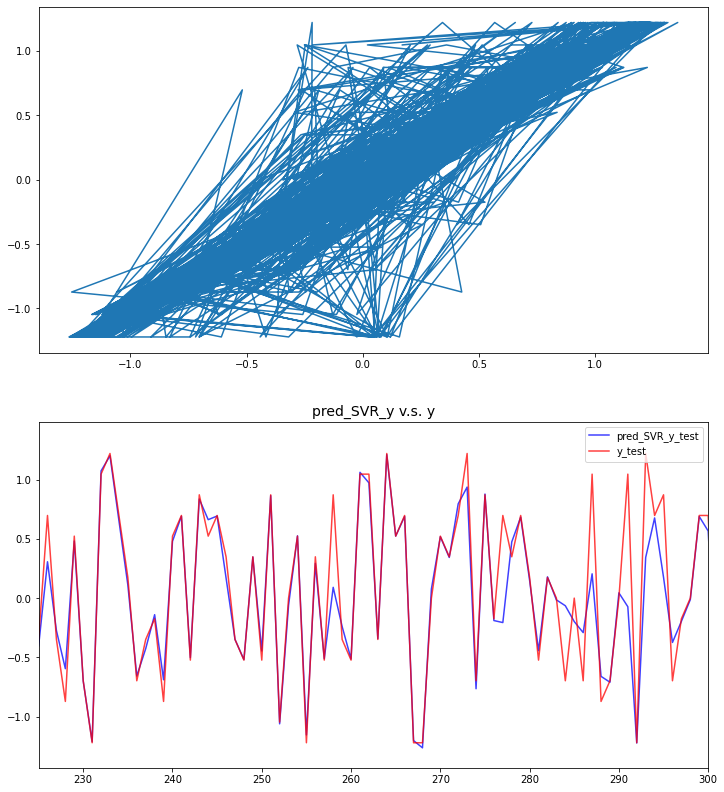

In [159]:
fig0 ,ax_lst0 = plt.subplots(2, 1,figsize=(12,14))
ax_lst0[0].plot(pred_SVR0_y_test[:2000], y_test0[:2000])
ax_lst0[1].plot([i for i in range(pred_SVR0_y_test.shape[0])], list(pred_SVR0_y_test), color='b', alpha=0.75, label='pred_SVR_y_test')
ax_lst0[1].plot(y_test0, color='red', alpha=0.75, label='y_test')
ax_lst0[1].set_title(f"pred_SVR_y v.s. y",fontsize=14)
ax_lst0[1].grid(False)
ax_lst0[1].legend(loc='best')
ax_lst0[1].set_xlim([225, 300])
plt.show()

# CDF

In [80]:
# Benchmark: MUSIC
y_err_music_series = pd.Series(abs(y_test[i] / math.pi*180 - y_test_music[i]) for i in range(len(y_test)))

In [81]:
# Benchmark: LSTM-AE + SVR
#y_err_lstm_ae_svr_series = pd.Series(abs(y_test - pred_EncodeSVR_y_test) / math.pi*180)

In [82]:
# Benchmark: SVR0
y_err_svr0_series = pd.Series(abs(y_test0 - pred_SVR0_y_test) / math.pi*180)

In [87]:
# Benchmark: LSTM-AE + 4FC
#y_err_lstm_ae_fc_series = pd.Series(abs(y_val - pred_model_4_y_test.ravel()) / math.pi*180)
#y_err_lstm_ae_fc_series = pd.Series(abs(y_test - pred_LSTM_AE_4FC.ravel()) / math.pi*180)
y_err_lstm_ae_fc_series = pd.Series(abs(y_test - pred_model_encoder_fc_y_test.ravel()) / math.pi*180)

In [85]:
# Benchmark: Stacked-LSTM
y_err_lstm_stacked_lstm_series = pd.Series(abs(y_test - pred_model_3_y_test.ravel()) / math.pi*180)

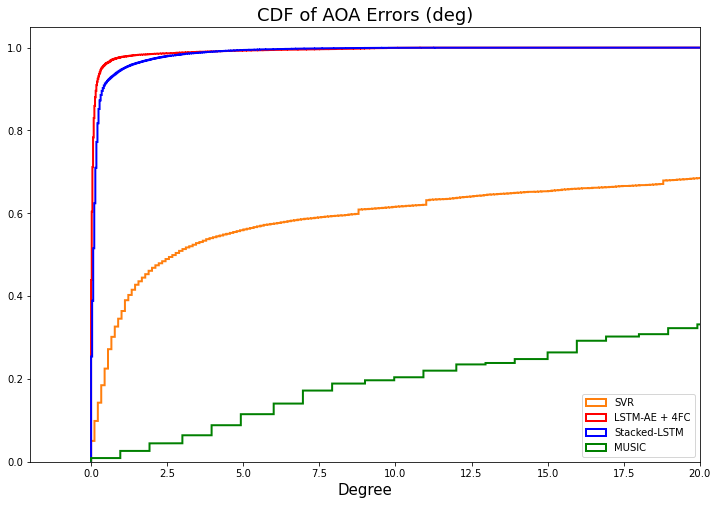

In [88]:
%matplotlib inline
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
'''
n, bins, patches = ax_hist.hist(y_err_lstm_ae_svr_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='LSTM-AE + SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
'''
n, bins, patches = ax_hist.hist(y_err_svr0_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
n2, bins2, patches2 = ax_hist.hist(y_err_lstm_ae_fc_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='red', linewidth=2, label='LSTM-AE + 4FC')
patches2[0].set_xy(patches2[0].get_xy()[:-1])
n3, bins3, patches3 = ax_hist.hist(y_err_lstm_stacked_lstm_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='b', linewidth=2, label='Stacked-LSTM')
patches3[0].set_xy(patches3[0].get_xy()[:-1])
n4, bins4, patches4 = ax_hist.hist(y_err_music_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='g', linewidth=2, label='MUSIC')
patches4[0].set_xy(patches4[0].get_xy()[:-1])

ax_hist.set_title("CDF of AOA Errors (deg)", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
ax_hist.set_xlim(-2, 20)
ax_hist.legend(loc='lower right')

fig_hist.savefig(join('doc', 'CDF2.0_X_105.png'), facecolor="w", bbox_inches='tight')
plt.show()

# Validation
### (1) Unseen NLOS Data [-45, 0, 45]

In [2]:
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

In [3]:
test_dict = {}
test_dir = join('data_1606', 'test')

for filename in os.listdir(test_dir):
    if filename.startswith("test_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[- float(filename[6:-4])] = aoa_Rjk
    elif filename.startswith("test_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[float(filename[5:-4])] = aoa_Rjk

In [6]:
test_sig = {}
test_sig_index = {}

for key in test_dict.keys():
    test_dict[key]['theta'] = key * math.pi / 180
    test_sig_index[key] = (test_dict[key][(abs(test_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(test_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data23']) >= field_thres)].index)
    test_sig[key] = test_dict[key].iloc[test_sig_index[key], :]

X45 = pd.concat([test_sig[rad] for rad in test_dict.keys()], \
                 keys=[rad for rad in test_dict.keys()], names=['Series name', 'Row ID'])
X45['music'] = pd.Series([0] * len(X45.index))

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
print(X45.shape, len(X45))

(499, 22) 499


In [90]:
# CREATE: If using R_phase as input feature
Xphs_45, Xamp_45 = [], []
for item in [X45]:
    phs, amp = create_Xphs_Xamp(item)
    Xphs_45.append(phs)
    Xamp_45.append(amp)
    
Xphs_45[0]

r12       r13       r14       r23  r24       r34  \
Series name Row ID                                                     
-45.0       0       0.0 -0.584400 -2.562005 -1.698066  0.0 -2.149339   
            1       0.0 -0.435424 -2.517031 -1.727634  0.0 -1.703768   
            2       0.0 -1.983908 -2.656720 -1.502667  0.0  0.189015   
            3       0.0 -0.540016 -2.599287 -1.844297  0.0 -2.151937   
            15      0.0 -0.457718 -2.506565 -1.714339  0.0 -2.113907   
...                 ...       ...       ...       ...  ...       ...   
 45.0       1700    0.0 -0.680340 -2.799323 -0.808793  0.0 -2.554681   
            1701    0.0 -0.235561 -2.661797 -0.823952  0.0 -2.332732   
            1702    0.0  0.092232 -2.675180 -0.743071  0.0 -2.680688   
            1703    0.0 -0.340383 -2.803112 -0.903844  0.0 -2.574776   
            1704    0.0 -0.114608 -2.746498 -0.858374  0.0 -2.731961   

                       theta  music  
Series name Row ID                   
-45.0       0      -0.785398    NaN  
            1      -0.785398    NaN  
            2      -0.785398    NaN  
            3      -0.785398    NaN  
            15     -0.785398    NaN  
...                      ...    ...  
 45.0       1700    0.785398    NaN  
            1701    0.785398    NaN  
            1702    0.785398    NaN  
            1703    0.785398    NaN  
            1704    0.785398    NaN  

[3111 rows x 8 columns]

In [22]:
type(X45)

pandas.core.frame.DataFrame

In [15]:
# SPLIT
Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(X45, aoa_gt_series=range(-45, 90, 45), \
                                                                   feature_space=20)
    
Xtest_arr.shape

(317, 3, 20)

In [16]:
ytest_vec.shape

(499, 2)

In [19]:
# SHUFFLE
X_train_null, X_test2, y_train_null, y_test2 = train_test_split(Xtest_arr, ytest_lst2, test_size=0.99, random_state=42)

In [20]:
print(X_test2.shape, len(y_test2))

(314, 3, 20) 314


In [38]:
# Normalization
#X_test2_std = mmsc.transform(X_test2.reshape(-1, X_test2.shape[-1])).reshape(X_test2.shape)

y_test2_lst = [item[0] for item in y_test2]
y_test2_lst_std = (y_test2_lst - ymin)/(ymax-ymin)

EVAL

In [99]:
# Stacked LSTM
pred_X_test2_std = model_3.predict(X_test2_std)
pred_X_test2 = pred_X_test2_std*(ymax - ymin) + ymin

pred_X_test2_std.shape

(2655, 1)

In [100]:
rmse_lstm_model_3_test2 = np.sqrt(mean_squared_error(y_test2_lst, pred_X_test2_std))
print("RMSE of Stacked LSTM: ", rmse_lstm_model_3_test2)
print("I.E. %.04f degree of mean error" % (rmse_lstm_model_3_test2/math.pi*180))

RMSE of Stacked LSTM:  0.6765697700547708
I.E. 38.7646 degree of mean error


In [101]:
# Encoder-SVR
pred_EncoderSVR_ytest_lst = svr_ae.predict(encoder.predict(X_test2_std))

rmse_EncoderSVR = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderSVR_ytest_lst))
print("RMSE of LSTM-Encoder + SVR: ", rmse_EncoderSVR)
print("I.E. %.04f degree of mean error" % (rmse_EncoderSVR/math.pi*180))

NameError: name 'svr_ae' is not defined

In [48]:
# Encoder-FC
pred_EncoderFC_ytest_lst = model_4_cpy.predict(encoder_cpy.predict(X_test2))

rmse_EncoderFC = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderFC_ytest_lst))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC/math.pi*180))

RMSE of LSTM-Encoder + FC:  1.2451705685713792
I.E. 71.3430 degree of mean error


In [108]:
# DirectSVR
#X_train_null, X_test2vec, y_train_null, y_test2vec = train_test_split(Xtest_vec, ytest_vec, test_size=0.9, random_state=42)
pred_SVR_0_X_test2 = svr_0.predict(X_test2[:, 0, :])
rmse_svronly2 = np.sqrt(mean_squared_error(y_test2_lst, pred_SVR_0_X_test2))
print("RMSE for SVR-Only:", rmse_svronly2)
print("I.E. %.04f degree of mean error" % (rmse_svronly2/math.pi*180))

RMSE for SVR-Only: 1.0544157098489537
I.E. 60.4136 degree of mean error


### (2) Test with SEEN LOS data [-45, -25, 25, 45]

In [10]:
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

# List of data.fields used in filtering
fields_filter_lst = ['field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data22', 'field.data23']

In [26]:
ymax = 1.2217304763960306
ymin =  -1.2217304763960306

In [38]:
def load_raw(test_dir = 'testLOS', field_thres=field_thres):
    
    aoa_dict = {}
    
    for filename in os.listdir(test_dir):
        if filename.startswith("deg_m") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- float(filename[-6:-4])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[float(filename[-6:-4])] = aoa_Rjk
            
    #Degree to Radian
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180
    
    # Differentiate R of LoRa signal or noise
    aoa_sig, aoa_noi = {}, {}
    sig_index_lst = {}

    for key in aoa_dict.keys():
        filtered_indexed = aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(aoa_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data23']) >= field_thres)].index
        
        aoa_noi[key] = aoa_dict[key].drop(filtered_indexed)
        aoa_sig[key] = aoa_dict[key].iloc[filtered_indexed]
        sig_index_lst[key] = (filtered_indexed)
    
    # Concat dict of raw data into a DataFrame
    X = pd.concat([aoa_sig[rad] for rad in aoa_sig.keys()], \
                     keys=[rad for rad in aoa_sig.keys()], names=['Series name', 'Row ID'])
    X['music'] = pd.Series([0] * len(X.index))
    
    return X

In [39]:
X_test_LOS = load_raw()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
# SPLIT
aoa_gt_lst = [-45, -25, 25, 45]

Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(X_test_LOS, aoa_gt_series=aoa_gt_lst, \
                                                                   feature_space=20)

Xtest_arr.shape

(235, 3, 20)

In [42]:
# SHUFFLE
X_train_null, X_test, y_train_null, y_test = train_test_split(Xtest_arr, ytest_lst2, test_size=0.99, random_state=42)

In [48]:
X_test.shape

(233, 3, 20)

In [50]:
# Prepare
y_test_np = np.array([item[0] for item in y_test])
y_test_std = (y_test_np - ymin)/(ymax-ymin)

y_test_std.shape

(233,)

Evaluation

In [51]:
import pickle
# Load
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'rb') as a_file:
    model_encoder_fc = pickle.load(a_file)
model_encoder_fc.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               328

In [53]:
pred_X_test_std = model_encoder_fc.predict(X_test)
pred_X_test = pred_X_test_std*(ymax - ymin) + ymin

In [54]:
rmse_EncoderFC_on_testLOS = np.sqrt(mean_squared_error(y_test_np, pred_X_test))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC_on_testLOS)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC_on_testLOS/math.pi*180))

RMSE of LSTM-Encoder + FC:  0.6839860370804993
I.E. 39.1895 degree of mean error


### (3) Test with SEEN Corridor data [-45, -25, 25, 45]

In [55]:
X_test_Cor = load_raw(test_dir = 'testCorridor')

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
# SPLIT
aoa_gt_lst = [-45, -25, 25, 45]
Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(X_test_Cor, aoa_gt_series=aoa_gt_lst, \
                                                                   feature_space=20)

# SHUFFLE
X_train_null, X_test, y_train_null, y_test = train_test_split(Xtest_arr, ytest_lst2, \
                                                              test_size=0.99, random_state=42)

# Prepare
y_test_np = np.array([item[0] for item in y_test])
y_test_std = (y_test_np - ymin)/(ymax-ymin)

print(X_test.shape, y_test_np.shape)

(230, 3, 20) (230,)


In [57]:
import pickle
# Load
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'rb') as a_file:
    model_encoder_fc = pickle.load(a_file)
model_encoder_fc.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               3289

In [58]:
pred_X_test_std = model_encoder_fc.predict(X_test)
pred_X_test = pred_X_test_std*(ymax - ymin) + ymin

rmse_EncoderFC_on_testCor = np.sqrt(mean_squared_error(y_test_np, pred_X_test))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC_on_testCor)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC_on_testCor/math.pi*180))

RMSE of LSTM-Encoder + FC:  0.993562806180296
I.E. 56.9270 degree of mean error
